In [1]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [2]:
def target_function_list(X):
    Y = np.array([[0]])
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
            period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
        Y = np.append(Y, [[days_survived]], axis = 0)
    return Y[1:]

In [5]:
# Sanity Checks with experimental parameters

mutation_rates = {
    "size": 0,
    "speed": 0,
    "vision": 0,
    "aggression": 0
}

days_log = []
for i in tqdm(range(10)):
    main_simulator = MainSimulator()
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=1, should_display_day=True, should_display_grid=False, should_display_traits=False, should_display_population=True), max_days=10000)
    days_log.append(days_survived)
    print(days_survived)
days_log

  0%|                                                                                                                                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

10.637905195293133 0.9918945668494507
Total food: 2486
Day number: 1
Population: 2175
11.273332335643042 0.9680926294144182
Total food: 2407
Day number: 2
Population: 2661
11.903813145857246 0.9300749637628036
Total food: 2338
Day number: 3
Population: 2884
12.526898871648548 0.8801135390798891
Total food: 2198
Day number: 4
Population: 3335
13.140169943749475 0.8210154546635451
Total food: 2048
Day number: 5
Population: 3480
13.74124552684678 0.7558303280083635
Total food: 1906
Day number: 6
Population: 3652
14.327792915650727 0.6875671163564296
Total food: 1693
Day number: 7
Population: 3520
14.897536741017154 0.6189583326160325
Total food: 1536
Day number: 8
Population: 3355
15.448267949789965 0.5522952662684876
Total food: 1368
Day number: 9
Population: 2992
15.977852522924731 0.48934162406032117
Total food: 1216
Day number: 10
Population: 2576
16.484239897486894 0.43131899243983435
Total food: 1126
Day number: 11
Population: 2176
16.965471059286887 0.37894820649787425
Total food: 

 10%|████████████████████████████                                                                                                                                                                                                                                                            | 1/10 [00:00<00:07,  1.15it/s]

Day number: 15
Population: 790
18.60327925502015 0.22756297202184206
Total food: 538
Day number: 16
Population: 587
18.933066800438638 0.20270700873762387
Total food: 490
Day number: 17
Population: 403
19.228270524660196 0.1820963133722551
Total food: 440
Day number: 18
Population: 294
19.487764858882514 0.16524044220012485
Total food: 398
Day number: 19
Population: 204
19.710565162951536 0.1516922448314127
Total food: 360
Day number: 20
Population: 122
19.89583161128631 0.14106286095481405
Total food: 342
Day number: 21
Population: 94
20.042872507286887 0.13302931467563026
Total food: 330
Day number: 22
Population: 53
20.151147013144776 0.12733731197567333
Total food: 335
Day number: 23
Population: 35
20.220267284282716 0.12380131866124337
Total food: 325
Day number: 24
Population: 27
20.25 0.12230345334690061
Total food: 311
Day number: 25
Population: 20
20.24026728428272 0.12279223709930295
Total food: 302
Day number: 26
Population: 11
20.19114701314478 0.12528181630620072
Total foo

 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 2/10 [00:01<00:06,  1.21it/s]

Day number: 12
Population: 1777
17.419686274214115 0.33252677754625126
Total food: 821
Day number: 13
Population: 1403
17.845132427757893 0.2920231917164815
Total food: 722
Day number: 14
Population: 1060
18.24016994374947 0.2571725511726895
Total food: 670
Day number: 15
Population: 808
18.60327925502015 0.22756297202184206
Total food: 573
Day number: 16
Population: 628
18.933066800438638 0.20270700873762387
Total food: 507
Day number: 17
Population: 433
19.228270524660196 0.1820963133722551
Total food: 446
Day number: 18
Population: 326
19.487764858882514 0.16524044220012485
Total food: 415
Day number: 19
Population: 237
19.710565162951536 0.1516922448314127
Total food: 363
Day number: 20
Population: 158
19.89583161128631 0.14106286095481405
Total food: 382
Day number: 21
Population: 116
20.042872507286887 0.13302931467563026
Total food: 311
Day number: 22
Population: 75
20.151147013144776 0.12733731197567333
Total food: 307
Day number: 23
Population: 46
20.220267284282716 0.12380131

 30%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 3/10 [00:02<00:05,  1.21it/s]

Day number: 11
Population: 2214
16.965471059286887 0.37894820649787425
Total food: 941
Day number: 12
Population: 1774
17.419686274214115 0.33252677754625126
Total food: 826
Day number: 13
Population: 1405
17.845132427757893 0.2920231917164815
Total food: 737
Day number: 14
Population: 1070
18.24016994374947 0.2571725511726895
Total food: 649
Day number: 15
Population: 831
18.60327925502015 0.22756297202184206
Total food: 571
Day number: 16
Population: 617
18.933066800438638 0.20270700873762387
Total food: 497
Day number: 17
Population: 459
19.228270524660196 0.1820963133722551
Total food: 429
Day number: 18
Population: 331
19.487764858882514 0.16524044220012485
Total food: 391
Day number: 19
Population: 222
19.710565162951536 0.1516922448314127
Total food: 360
Day number: 20
Population: 137
19.89583161128631 0.14106286095481405
Total food: 364
Day number: 21
Population: 90
20.042872507286887 0.13302931467563026
Total food: 324
Day number: 22
Population: 55
20.151147013144776 0.1273373

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 4/10 [00:03<00:05,  1.15it/s]

Day number: 35
Population: 0
35
10.637905195293133 0.9918945668494507
Total food: 2474
Day number: 1
Population: 2301
11.273332335643042 0.9680926294144182
Total food: 2419
Day number: 2
Population: 2863
11.903813145857246 0.9300749637628036
Total food: 2333
Day number: 3
Population: 3110
12.526898871648548 0.8801135390798891
Total food: 2202
Day number: 4
Population: 3533
13.140169943749475 0.8210154546635451
Total food: 2073
Day number: 5
Population: 3765
13.74124552684678 0.7558303280083635
Total food: 1893
Day number: 6
Population: 3906
14.327792915650727 0.6875671163564296
Total food: 1719
Day number: 7
Population: 3749
14.897536741017154 0.6189583326160325
Total food: 1533
Day number: 8
Population: 3506
15.448267949789965 0.5522952662684876
Total food: 1385
Day number: 9
Population: 3226
15.977852522924731 0.48934162406032117
Total food: 1262
Day number: 10
Population: 2746
16.484239897486894 0.43131899243983435
Total food: 1094
Day number: 11
Population: 2275
16.965471059286887 

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 5/10 [00:04<00:04,  1.10it/s]

Day number: 13
Population: 1419
17.845132427757893 0.2920231917164815
Total food: 727
Day number: 14
Population: 1064
18.24016994374947 0.2571725511726895
Total food: 643
Day number: 15
Population: 790
18.60327925502015 0.22756297202184206
Total food: 553
Day number: 16
Population: 571
18.933066800438638 0.20270700873762387
Total food: 533
Day number: 17
Population: 408
19.228270524660196 0.1820963133722551
Total food: 419
Day number: 18
Population: 277
19.487764858882514 0.16524044220012485
Total food: 402
Day number: 19
Population: 202
19.710565162951536 0.1516922448314127
Total food: 367
Day number: 20
Population: 139
19.89583161128631 0.14106286095481405
Total food: 348
Day number: 21
Population: 89
20.042872507286887 0.13302931467563026
Total food: 329
Day number: 22
Population: 49
20.151147013144776 0.12733731197567333
Total food: 310
Day number: 23
Population: 29
20.220267284282716 0.12380131866124337
Total food: 293
Day number: 24
Population: 22
20.25 0.12230345334690061
Total 

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 6/10 [00:05<00:03,  1.07it/s]

Day number: 37
Population: 2
17.225471059286885 0.35199136301585604
Total food: 931
Day number: 38
Population: 3
16.7642398974869 0.4004770458636084
Total food: 1056
Day number: 39
Population: 2
16.277852522924732 0.4546494275134309
Total food: 1100
Day number: 40
Population: 2
15.76826794978997 0.5140378887041457
Total food: 1281
Day number: 41
Population: 3
15.237536741017152 0.5777374095535664
Total food: 1438
Day number: 42
Population: 2
14.687792915650729 0.6443533337770893
Total food: 1635
Day number: 43
Population: 2
14.121245526846781 0.7119886605782749
Total food: 1771
Day number: 44
Population: 4
13.540169943749474 0.7782900070067821
Total food: 1970
Day number: 45
Population: 7
12.946898871648553 0.8405622555677377
Total food: 2148
Day number: 46
Population: 6
12.343813145857247 0.8959513169416091
Total food: 2242
Day number: 47
Population: 6
11.733332335643045 0.9416808900407577
Total food: 2357
Day number: 48
Population: 8
11.117905195293137 0.9753155293290072
Total food: 

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 7/10 [00:06<00:02,  1.04it/s]

Total food: 1005
Day number: 39
Population: 4
16.277852522924732 0.4546494275134309
Total food: 1114
Day number: 40
Population: 4
15.76826794978997 0.5140378887041457
Total food: 1301
Day number: 41
Population: 4
15.237536741017152 0.5777374095535664
Total food: 1433
Day number: 42
Population: 7
14.687792915650729 0.6443533337770893
Total food: 1618
Day number: 43
Population: 12
14.121245526846781 0.7119886605782749
Total food: 1767
Day number: 44
Population: 13
13.540169943749474 0.7782900070067821
Total food: 1949
Day number: 45
Population: 17
12.946898871648553 0.8405622555677377
Total food: 2098
Day number: 46
Population: 21
12.343813145857247 0.8959513169416091
Total food: 2253
Day number: 47
Population: 31
11.733332335643045 0.9416808900407577
Total food: 2353
Day number: 48
Population: 34
11.117905195293137 0.9753155293290072
Total food: 2443
Day number: 49
Population: 36
10.500000000000002 0.9950124791926823
Total food: 2491
Day number: 50
Population: 52
9.882094804706867 0.999

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 8/10 [00:07<00:01,  1.07it/s]

Day number: 25
Population: 15
20.24026728428272 0.12279223709930295
Total food: 318
Day number: 26
Population: 9
20.19114701314478 0.12528181630620072
Total food: 298
Day number: 27
Population: 5
20.10287250728689 0.12985190658901843
Total food: 324
Day number: 28
Population: 1
19.97583161128631 0.13664836565845662
Total food: 319
Day number: 29
Population: 0
29
10.637905195293133 0.9918945668494507
Total food: 2475
Day number: 1
Population: 2276
11.273332335643042 0.9680926294144182
Total food: 2409
Day number: 2
Population: 2759
11.903813145857246 0.9300749637628036
Total food: 2328
Day number: 3
Population: 3025
12.526898871648548 0.8801135390798891
Total food: 2205
Day number: 4
Population: 3531
13.140169943749475 0.8210154546635451
Total food: 2061
Day number: 5
Population: 3685
13.74124552684678 0.7558303280083635
Total food: 1871
Day number: 6
Population: 3747
14.327792915650727 0.6875671163564296
Total food: 1750
Day number: 7
Population: 3632
14.897536741017154 0.6189583326160

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9/10 [00:08<00:00,  1.13it/s]

Total food: 329
Day number: 24
Population: 18
20.25 0.12230345334690061
Total food: 327
Day number: 25
Population: 15
20.24026728428272 0.12279223709930295
Total food: 278
Day number: 26
Population: 10
20.19114701314478 0.12528181630620072
Total food: 310
Day number: 27
Population: 7
20.10287250728689 0.12985190658901843
Total food: 318
Day number: 28
Population: 5
19.97583161128631 0.13664836565845662
Total food: 360
Day number: 29
Population: 4
19.810565162951537 0.14588395875715676
Total food: 372
Day number: 30
Population: 1
19.607764858882515 0.15783850141042183
Total food: 365
Day number: 31
Population: 1
19.368270524660197 0.17285713196408753
Total food: 456
Day number: 32
Population: 1
19.093066800438635 0.191344984852188
Total food: 503
Day number: 33
Population: 1
18.78327925502015 0.21375604530568348
Total food: 536
Day number: 34
Population: 0
34
10.637905195293133 0.9918945668494507
Total food: 2479
Day number: 1
Population: 2226
11.273332335643042 0.9680926294144182
Total

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]

Day number: 20
Population: 138
19.89583161128631 0.14106286095481405
Total food: 328
Day number: 21
Population: 91
20.042872507286887 0.13302931467563026
Total food: 329
Day number: 22
Population: 58
20.151147013144776 0.12733731197567333
Total food: 321
Day number: 23
Population: 39
20.220267284282716 0.12380131866124337
Total food: 364
Day number: 24
Population: 30
20.25 0.12230345334690061
Total food: 311
Day number: 25
Population: 23
20.24026728428272 0.12279223709930295
Total food: 306
Day number: 26
Population: 13
20.19114701314478 0.12528181630620072
Total food: 320
Day number: 27
Population: 9
20.10287250728689 0.12985190658901843
Total food: 309
Day number: 28
Population: 6
19.97583161128631 0.13664836565845662
Total food: 358
Day number: 29
Population: 4
19.810565162951537 0.14588395875715676
Total food: 359
Day number: 30
Population: 3
19.607764858882515 0.15783850141042183
Total food: 373
Day number: 31
Population: 3
19.368270524660197 0.17285713196408753
Total food: 434
Da

[33, 30, 29, 35, 40, 77, 76, 29, 34, 35]

In [28]:
space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])

design = RandomDesign(space) # Collect random points
num_data_points = 100
X = design.get_samples(num_data_points)
Y = target_function_list(X)

11.14022935152764
12.275998204157476
13.402863662543043
14.516417968967385
15.612305898749053
16.686241948324202
17.73402724817131
18.751566133830874
19.73488230962194
20.68013454126452
Day number: 10
21.583631815476412
22.441847906716394
23.251435293585406
24.00923836996421
24.71230589874905
25.357902659036274
25.943520240789546
26.466886944388353
26.925976745988525
27.31901729331276
Day number: 20
27.64449690031536
27.901170513116394
28.0880646236606
28.204481111708887
28.25
28.22448111170889
28.128064623660602
27.961170513116397
27.72449690031536
27.419017293312766
Day number: 30
27.045976745988526
26.60688694438835
26.103520240789543
25.53790265903627
24.912305898749054
24.229238369964207
23.491435293585408
22.7018479067164
21.863631815476417
20.98013454126452
Day number: 40
20.054882309621945
19.091566133830874
18.09402724817131
17.06624194832421
16.012305898749055
14.936417968967394
13.842863662543044
12.735998204157482
11.620229351527644
10.500000000000002
Day number: 50
9.37977

In [33]:
results = np.append(X,Y,axis=1)

In [34]:
np.savetxt('testing_data.csv', [result for result in results], delimiter=',', fmt='%s')

In [8]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [9]:
def plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis):
    axis.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
    axis.plot(x_plot, (nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)), "purple", label="NLCB")
    axis.plot(x_plot, (pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)), "darkorange", label="PI")
    
    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [ ]:
x_plot = np.linspace(0, 10, 1000)[:, None]
X = np.array([[0],[5], [10]])
Y = np.array([[0]])
for x in X:
    Y = np.append(Y_init,target_speed_function(x),axis=0)
Y = Y[1:]

speed_model = GPRegression(X, Y, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
emukit_speed_model = GPyModelWrapper(speed_model)

ei_acquisition = ExpectedImprovement(emukit_speed_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_speed_model)
pi_acquisition = ProbabilityOfImprovement(emukit_speed_model)

In [ ]:

mu_plot, var_plot = emukit_speed_model.predict(x_plot)
plot_prediction(X,Y,x_plot,mu_plot,var_plot,plt)
plt.show()

In [ ]:
iterations = 20
figure, axis = plt.subplots(iterations, 2, figsize=(10, iterations*3))

for i in tqdm(range(iterations)):
    mu_plot, var_plot = emukit_speed_model.predict(x_plot)
    plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis[i,0])
    
    ei_plot = ei_acquisition.evaluate(x_plot)
    nlcb_plot = nlcb_acquisition.evaluate(x_plot)
    pi_plot = pi_acquisition.evaluate(x_plot)
    
    optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 10)]))
    x_new, _ = optimizer.optimize(nlcb_acquisition)
    print("Next position to query:", x_new)
    plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis[i,1])
    
    y_new = target_speed_function(x_new)
    X = np.append(X, x_new, axis=0)
    Y = np.append(Y, y_new, axis=0)
    emukit_speed_model.set_data(X, Y)

plt.show()

In [ ]:
X_train = np.array([np.array([110,200,200,400]),np.array([300,252,300,400])])
Y_train = np.array([[100],[200]])

In [ ]:
# DGP using deepgp library
Q = 5
num_layers = 1
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.Bias(X_train.shape[1])
num_inducing = 4 # Number of inducing points to use for sparsification
back_constraint = False # Whether to use back-constraint for variational posterior
encoder_dims=[[300],[150]] # Dimensions of the MLP back-constraint if set to true

dgp_model = deepgp.DeepGP([X_train.shape[1], num_layers, Y_train.shape[1]], X_train, Y_train, kernels=[kern2,None], num_inducing=num_inducing, back_constraint=back_constraint, encoder_dims=encoder_dims)

for i in range(len(dgp_model.layers)):
    output_var = dgp_model.layers[i].Y.var() if i==0 else dgp_model.layers[i].Y.mean.var()
    dgp_model.layers[i].Gaussian_noise.variance = output_var*0.01
    dgp_model.layers[i].Gaussian_noise.variance.fix()

dgp_model.optimize(max_iters=800, messages=True)
for i in range(len(dgp_model.layers)):
    dgp_model.layers[i].Gaussian_noise.variance.unfix()
dgp_model.optimize(max_iters=1200, messages=True)

In [ ]:
display(dgp_model)

In [ ]:
x_plot = np.linspace(0, 1000, 1000)[:, None]
x_new = np.stack((x_plot,x_plot,x_plot,x_plot),axis = -1)
Y_pred = dgp_model.predict(np.array([[10,10,10,10]]))

In [ ]:
def target_size_function(x):
    mutation_rates = {
        "size": x,
        "speed": 0,
        "vision": 0,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived
    
def target_speed_function(x):
    mutation_rates = {
        "size": 0,
        "speed": x,
        "vision": 0,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_vision_function(x):
    mutation_rates = {
        "size": 0,
        "speed": 0,
        "vision": x,
        "aggression": 0
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_aggression_function(x):
    mutation_rates = {
        "size": 0,
        "speed": 0,
        "vision": 0,
        "aggression": x
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

def target_function(X):
    mutation_rates = {
        "size": X[0],
        "speed": X[1],
        "vision": X[2],
        "aggression": X[3]
    }
    days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
        period=10, should_display_day=True, should_display_grid=False, should_display_traits=False), max_days=10000)
    return days_survived

In [ ]:
x_plot = np.linspace(0, 20, 1000)[:, None]

X_size = np.array([0,1,20])
X_speed = np.array([0,1,20])
X_vision = np.array([0,1,20])
X_aggression = np.array([0,1,20])

In [ ]:
Y_size = np.array([])
for x in X_size:
    Y_size = np.append(Y_size,[target_size_function(x)],axis=0)

In [ ]:
Y_aggression

In [ ]:
Y_speed = np.array([])
for x in X_speed:
    Y_speed = np.append(Y_speed,[target_speed_function(x)],axis=0)

In [ ]:
Y_vision = np.array([])
for x in X_vision:
    Y_vision = np.append(Y_vision,[target_vision_function(x)],axis=0)

In [ ]:
Y_aggression = np.array([])
for x in X_aggression:
    Y_aggression = np.append(Y_aggression,[target_aggression_function(x)],axis=0)

In [ ]:
size_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
speed_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
vision_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
aggression_model = GPRegression(X_size, Y_size, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)

emukit_size_model = GPyModelWrapper(size_model)
emukit_speed_model = GPyModelWrapper(speed_model)
emukit_vision_model = GPyModelWrapper(vision_model)
emukit_aggression_model = GPyModelWrapper(agression_model)

size_ei_acquisition = ExpectedImprovement(emukit_size_model)
size_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_size_model)
size_pi_acquisition = ProbabilityOfImprovement(emukit_size_model)

speed_ei_acquisition = ExpectedImprovement(emukit_speed_model)
speed_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_speed_model)
speed_pi_acquisition = ProbabilityOfImprovement(emukit_speed_model)

vision_ei_acquisition = ExpectedImprovement(emukit_vision_model)
vision_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_vision_model)
vision_pi_acquisition = ProbabilityOfImprovement(emukit_vision_model)

aggression_ei_acquisition = ExpectedImprovement(emukit_aggression_model)
aggression_nlcb_acquisition = NegativeLowerConfidenceBound(emukit_aggression_model)
aggression_pi_acquisition = ProbabilityOfImprovement(emukit_aggression_model)

In [ ]:
X_train = np.array([[1,1,1,1, Y_size[1], Y_speed[1], Y_vision[1], Y_aggression[1]],
                   [1,0,0,0, Y_size[1], Y_speed[0], Y_vision[0], Y_aggression[0]],
                   [0,1,0,0, Y_size[0], Y_speed[1], Y_vision[0], Y_aggression[0]],
                   [0,0,1,0, Y_size[0], Y_speed[0], Y_vision[1], Y_aggression[0]],
                   [0,0,0,1, Y_size[0], Y_speed[0], Y_vision[0], Y_aggression[1]]])
Y_train = np.array([[target_function([1,1,1,1])],[Y_size[1]],[Y_speed[1]],[Y_vision[1]],[Y_aggression[1]]])
Q = 5
num_layers = 1
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.Bias(X_train.shape[1])
num_inducing = 4 # Number of inducing points to use for sparsification
back_constraint = False # Whether to use back-constraint for variational posterior
encoder_dims=[[300],[150]] # Dimensions of the MLP back-constraint if set to true

In [ ]:
def upper_confidence_bound(y_pred, y_std, beta):
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0

In [ ]:
iterations = 20
figure, axis = plt.subplots(iterations, 2, figsize=(10, iterations*3))

for i in tqdm(range(iterations)):
    mu_speed_plot, var_speed_plot = emukit_speed_model.predict(x_plot)
    ei_speed_plot = speed_ei_acquisition.evaluate(x_plot)
    nlcb_speed_plot = speed_nlcb_acquisition.evaluate(x_plot)
    pi_speed_plot = speed_pi_acquisition.evaluate(x_plot)
    
    size_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_size_new, _ = size_optimizer.optimize(size_nlcb_acquisition)
    speed_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_speed_new, _ = speed_optimizer.optimize(speed_nlcb_acquisition)
    vision_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_vision_new, _ = vision_optimizer.optimize(vision_nlcb_acquisition)
    aggression_optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('x1', 0, 20)]))
    x_aggression_new, _ = aggression_optimizer.optimize(agression_nlcb_acquisition)

    print("Next position to query:", x_size_new, x_speed_new, x_vision_new, x_agression_new)
    
    y_size_new = target_size_function(x_size_new)
    X_size = np.append(X_size, x_size_new, axis=0)
    Y_size = np.append(Y_size, y_size_new, axis=0)
    emukit_size_model.set_data(X_size, Y_size)
    X_train = np.append(X_train,[[x_size_new,0,0,0,y_size_new, Y_speed[0], Y_vision[0], Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_size_new]])

    y_speed_new = target_speed_function(x_speed_new)
    X_speed = np.append(X_speed, x_speed_new, axis=0)
    Y_speed = np.append(Y_speed, y_speed_new, axis=0)
    emukit_speed_model.set_data(X_speed, Y_speed)
    X_train = np.append(X_train,[[0,x_speed_new,0,0,Y_size[0], y_speed_new, Y_vision[0], Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_speed_new]])

    y_vision_new = target_vision_function(x_vision_new)
    X_vision = np.append(X_vision, x_vision_new, axis=0)
    Y_vision = np.append(Y_vision, y_vision_new, axis=0)
    emukit_vision_model.set_data(X_vision, Y_vision)
    X_train = np.append(X_train,[[0,0,x_vision_new,0,Y_size[0], Y_speed[0], y_vision_new, Y_aggression[0]]], axis=0)
    Y_train = np.append(Y_train,[[y_vision_new]])

    y_aggression_new = target_aggression_function(x_aggression_new)
    X_aggression = np.append(X_aggression, x_speed_new, axis=0)
    Y_aggression = np.append(Y_aggression, y_aggression_new, axis=0)
    emukit_aggression_model.set_data(X_aggression, Y_aggression)
    X_train = np.append(X_train,[[0,0,0,x_aggression_new,Y_size[0], Y_speed[0], Y_vision[0], y_aggression_new]], axis=0)
    Y_train = np.append(Y_train,[[y_aggression_new]])

    X_train = np.append(X_train,[[x_size_new,x_speed_new,x_vision_new,x_aggression_new,y_size_new,y_speed_new,y_vision_new,y_aggression_new]], axis=0)
    Y_train = np.append(Y_train,[[target_function([x_size_new,x_speed_new,x_vision_new,x_aggression_new])]])

    dgp_model = deepgp.DeepGP([X_train.shape[1], num_layers, Y_train.shape[1]], X_train, Y_train, kernels=[kern2,None], num_inducing=num_inducing, back_constraint=back_constraint, encoder_dims=encoder_dims)
    
    for i in range(len(dgp_model.layers)):
        output_var = dgp_model.layers[i].Y.var() if i==0 else dgp_model.layers[i].Y.mean.var()
        dgp_model.layers[i].Gaussian_noise.variance = output_var*0.01
        dgp_model.layers[i].Gaussian_noise.variance.fix()
    
    dgp_model.optimize(max_iters=800, messages=True)
    for i in range(len(dgp_model.layers)):
        dgp_model.layers[i].Gaussian_noise.variance.unfix()
    dgp_model.optimize(max_iters=1200, messages=True)

In [ ]:
x_plot = np.linspace(0, 10, 1000)[:, None]
X = np.array([[0],[5], [10]])
Y = np.array([[0]])
for x in X:
    Y = np.append(Y,target_speed_function(x),axis=0)
Y = Y[1:]

model = GPRegression(X, Y, GPy.kern.RBF(1, lengthscale=1, variance=100), noise_var=1)
emukit_model = GPyModelWrapper(model)

ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

In [12]:
def target_function_list(X):
    Y = np.array([[0]])
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
            period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
        Y = np.append(Y, [[days_survived]], axis = 0)
    return Y[1:]

In [13]:
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter

space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])

design = RandomDesign(space) # Collect random points
num_data_points = 5
X = design.get_samples(num_data_points)
Y = target_function_list(X)
model_gpy = GPRegression(X,Y,GPy.kern.RBF(1, lengthscale=0.05, variance=100)) # Train and wrap the model in Emukit
model_emukit = GPyModelWrapper(model_gpy)

In [14]:
ei_acquisition = ExpectedImprovement(model = model_emukit)
nlcb_acquisition = NegativeLowerConfidenceBound(model = model_emukit)
pi_acquisition = ProbabilityOfImprovement(model = model_emukit)

  0%|                                                                                                                                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

[[1.         0.16469923 0.57321417 0.54441345]]
Next position to query: [[1.         0.16469923 0.57321417 0.54441345]]


  0%|▎                                                                                                                                                                                                                                                                                     | 1/1000 [00:02<35:56,  2.16s/it]

[[0.17247633 0.63438211 0.94397756 0.19126605]]
Next position to query: [[0.17247633 0.63438211 0.94397756 0.19126605]]


  0%|▌                                                                                                                                                                                                                                                                                   | 2/1000 [00:07<1:07:46,  4.07s/it]

[[0.88356643 0.39118185 0.77976575 0.39794166]]
Next position to query: [[0.88356643 0.39118185 0.77976575 0.39794166]]


  0%|▊                                                                                                                                                                                                                                                                                     | 3/1000 [00:10<58:49,  3.54s/it]

[[0.66722156 0.2371978  0.77532115 0.00622379]]
Next position to query: [[0.66722156 0.2371978  0.77532115 0.00622379]]


  0%|█                                                                                                                                                                                                                                                                                   | 4/1000 [00:14<1:01:19,  3.69s/it]

[[0.45670686 0.45350452 0.19752159 0.4911486 ]]
Next position to query: [[0.45670686 0.45350452 0.19752159 0.4911486 ]]


  0%|█▍                                                                                                                                                                                                                                                                                  | 5/1000 [00:20<1:18:25,  4.73s/it]

[[0.78063418 0.64188566 0.99210223 0.4489521 ]]
Next position to query: [[0.78063418 0.64188566 0.99210223 0.4489521 ]]


  1%|█▋                                                                                                                                                                                                                                                                                  | 6/1000 [00:23<1:05:56,  3.98s/it]

[[0.73255702 0.37932268 0.43288201 0.62936468]]
Next position to query: [[0.73255702 0.37932268 0.43288201 0.62936468]]


  1%|█▉                                                                                                                                                                                                                                                                                  | 7/1000 [00:26<1:00:45,  3.67s/it]

[[0.60990511 0.17073237 0.7202617  0.82600716]]
Next position to query: [[0.60990511 0.17073237 0.7202617  0.82600716]]


  1%|██▏                                                                                                                                                                                                                                                                                   | 8/1000 [00:30<59:51,  3.62s/it]

[[1.         0.98967896 0.88695191 0.55968935]]
Next position to query: [[1.         0.98967896 0.88695191 0.55968935]]


  1%|██▌                                                                                                                                                                                                                                                                                   | 9/1000 [00:32<52:33,  3.18s/it]

[[1.         0.37413572 0.21700138 0.04790448]]
Next position to query: [[1.         0.37413572 0.21700138 0.04790448]]


  1%|██▊                                                                                                                                                                                                                                                                                | 10/1000 [00:39<1:13:52,  4.48s/it]

[[0.54399244 0.95415052 0.48484059 0.13380993]]
Next position to query: [[0.54399244 0.95415052 0.48484059 0.13380993]]


  1%|███                                                                                                                                                                                                                                                                                | 11/1000 [00:42<1:07:09,  4.07s/it]

[[0.76040865 0.14866412 0.55692024 0.53225396]]
Next position to query: [[0.76040865 0.14866412 0.55692024 0.53225396]]


  1%|███▎                                                                                                                                                                                                                                                                               | 12/1000 [00:46<1:05:18,  3.97s/it]

[[0.57178066 0.00854613 0.62874443 0.12691362]]
Next position to query: [[0.57178066 0.00854613 0.62874443 0.12691362]]


  1%|███▌                                                                                                                                                                                                                                                                               | 13/1000 [00:50<1:05:25,  3.98s/it]

[[0.57247343 0.82565493 0.36643208 0.67173323]]
Next position to query: [[0.57247343 0.82565493 0.36643208 0.67173323]]


  1%|███▊                                                                                                                                                                                                                                                                               | 14/1000 [00:53<1:01:40,  3.75s/it]

[[0.56823885 0.00132762 0.69575458 0.86362643]]
Next position to query: [[0.56823885 0.00132762 0.69575458 0.86362643]]


  2%|████▏                                                                                                                                                                                                                                                                                | 15/1000 [00:56<57:11,  3.48s/it]

[[0.56949882 0.49893679 0.35703191 0.18410227]]
Next position to query: [[0.56949882 0.49893679 0.35703191 0.18410227]]


  2%|████▍                                                                                                                                                                                                                                                                              | 16/1000 [01:01<1:02:45,  3.83s/it]

[[0.5671726  0.11176068 0.13387223 0.40852552]]
Next position to query: [[0.5671726  0.11176068 0.13387223 0.40852552]]


  2%|████▋                                                                                                                                                                                                                                                                              | 17/1000 [01:09<1:22:27,  5.03s/it]

[[0.76436432 0.0944412  0.82808417 0.48841812]]
Next position to query: [[0.76436432 0.0944412  0.82808417 0.48841812]]


  2%|████▉                                                                                                                                                                                                                                                                              | 18/1000 [01:12<1:16:06,  4.65s/it]

[[0.80248005 0.08822509 0.10353248 0.0558362 ]]
Next position to query: [[0.80248005 0.08822509 0.10353248 0.0558362 ]]


  2%|█████▏                                                                                                                                                                                                                                                                             | 19/1000 [02:30<7:16:49, 26.72s/it]

[[0.93010295 0.10829626 0.86189305 0.8190004 ]]
Next position to query: [[0.93010295 0.10829626 0.86189305 0.8190004 ]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_1570/2938512011.py:48: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  2%|█████▌                                                                                                                                                                                                                                                                             | 20/1000 [02:33<5:17:55, 19.46s/it]

[[0.92418172 0.14951866 0.35271541 0.2683542 ]]
Next position to query: [[0.92418172 0.14951866 0.35271541 0.2683542 ]]


  2%|█████▊                                                                                                                                                                                                                                                                             | 21/1000 [02:37<4:00:44, 14.75s/it]

[[0.94092323 0.09118356 0.65045117 0.49998954]]
Next position to query: [[0.94092323 0.09118356 0.65045117 0.49998954]]


  2%|██████                                                                                                                                                                                                                                                                             | 22/1000 [02:40<3:04:40, 11.33s/it]

[[0.91824602 0.00960056 0.43696403 0.27168244]]
Next position to query: [[0.91824602 0.00960056 0.43696403 0.27168244]]


  2%|██████▎                                                                                                                                                                                                                                                                            | 23/1000 [02:43<2:22:18,  8.74s/it]

[[0.91540563 0.58975396 0.01172777 0.47422471]]
Next position to query: [[0.91540563 0.58975396 0.01172777 0.47422471]]


  2%|██████▌                                                                                                                                                                                                                                                                            | 24/1000 [02:45<1:49:50,  6.75s/it]

[[0.91313662 0.02152828 0.37468751 0.69288329]]
Next position to query: [[0.91313662 0.02152828 0.37468751 0.69288329]]


  2%|██████▉                                                                                                                                                                                                                                                                            | 25/1000 [02:48<1:29:23,  5.50s/it]

[[0.91289171 0.64014341 0.71208344 0.09364597]]
Next position to query: [[0.91289171 0.64014341 0.71208344 0.09364597]]


  3%|███████▏                                                                                                                                                                                                                                                                           | 26/1000 [02:50<1:16:22,  4.70s/it]

[[0.91454687 0.00556309 0.008628   0.11927848]]
Next position to query: [[0.91454687 0.00556309 0.008628   0.11927848]]


  3%|███████▍                                                                                                                                                                                                                                                                           | 27/1000 [02:53<1:04:00,  3.95s/it]

[[0.91380361 0.09768546 0.29862645 0.45909726]]
Next position to query: [[0.91380361 0.09768546 0.29862645 0.45909726]]


  3%|███████▋                                                                                                                                                                                                                                                                           | 28/1000 [02:57<1:06:46,  4.12s/it]

[[0.91592722 0.89981202 0.90931042 0.10390587]]
Next position to query: [[0.91592722 0.89981202 0.90931042 0.10390587]]


  3%|████████                                                                                                                                                                                                                                                                             | 29/1000 [02:59<58:04,  3.59s/it]

[[0.91572037 0.00277392 0.93807172 0.33257428]]
Next position to query: [[0.91572037 0.00277392 0.93807172 0.33257428]]


  3%|████████▎                                                                                                                                                                                                                                                                            | 30/1000 [03:02<54:00,  3.34s/it]

[[0.91555737 0.12962365 0.49878019 0.30253358]]
Next position to query: [[0.91555737 0.12962365 0.49878019 0.30253358]]


  3%|████████▌                                                                                                                                                                                                                                                                            | 31/1000 [03:06<56:19,  3.49s/it]

[[0.91599757 0.22914852 0.41236748 0.13584494]]
Next position to query: [[0.91599757 0.22914852 0.41236748 0.13584494]]


  3%|████████▊                                                                                                                                                                                                                                                                            | 32/1000 [03:10<58:30,  3.63s/it]

[[0.91629783 0.04218163 0.17806111 0.08041655]]
Next position to query: [[0.91629783 0.04218163 0.17806111 0.08041655]]


  3%|█████████                                                                                                                                                                                                                                                                          | 33/1000 [03:23<1:43:16,  6.41s/it]

[[0.91757092 0.59539678 0.77579976 0.11145525]]
Next position to query: [[0.91757092 0.59539678 0.77579976 0.11145525]]


  3%|█████████▎                                                                                                                                                                                                                                                                         | 34/1000 [03:26<1:27:14,  5.42s/it]

[[0.91757386 0.02097247 0.95535105 0.41321856]]
Next position to query: [[0.91757386 0.02097247 0.95535105 0.41321856]]


  4%|█████████▋                                                                                                                                                                                                                                                                         | 35/1000 [03:29<1:15:15,  4.68s/it]

[[0.91757421 0.17619399 0.83352655 0.39187793]]
Next position to query: [[0.91757421 0.17619399 0.83352655 0.39187793]]


  4%|█████████▉                                                                                                                                                                                                                                                                         | 36/1000 [03:32<1:06:10,  4.12s/it]

[[0.91757361 0.0951686  0.34367915 0.239392  ]]
Next position to query: [[0.91757361 0.0951686  0.34367915 0.239392  ]]


  4%|██████████▏                                                                                                                                                                                                                                                                        | 37/1000 [03:36<1:08:06,  4.24s/it]

[[0.91757545 0.57157385 0.57542275 0.92089224]]
Next position to query: [[0.91757545 0.57157385 0.57542275 0.92089224]]


  4%|██████████▌                                                                                                                                                                                                                                                                          | 38/1000 [03:39<59:40,  3.72s/it]

[[0.9175751  0.53234906 0.70787987 0.92202612]]
Next position to query: [[0.9175751  0.53234906 0.70787987 0.92202612]]


  4%|██████████▊                                                                                                                                                                                                                                                                          | 39/1000 [03:41<52:11,  3.26s/it]

[[0.9175746  0.36365604 0.41736135 0.92530035]]
Next position to query: [[0.9175746  0.36365604 0.41736135 0.92530035]]


  4%|███████████                                                                                                                                                                                                                                                                          | 40/1000 [03:44<50:56,  3.18s/it]

[[0.91757487 0.01217636 0.2638451  0.8458033 ]]
Next position to query: [[0.91757487 0.01217636 0.2638451  0.8458033 ]]


  4%|███████████▎                                                                                                                                                                                                                                                                         | 41/1000 [03:47<50:46,  3.18s/it]

[[0.91757459 0.23245182 0.09584628 0.43180618]]
Next position to query: [[0.91757459 0.23245182 0.09584628 0.43180618]]


  4%|███████████▌                                                                                                                                                                                                                                                                       | 42/1000 [03:55<1:14:20,  4.66s/it]

[[0.75501928 0.02887366 0.8525663  0.73300023]]
Next position to query: [[0.75501928 0.02887366 0.8525663  0.73300023]]


  4%|███████████▊                                                                                                                                                                                                                                                                       | 43/1000 [03:59<1:08:20,  4.28s/it]

[[0.91744345 0.50942247 0.99148219 0.1709734 ]]
Next position to query: [[0.91744345 0.50942247 0.99148219 0.1709734 ]]


  4%|████████████▏                                                                                                                                                                                                                                                                        | 44/1000 [04:01<58:30,  3.67s/it]

[[0.91739618 0.85578313 0.18875781 0.18809633]]
Next position to query: [[0.91739618 0.85578313 0.18875781 0.18809633]]


  4%|████████████▍                                                                                                                                                                                                                                                                      | 45/1000 [04:05<1:00:59,  3.83s/it]

[[0.9175091  0.53981207 0.83175465 0.65796632]]
Next position to query: [[0.9175091  0.53981207 0.83175465 0.65796632]]


  5%|████████████▋                                                                                                                                                                                                                                                                        | 46/1000 [04:07<53:56,  3.39s/it]

[[0.91749029 0.13809937 0.46373596 0.71651334]]
Next position to query: [[0.91749029 0.13809937 0.46373596 0.71651334]]


  5%|█████████████                                                                                                                                                                                                                                                                        | 47/1000 [04:11<54:19,  3.42s/it]

[[0.91749997 0.12004854 0.56064527 0.58010504]]
Next position to query: [[0.91749997 0.12004854 0.56064527 0.58010504]]


  5%|█████████████▎                                                                                                                                                                                                                                                                       | 48/1000 [04:14<52:40,  3.32s/it]

[[0.91750772 0.78482167 0.16690787 0.62110101]]
Next position to query: [[0.91750772 0.78482167 0.16690787 0.62110101]]


  5%|█████████████▌                                                                                                                                                                                                                                                                       | 49/1000 [04:18<53:52,  3.40s/it]

[[0.91751471 0.95413222 0.24257091 0.95715052]]
Next position to query: [[0.91751471 0.95413222 0.24257091 0.95715052]]


  5%|█████████████▊                                                                                                                                                                                                                                                                       | 50/1000 [04:20<50:34,  3.19s/it]

[[0.91750161 0.48217808 0.3592555  0.10123272]]
Next position to query: [[0.91750161 0.48217808 0.3592555  0.10123272]]


  5%|██████████████▏                                                                                                                                                                                                                                                                      | 51/1000 [04:24<52:30,  3.32s/it]

[[0.91751296 0.61358278 0.46801536 0.05217723]]
Next position to query: [[0.91751296 0.61358278 0.46801536 0.05217723]]


  5%|██████████████▎                                                                                                                                                                                                                                                                    | 52/1000 [04:30<1:03:38,  4.03s/it]

[[0.56512316 0.38235053 0.60258402 0.42309942]]
Next position to query: [[0.56512316 0.38235053 0.60258402 0.42309942]]


  5%|██████████████▌                                                                                                                                                                                                                                                                    | 53/1000 [04:34<1:05:00,  4.12s/it]

[[0.24282141 0.29103613 0.11641151 0.79368904]]
Next position to query: [[0.24282141 0.29103613 0.11641151 0.79368904]]


  5%|██████████████▊                                                                                                                                                                                                                                                                    | 54/1000 [04:45<1:36:07,  6.10s/it]

[[0.11656337 0.98689753 0.94178201 0.69790148]]
Next position to query: [[0.11656337 0.98689753 0.94178201 0.69790148]]


  6%|███████████████▏                                                                                                                                                                                                                                                                   | 55/1000 [04:51<1:37:37,  6.20s/it]

[[0.91753496 0.3361422  0.57507086 0.21507187]]
Next position to query: [[0.91753496 0.3361422  0.57507086 0.21507187]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_1570/82289318.py:2: RuntimeWarning:invalid value encountered in divide
 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_1570/82289318.py:4: RuntimeWarning:invalid value encountered in divide
  6%|███████████████▍                                                                                                                                                                                                                                                                   | 56/1000 [04:55<1:24:41,  5.38s/it]

[[0.91753666 0.377837   0.22054639 0.64031526]]
Next position to query: [[0.91753666 0.377837   0.22054639 0.64031526]]


  6%|███████████████▋                                                                                                                                                                                                                                                                   | 57/1000 [04:59<1:17:51,  4.95s/it]

[[0.91753779 0.25601011 0.98311662 0.03288389]]
Next position to query: [[0.91753779 0.25601011 0.98311662 0.03288389]]


  6%|███████████████▉                                                                                                                                                                                                                                                                   | 58/1000 [05:02<1:09:55,  4.45s/it]

[[0.91753942 0.45741277 0.84944667 0.44179857]]
Next position to query: [[0.91753942 0.45741277 0.84944667 0.44179857]]


  6%|████████████████▏                                                                                                                                                                                                                                                                  | 59/1000 [05:05<1:01:42,  3.93s/it]

[[0.91753712 0.85086196 0.30660989 0.17007399]]
Next position to query: [[0.91753712 0.85086196 0.30660989 0.17007399]]


  6%|████████████████▌                                                                                                                                                                                                                                                                    | 60/1000 [05:08<58:02,  3.70s/it]

[[0.91753842 0.99723799 0.18934635 0.65717224]]
Next position to query: [[0.91753842 0.99723799 0.18934635 0.65717224]]


  6%|████████████████▉                                                                                                                                                                                                                                                                    | 61/1000 [05:11<54:22,  3.47s/it]

[[0.91753531 0.52347865 0.88936029 0.46436752]]
Next position to query: [[0.91753531 0.52347865 0.88936029 0.46436752]]


  6%|█████████████████▏                                                                                                                                                                                                                                                                   | 62/1000 [05:13<49:43,  3.18s/it]

[[0.91753071 0.0644783  0.63232951 0.2768509 ]]
Next position to query: [[0.91753071 0.0644783  0.63232951 0.2768509 ]]


  6%|█████████████████▍                                                                                                                                                                                                                                                                   | 63/1000 [05:16<47:13,  3.02s/it]

[[0.91752527 0.93225876 0.86662303 0.05368389]]
Next position to query: [[0.91752527 0.93225876 0.86662303 0.05368389]]


  6%|█████████████████▋                                                                                                                                                                                                                                                                   | 64/1000 [05:18<44:23,  2.85s/it]

[[0.91751789 0.24644795 0.76046098 0.95413623]]
Next position to query: [[0.91751789 0.24644795 0.76046098 0.95413623]]


  6%|██████████████████                                                                                                                                                                                                                                                                   | 65/1000 [05:21<42:22,  2.72s/it]

[[0.91750718 0.33838784 0.5049352  0.71618986]]
Next position to query: [[0.91750718 0.33838784 0.5049352  0.71618986]]


  7%|██████████████████▎                                                                                                                                                                                                                                                                  | 66/1000 [05:24<44:02,  2.83s/it]

[[0.91751185 0.14212207 0.97062991 0.709593  ]]
Next position to query: [[0.91751185 0.14212207 0.97062991 0.709593  ]]


  7%|██████████████████▌                                                                                                                                                                                                                                                                  | 67/1000 [05:27<44:04,  2.83s/it]

[[0.91750109 0.09893157 0.75544755 0.42806236]]
Next position to query: [[0.91750109 0.09893157 0.75544755 0.42806236]]


  7%|██████████████████▊                                                                                                                                                                                                                                                                  | 68/1000 [05:30<46:04,  2.97s/it]

[[0.91750733 0.37519533 0.99221305 0.2704001 ]]
Next position to query: [[0.91750733 0.37519533 0.99221305 0.2704001 ]]


  7%|███████████████████                                                                                                                                                                                                                                                                  | 69/1000 [05:33<46:51,  3.02s/it]

[[0.91751029 0.83261855 0.39640325 0.55822167]]
Next position to query: [[0.91751029 0.83261855 0.39640325 0.55822167]]


  7%|███████████████████▍                                                                                                                                                                                                                                                                 | 70/1000 [05:35<44:05,  2.84s/it]

[[0.91749879 0.25299597 0.11440371 0.30838795]]
Next position to query: [[0.91749879 0.25299597 0.11440371 0.30838795]]


  7%|███████████████████▌                                                                                                                                                                                                                                                               | 71/1000 [05:43<1:05:16,  4.22s/it]

[[0.91755102 0.26264665 0.56493385 0.41162585]]
Next position to query: [[0.91755102 0.26264665 0.56493385 0.41162585]]


  7%|███████████████████▊                                                                                                                                                                                                                                                               | 72/1000 [05:46<1:02:18,  4.03s/it]

[[0.91754853 0.20142999 0.46766206 0.71116055]]
Next position to query: [[0.91754853 0.20142999 0.46766206 0.71116055]]


  7%|████████████████████                                                                                                                                                                                                                                                               | 73/1000 [05:50<1:01:02,  3.95s/it]

[[0.91754689 0.6936282  0.32810542 0.35198643]]
Next position to query: [[0.91754689 0.6936282  0.32810542 0.35198643]]


  7%|████████████████████▍                                                                                                                                                                                                                                                                | 74/1000 [05:54<58:42,  3.80s/it]

[[0.91754566 0.34338295 0.59115656 0.50608518]]
Next position to query: [[0.91754566 0.34338295 0.59115656 0.50608518]]


  8%|████████████████████▊                                                                                                                                                                                                                                                                | 75/1000 [05:57<58:11,  3.78s/it]

[[0.91754111 0.48242915 0.32363088 0.17553108]]
Next position to query: [[0.91754111 0.48242915 0.32363088 0.17553108]]


  8%|████████████████████▉                                                                                                                                                                                                                                                              | 76/1000 [06:02<1:00:04,  3.90s/it]

[[0.91754009 0.55904937 0.57278325 0.9751452 ]]
Next position to query: [[0.91754009 0.55904937 0.57278325 0.9751452 ]]


  8%|█████████████████████▎                                                                                                                                                                                                                                                               | 77/1000 [06:04<54:22,  3.53s/it]

[[0.91754046 0.86861075 0.22758973 0.6454445 ]]
Next position to query: [[0.91754046 0.86861075 0.22758973 0.6454445 ]]


  8%|█████████████████████▌                                                                                                                                                                                                                                                               | 78/1000 [06:07<52:43,  3.43s/it]

[[0.91754009 0.22923659 0.6906955  0.55065383]]
Next position to query: [[0.91754009 0.22923659 0.6906955  0.55065383]]


  8%|█████████████████████▉                                                                                                                                                                                                                                                               | 79/1000 [06:11<52:01,  3.39s/it]

[[0.91753996 0.84673413 0.24417724 0.84473414]]
Next position to query: [[0.91753996 0.84673413 0.24417724 0.84473414]]


  8%|██████████████████████▏                                                                                                                                                                                                                                                              | 80/1000 [06:14<50:02,  3.26s/it]

[[0.91754027 0.76847871 0.03695702 0.50640278]]
Next position to query: [[0.91754027 0.76847871 0.03695702 0.50640278]]


  8%|██████████████████████▍                                                                                                                                                                                                                                                              | 81/1000 [06:17<48:17,  3.15s/it]

[[0.91754012 0.62756556 0.02872236 0.33565858]]
Next position to query: [[0.91754012 0.62756556 0.02872236 0.33565858]]


  8%|██████████████████████▋                                                                                                                                                                                                                                                              | 82/1000 [06:19<44:22,  2.90s/it]

[[0.91754062 0.36996295 0.65861285 0.08210682]]
Next position to query: [[0.91754062 0.36996295 0.65861285 0.08210682]]


  8%|██████████████████████▉                                                                                                                                                                                                                                                              | 83/1000 [06:23<49:53,  3.26s/it]

[[0.91753927 0.07590656 0.50846886 0.38125382]]
Next position to query: [[0.91753927 0.07590656 0.50846886 0.38125382]]


  8%|███████████████████████▎                                                                                                                                                                                                                                                             | 84/1000 [06:26<48:00,  3.15s/it]

[[0.91753926 0.07678921 0.96725045 0.22355579]]
Next position to query: [[0.91753926 0.07678921 0.96725045 0.22355579]]


  8%|███████████████████████▌                                                                                                                                                                                                                                                             | 85/1000 [06:29<47:28,  3.11s/it]

[[0.91753925 0.84360795 0.08706365 0.09143589]]
Next position to query: [[0.91753925 0.84360795 0.08706365 0.09143589]]


  9%|███████████████████████▊                                                                                                                                                                                                                                                             | 86/1000 [06:34<57:17,  3.76s/it]

[[0.75573948 0.14388512 0.31844776 0.87144418]]
Next position to query: [[0.75573948 0.14388512 0.31844776 0.87144418]]


  9%|████████████████████████                                                                                                                                                                                                                                                             | 87/1000 [06:38<57:36,  3.79s/it]

[[0.91747124 0.86864514 0.38120991 0.64566579]]
Next position to query: [[0.91747124 0.86864514 0.38120991 0.64566579]]


  9%|████████████████████████▍                                                                                                                                                                                                                                                            | 88/1000 [06:41<53:08,  3.50s/it]

[[0.91744521 0.09082218 0.59213448 0.50503392]]
Next position to query: [[0.91744521 0.09082218 0.59213448 0.50503392]]


  9%|████████████████████████▋                                                                                                                                                                                                                                                            | 89/1000 [06:44<53:02,  3.49s/it]

[[0.91745168 0.61371738 0.6251893  0.23245282]]
Next position to query: [[0.91745168 0.61371738 0.6251893  0.23245282]]


  9%|████████████████████████▉                                                                                                                                                                                                                                                            | 90/1000 [06:47<48:35,  3.20s/it]

[[0.9174142  0.96116024 0.4699433  0.80113006]]
Next position to query: [[0.9174142  0.96116024 0.4699433  0.80113006]]


  9%|█████████████████████████▏                                                                                                                                                                                                                                                           | 91/1000 [06:49<45:11,  2.98s/it]

[[0.91735612 0.70108338 0.63301161 0.7106406 ]]
Next position to query: [[0.91735612 0.70108338 0.63301161 0.7106406 ]]


  9%|█████████████████████████▍                                                                                                                                                                                                                                                           | 92/1000 [06:52<43:32,  2.88s/it]

[[0.91727334 0.96824694 0.58558151 0.97536686]]
Next position to query: [[0.91727334 0.96824694 0.58558151 0.97536686]]


  9%|█████████████████████████▊                                                                                                                                                                                                                                                           | 93/1000 [06:55<44:51,  2.97s/it]

[[0.91728261 0.27874896 0.1203659  0.51483969]]
Next position to query: [[0.91728261 0.27874896 0.1203659  0.51483969]]


  9%|██████████████████████████                                                                                                                                                                                                                                                           | 94/1000 [07:01<57:49,  3.83s/it]

[[0.91746501 0.75759271 0.2528319  0.26630842]]
Next position to query: [[0.91746501 0.75759271 0.2528319  0.26630842]]


 10%|██████████████████████████▎                                                                                                                                                                                                                                                          | 95/1000 [07:04<55:07,  3.66s/it]

[[0.91746947 0.4605168  0.30688675 0.04484011]]
Next position to query: [[0.91746947 0.4605168  0.30688675 0.04484011]]


 10%|██████████████████████████▍                                                                                                                                                                                                                                                        | 96/1000 [07:10<1:02:40,  4.16s/it]

[[0.91750876 0.11455035 0.13480786 0.04568033]]
Next position to query: [[0.91750876 0.11455035 0.13480786 0.04568033]]


 10%|██████████████████████████▋                                                                                                                                                                                                                                                        | 97/1000 [07:46<3:26:54, 13.75s/it]

[[0.91753598 0.44737987 0.95920812 0.09609692]]
Next position to query: [[0.91753598 0.44737987 0.95920812 0.09609692]]


 10%|██████████████████████████▉                                                                                                                                                                                                                                                        | 98/1000 [07:49<2:39:11, 10.59s/it]

[[0.91753477 0.8613917  0.86803295 0.4891402 ]]
Next position to query: [[0.91753477 0.8613917  0.86803295 0.4891402 ]]


 10%|███████████████████████████▏                                                                                                                                                                                                                                                       | 99/1000 [07:51<2:02:45,  8.17s/it]

[[0.9175425  0.70387421 0.4951867  0.48109438]]
Next position to query: [[0.9175425  0.70387421 0.4951867  0.48109438]]


 10%|███████████████████████████▍                                                                                                                                                                                                                                                      | 100/1000 [07:55<1:39:41,  6.65s/it]

[[0.91754008 0.84860804 0.83800689 0.45268412]]
Next position to query: [[0.91754008 0.84860804 0.83800689 0.45268412]]


 10%|███████████████████████████▋                                                                                                                                                                                                                                                      | 101/1000 [07:57<1:21:18,  5.43s/it]

[[0.91755177 0.56352069 0.90375162 0.62430409]]
Next position to query: [[0.91755177 0.56352069 0.90375162 0.62430409]]


 10%|███████████████████████████▉                                                                                                                                                                                                                                                      | 102/1000 [08:00<1:08:15,  4.56s/it]

[[0.91757382 0.24067069 0.17099423 0.23209801]]
Next position to query: [[0.91757382 0.24067069 0.17099423 0.23209801]]


 10%|████████████████████████████▏                                                                                                                                                                                                                                                     | 103/1000 [08:05<1:12:14,  4.83s/it]

[[0.91753236 0.06737542 0.87406791 0.42525753]]
Next position to query: [[0.91753236 0.06737542 0.87406791 0.42525753]]


 10%|████████████████████████████▍                                                                                                                                                                                                                                                     | 104/1000 [08:09<1:05:40,  4.40s/it]

[[0.91753092 0.29360311 0.97776296 0.40881786]]
Next position to query: [[0.91753092 0.29360311 0.97776296 0.40881786]]


 10%|████████████████████████████▉                                                                                                                                                                                                                                                       | 105/1000 [08:11<58:12,  3.90s/it]

[[0.9175339  0.76684279 0.00358709 0.65260257]]
Next position to query: [[0.9175339  0.76684279 0.00358709 0.65260257]]


 11%|█████████████████████████████▎                                                                                                                                                                                                                                                      | 106/1000 [08:14<50:37,  3.40s/it]

[[0.91754575 0.63950968 0.2193497  0.70398137]]
Next position to query: [[0.91754575 0.63950968 0.2193497  0.70398137]]


 11%|█████████████████████████████▌                                                                                                                                                                                                                                                      | 107/1000 [08:17<50:42,  3.41s/it]

[[0.91754359 0.51559364 0.04586889 0.75439535]]
Next position to query: [[0.91754359 0.51559364 0.04586889 0.75439535]]


 11%|█████████████████████████████▊                                                                                                                                                                                                                                                      | 108/1000 [08:20<51:16,  3.45s/it]

[[0.91752753 0.081596   0.16258722 0.03818956]]
Next position to query: [[0.91752753 0.081596   0.16258722 0.03818956]]


 11%|█████████████████████████████▊                                                                                                                                                                                                                                                    | 109/1000 [09:15<4:39:13, 18.80s/it]

[[0.75606313 0.0345723  0.26014006 0.59515925]]
Next position to query: [[0.75606313 0.0345723  0.26014006 0.59515925]]


 11%|██████████████████████████████▏                                                                                                                                                                                                                                                   | 110/1000 [09:19<3:33:58, 14.42s/it]

[[0.91743742 0.85346138 0.24668774 0.47908507]]
Next position to query: [[0.91743742 0.85346138 0.24668774 0.47908507]]


 11%|██████████████████████████████▍                                                                                                                                                                                                                                                   | 111/1000 [09:23<2:47:06, 11.28s/it]

[[0.91750511 0.60297956 0.00873959 0.32534468]]
Next position to query: [[0.91750511 0.60297956 0.00873959 0.32534468]]


 11%|██████████████████████████████▋                                                                                                                                                                                                                                                   | 112/1000 [09:25<2:06:11,  8.53s/it]

[[0.91748082 0.67392352 0.52980969 0.66431862]]
Next position to query: [[0.91748082 0.67392352 0.52980969 0.66431862]]


 11%|██████████████████████████████▉                                                                                                                                                                                                                                                   | 113/1000 [09:28<1:40:33,  6.80s/it]

[[0.91745459 0.44348789 0.96249    0.26125975]]
Next position to query: [[0.91745459 0.44348789 0.96249    0.26125975]]


 11%|███████████████████████████████▏                                                                                                                                                                                                                                                  | 114/1000 [09:31<1:21:56,  5.55s/it]

[[0.91741499 0.2284255  0.80865541 0.74193035]]
Next position to query: [[0.91741499 0.2284255  0.80865541 0.74193035]]


 12%|███████████████████████████████▌                                                                                                                                                                                                                                                  | 115/1000 [09:34<1:11:23,  4.84s/it]

[[0.91742148 0.18323561 0.1920453  0.9104087 ]]
Next position to query: [[0.91742148 0.18323561 0.1920453  0.9104087 ]]


 12%|███████████████████████████████▊                                                                                                                                                                                                                                                  | 116/1000 [09:39<1:10:39,  4.80s/it]

[[0.91749833 0.89158666 0.277491   0.43172094]]
Next position to query: [[0.91749833 0.89158666 0.277491   0.43172094]]


 12%|████████████████████████████████                                                                                                                                                                                                                                                  | 117/1000 [09:42<1:03:49,  4.34s/it]

[[0.91750108 0.46468518 0.66217448 0.92803969]]
Next position to query: [[0.91750108 0.46468518 0.66217448 0.92803969]]


 12%|████████████████████████████████▌                                                                                                                                                                                                                                                   | 118/1000 [09:44<55:36,  3.78s/it]

[[0.91748975 0.18895114 0.40719074 0.14729116]]
Next position to query: [[0.91748975 0.18895114 0.40719074 0.14729116]]


 12%|████████████████████████████████▊                                                                                                                                                                                                                                                   | 119/1000 [09:49<59:39,  4.06s/it]

[[0.91750683 0.24359409 0.33459459 0.63441529]]
Next position to query: [[0.91750683 0.24359409 0.33459459 0.63441529]]


 12%|█████████████████████████████████                                                                                                                                                                                                                                                   | 120/1000 [09:53<59:48,  4.08s/it]

[[0.91750843 0.38184278 0.55061248 0.21786399]]
Next position to query: [[0.91750843 0.38184278 0.55061248 0.21786399]]


 12%|█████████████████████████████████▍                                                                                                                                                                                                                                                  | 121/1000 [09:57<57:16,  3.91s/it]

[[0.91751055 0.07402978 0.63194223 0.10391745]]
Next position to query: [[0.91751055 0.07402978 0.63194223 0.10391745]]


 12%|█████████████████████████████████▋                                                                                                                                                                                                                                                  | 122/1000 [10:00<53:25,  3.65s/it]

[[0.91750712 0.42222504 0.80489671 0.1249268 ]]
Next position to query: [[0.91750712 0.42222504 0.80489671 0.1249268 ]]


 12%|█████████████████████████████████▉                                                                                                                                                                                                                                                  | 123/1000 [10:03<51:24,  3.52s/it]

[[0.91750638 0.41605175 0.67757874 0.75453581]]
Next position to query: [[0.91750638 0.41605175 0.67757874 0.75453581]]


 12%|██████████████████████████████████▏                                                                                                                                                                                                                                                 | 124/1000 [10:06<50:05,  3.43s/it]

[[0.91750668 0.5644931  0.649784   0.82951565]]
Next position to query: [[0.91750668 0.5644931  0.649784   0.82951565]]


 12%|██████████████████████████████████▌                                                                                                                                                                                                                                                 | 125/1000 [10:09<46:01,  3.16s/it]

[[0.91749927 0.95924814 0.21360172 0.82985415]]
Next position to query: [[0.91749927 0.95924814 0.21360172 0.82985415]]


 13%|██████████████████████████████████▊                                                                                                                                                                                                                                                 | 126/1000 [10:12<47:08,  3.24s/it]

[[0.91750128 0.70053762 0.80072314 0.32047947]]
Next position to query: [[0.91750128 0.70053762 0.80072314 0.32047947]]


 13%|███████████████████████████████████                                                                                                                                                                                                                                                 | 127/1000 [10:15<44:02,  3.03s/it]

[[0.91749092 0.3078444  0.8701189  0.44195761]]
Next position to query: [[0.91749092 0.3078444  0.8701189  0.44195761]]


 13%|███████████████████████████████████▎                                                                                                                                                                                                                                                | 128/1000 [10:18<45:23,  3.12s/it]

[[0.91749025 0.16729701 0.39981647 0.86764454]]
Next position to query: [[0.91749025 0.16729701 0.39981647 0.86764454]]


 13%|███████████████████████████████████▌                                                                                                                                                                                                                                                | 129/1000 [10:23<51:05,  3.52s/it]

[[0.91751003 0.14782331 0.65430154 0.62196674]]
Next position to query: [[0.91751003 0.14782331 0.65430154 0.62196674]]


 13%|███████████████████████████████████▉                                                                                                                                                                                                                                                | 130/1000 [10:26<50:51,  3.51s/it]

[[0.91751032 0.34701748 0.57998203 0.16433063]]
Next position to query: [[0.91751032 0.34701748 0.57998203 0.16433063]]


 13%|████████████████████████████████████▏                                                                                                                                                                                                                                               | 131/1000 [10:30<52:05,  3.60s/it]

[[0.91751507 0.10067988 0.85894759 0.91122514]]
Next position to query: [[0.91751507 0.10067988 0.85894759 0.91122514]]


 13%|████████████████████████████████████▍                                                                                                                                                                                                                                               | 132/1000 [10:33<49:46,  3.44s/it]

[[0.91751517 0.91479433 0.92843391 0.78452828]]
Next position to query: [[0.91751517 0.91479433 0.92843391 0.78452828]]


 13%|████████████████████████████████████▋                                                                                                                                                                                                                                               | 133/1000 [10:35<45:37,  3.16s/it]

[[0.91751419 0.88738339 0.32812766 0.64985448]]
Next position to query: [[0.91751419 0.88738339 0.32812766 0.64985448]]


 13%|████████████████████████████████████▉                                                                                                                                                                                                                                               | 134/1000 [10:38<44:14,  3.07s/it]

[[0.91751313 0.14387839 0.27474954 0.39110138]]
Next position to query: [[0.91751313 0.14387839 0.27474954 0.39110138]]


 14%|█████████████████████████████████████▎                                                                                                                                                                                                                                              | 135/1000 [10:43<50:56,  3.53s/it]

[[0.91751586 0.53299248 0.07099626 0.50701731]]
Next position to query: [[0.91751586 0.53299248 0.07099626 0.50701731]]


 14%|█████████████████████████████████████▎                                                                                                                                                                                                                                            | 136/1000 [10:49<1:01:36,  4.28s/it]

[[0.91751679 0.82477703 0.96488523 0.95723104]]
Next position to query: [[0.91751679 0.82477703 0.96488523 0.95723104]]


 14%|█████████████████████████████████████▊                                                                                                                                                                                                                                              | 137/1000 [10:51<53:40,  3.73s/it]

[[0.91751702 0.15336669 0.38304832 0.39282779]]
Next position to query: [[0.91751702 0.15336669 0.38304832 0.39282779]]


 14%|██████████████████████████████████████                                                                                                                                                                                                                                              | 138/1000 [10:56<56:29,  3.93s/it]

[[0.9175167  0.50558893 0.17770183 0.87931967]]
Next position to query: [[0.9175167  0.50558893 0.17770183 0.87931967]]


 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                             | 139/1000 [11:00<58:45,  4.09s/it]

[[9.17516508e-01 2.33006267e-04 4.74029743e-01 1.44142215e-01]]
Next position to query: [[9.17516508e-01 2.33006267e-04 4.74029743e-01 1.44142215e-01]]


 14%|██████████████████████████████████████▋                                                                                                                                                                                                                                             | 140/1000 [11:04<58:47,  4.10s/it]

[[0.91751653 0.63079449 0.39575943 0.9347745 ]]
Next position to query: [[0.91751653 0.63079449 0.39575943 0.9347745 ]]


 14%|██████████████████████████████████████▉                                                                                                                                                                                                                                             | 141/1000 [11:07<53:23,  3.73s/it]

[[0.91751656 0.61592286 0.73700585 0.75019579]]
Next position to query: [[0.91751656 0.61592286 0.73700585 0.75019579]]


 14%|███████████████████████████████████████▏                                                                                                                                                                                                                                            | 142/1000 [11:10<49:21,  3.45s/it]

[[0.91751661 0.59810767 0.36191925 0.46379111]]
Next position to query: [[0.91751661 0.59810767 0.36191925 0.46379111]]


 14%|███████████████████████████████████████▍                                                                                                                                                                                                                                            | 143/1000 [11:14<50:12,  3.52s/it]

[[0.91751658 0.33501614 0.26832068 0.68989693]]
Next position to query: [[0.91751658 0.33501614 0.26832068 0.68989693]]


 14%|███████████████████████████████████████▋                                                                                                                                                                                                                                            | 144/1000 [11:18<51:48,  3.63s/it]

[[0.91751652 0.15503967 0.54923125 0.98195188]]
Next position to query: [[0.91751652 0.15503967 0.54923125 0.98195188]]


 14%|████████████████████████████████████████                                                                                                                                                                                                                                            | 145/1000 [11:21<50:34,  3.55s/it]

[[0.91751653 0.48210163 0.51300642 0.36939544]]
Next position to query: [[0.91751653 0.48210163 0.51300642 0.36939544]]


 15%|████████████████████████████████████████▎                                                                                                                                                                                                                                           | 146/1000 [11:24<50:01,  3.51s/it]

[[0.91751653 0.90167223 0.09689982 0.81589653]]
Next position to query: [[0.91751653 0.90167223 0.09689982 0.81589653]]


 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                           | 147/1000 [11:28<51:14,  3.60s/it]

[[0.91751651 0.23050718 0.12524804 0.45289741]]
Next position to query: [[0.91751651 0.23050718 0.12524804 0.45289741]]


 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                         | 148/1000 [11:35<1:03:32,  4.48s/it]

[[0.57087552 0.20817801 0.61204807 0.04403135]]
Next position to query: [[0.57087552 0.20817801 0.61204807 0.04403135]]


 15%|████████████████████████████████████████▊                                                                                                                                                                                                                                         | 149/1000 [11:41<1:12:37,  5.12s/it]

[[0.53491121 0.1161779  0.56067273 0.59181455]]
Next position to query: [[0.53491121 0.1161779  0.56067273 0.59181455]]


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 150/1000 [11:45<1:07:53,  4.79s/it]

[[0.64050845 0.24855583 0.78902908 0.07802961]]
Next position to query: [[0.64050845 0.24855583 0.78902908 0.07802961]]


 15%|█████████████████████████████████████████▎                                                                                                                                                                                                                                        | 151/1000 [11:50<1:07:04,  4.74s/it]

[[0.91738033 0.12853393 0.39409454 0.23721305]]
Next position to query: [[0.91738033 0.12853393 0.39409454 0.23721305]]


 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                        | 152/1000 [11:55<1:08:01,  4.81s/it]

[[0.91750021 0.17645105 0.9599746  0.89702706]]
Next position to query: [[0.91750021 0.17645105 0.9599746  0.89702706]]


 15%|█████████████████████████████████████████▉                                                                                                                                                                                                                                        | 153/1000 [11:58<1:01:16,  4.34s/it]

[[0.91750194 0.57048885 0.34907327 0.30578371]]
Next position to query: [[0.91750194 0.57048885 0.34907327 0.30578371]]


 15%|██████████████████████████████████████████▌                                                                                                                                                                                                                                         | 154/1000 [12:02<59:57,  4.25s/it]

[[0.91751276 0.51448367 0.70799493 0.18936578]]
Next position to query: [[0.91751276 0.51448367 0.70799493 0.18936578]]


 16%|██████████████████████████████████████████▊                                                                                                                                                                                                                                         | 155/1000 [12:05<54:20,  3.86s/it]

[[0.91751235 0.33356438 0.03760461 0.30204053]]
Next position to query: [[0.91751235 0.33356438 0.03760461 0.30204053]]


 16%|███████████████████████████████████████████                                                                                                                                                                                                                                         | 156/1000 [12:10<58:57,  4.19s/it]

[[0.75625834 0.70407547 0.95876187 0.45822487]]
Next position to query: [[0.75625834 0.70407547 0.95876187 0.45822487]]


 16%|███████████████████████████████████████████▎                                                                                                                                                                                                                                        | 157/1000 [12:13<52:37,  3.75s/it]

[[0.75599715 0.56749914 0.94198677 0.1504184 ]]
Next position to query: [[0.75599715 0.56749914 0.94198677 0.1504184 ]]


 16%|███████████████████████████████████████████▌                                                                                                                                                                                                                                        | 158/1000 [12:16<49:27,  3.52s/it]

[[0.75524938 0.42908528 0.75668545 0.10364617]]
Next position to query: [[0.75524938 0.42908528 0.75668545 0.10364617]]


 16%|███████████████████████████████████████████▉                                                                                                                                                                                                                                        | 159/1000 [12:19<49:36,  3.54s/it]

[[0.755463   0.27245102 0.47314971 0.16794758]]
Next position to query: [[0.755463   0.27245102 0.47314971 0.16794758]]


 16%|████████████████████████████████████████████▏                                                                                                                                                                                                                                       | 160/1000 [12:24<53:06,  3.79s/it]

[[0.7565865  0.65111066 0.46028063 0.12736458]]
Next position to query: [[0.7565865  0.65111066 0.46028063 0.12736458]]


 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 161/1000 [12:27<49:30,  3.54s/it]

[[0.75629616 0.52852672 0.93793541 0.95112861]]
Next position to query: [[0.75629616 0.52852672 0.93793541 0.95112861]]


 16%|████████████████████████████████████████████▋                                                                                                                                                                                                                                       | 162/1000 [12:29<45:54,  3.29s/it]

[[0.75585105 0.44077714 0.47879145 0.0874743 ]]
Next position to query: [[0.75585105 0.44077714 0.47879145 0.0874743 ]]


 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                       | 163/1000 [12:34<50:59,  3.65s/it]

[[0.75607556 0.394787   0.86638274 0.26970674]]
Next position to query: [[0.75607556 0.394787   0.86638274 0.26970674]]


 16%|█████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 164/1000 [12:37<47:15,  3.39s/it]

[[0.75569189 0.1414685  0.23581323 0.12776789]]
Next position to query: [[0.75569189 0.1414685  0.23581323 0.12776789]]


 16%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 165/1000 [12:45<1:09:02,  4.96s/it]

[[0.75652036 0.68346174 0.49897397 0.98460935]]
Next position to query: [[0.75652036 0.68346174 0.49897397 0.98460935]]


 17%|█████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 166/1000 [12:48<1:01:18,  4.41s/it]

[[0.75653602 0.89367149 0.60270767 0.28952569]]
Next position to query: [[0.75653602 0.89367149 0.60270767 0.28952569]]


 17%|██████████████████████████████████████████████                                                                                                                                                                                                                                      | 167/1000 [12:51<54:34,  3.93s/it]

[[0.75637415 0.72894005 0.36559073 0.78875207]]
Next position to query: [[0.75637415 0.72894005 0.36559073 0.78875207]]


 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 168/1000 [12:55<52:26,  3.78s/it]

[[0.75642391 0.67722917 0.22973215 0.64020979]]
Next position to query: [[0.75642391 0.67722917 0.22973215 0.64020979]]


 17%|██████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 169/1000 [12:59<53:10,  3.84s/it]

[[0.75664291 0.08772925 0.69177346 0.4663405 ]]
Next position to query: [[0.75664291 0.08772925 0.69177346 0.4663405 ]]


 17%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                     | 170/1000 [13:02<50:29,  3.65s/it]

[[0.75657118 0.31229245 0.70926711 0.58020625]]
Next position to query: [[0.75657118 0.31229245 0.70926711 0.58020625]]


 17%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 171/1000 [13:05<48:40,  3.52s/it]

[[0.75658012 0.94426973 0.88789566 0.45579348]]
Next position to query: [[0.75658012 0.94426973 0.88789566 0.45579348]]


 17%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 172/1000 [13:08<44:09,  3.20s/it]

[[0.75646191 0.76127894 0.83324934 0.83106011]]
Next position to query: [[0.75646191 0.76127894 0.83324934 0.83106011]]


 17%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                    | 173/1000 [13:10<42:12,  3.06s/it]

[[0.75634614 0.09714943 0.80602175 0.88824518]]
Next position to query: [[0.75634614 0.09714943 0.80602175 0.88824518]]


 17%|████████████████████████████████████████████████                                                                                                                                                                                                                                    | 174/1000 [13:14<45:38,  3.32s/it]

[[0.75644418 0.13039576 0.91496159 0.77517194]]
Next position to query: [[0.75644418 0.13039576 0.91496159 0.77517194]]


 18%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                   | 175/1000 [13:18<46:54,  3.41s/it]

[[0.75648274 0.90370011 0.46367696 0.64956498]]
Next position to query: [[0.75648274 0.90370011 0.46367696 0.64956498]]


 18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 176/1000 [13:21<44:27,  3.24s/it]

[[0.75640056 0.66913642 0.096554   0.83208007]]
Next position to query: [[0.75640056 0.66913642 0.096554   0.83208007]]


 18%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                   | 177/1000 [13:26<54:53,  4.00s/it]

[[0.75702295 0.74993482 0.15366395 0.49656287]]
Next position to query: [[0.75702295 0.74993482 0.15366395 0.49656287]]


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                  | 178/1000 [13:31<57:10,  4.17s/it]

[[0.75689839 0.85605143 0.15755695 0.95887571]]
Next position to query: [[0.75689839 0.85605143 0.15755695 0.95887571]]


 18%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 179/1000 [13:36<59:51,  4.37s/it]

[[0.917426   0.80673755 0.34696688 0.57301811]]
Next position to query: [[0.917426   0.80673755 0.34696688 0.57301811]]


 18%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                  | 180/1000 [13:39<54:27,  3.99s/it]

[[0.91742378 0.60272003 0.61472268 0.33273639]]
Next position to query: [[0.91742378 0.60272003 0.61472268 0.33273639]]


 18%|█████████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 181/1000 [13:42<49:48,  3.65s/it]

[[0.91737157 0.03372642 0.20393421 0.80610011]]
Next position to query: [[0.91737157 0.03372642 0.20393421 0.80610011]]


 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 182/1000 [13:46<49:56,  3.66s/it]

[[0.91737234 0.69134591 0.04146336 0.47904561]]
Next position to query: [[0.91737234 0.69134591 0.04146336 0.47904561]]


 18%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 183/1000 [13:48<43:31,  3.20s/it]

[[0.91715773 0.27948122 0.22567091 0.90038429]]
Next position to query: [[0.91715773 0.27948122 0.22567091 0.90038429]]


 18%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                 | 184/1000 [13:52<49:53,  3.67s/it]

[[0.91747434 0.97469256 0.85320644 0.66460988]]
Next position to query: [[0.91747434 0.97469256 0.85320644 0.66460988]]


 18%|███████████████████████████████████████████████████                                                                                                                                                                                                                                 | 185/1000 [13:55<43:55,  3.23s/it]

[[0.91742674 0.59041904 0.7235778  0.68406176]]
Next position to query: [[0.91742674 0.59041904 0.7235778  0.68406176]]


 19%|███████████████████████████████████████████████████▎                                                                                                                                                                                                                                | 186/1000 [13:57<39:58,  2.95s/it]

[[0.91732646 0.48022699 0.501673   0.23815693]]
Next position to query: [[0.91732646 0.48022699 0.501673   0.23815693]]


 19%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                                | 187/1000 [13:59<38:04,  2.81s/it]

[[0.91711102 0.51483386 0.87902365 0.12621398]]
Next position to query: [[0.91711102 0.51483386 0.87902365 0.12621398]]


 19%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                | 188/1000 [14:02<37:14,  2.75s/it]

[[0.91687922 0.93278318 0.82585984 0.33423644]]
Next position to query: [[0.91687922 0.93278318 0.82585984 0.33423644]]


 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 189/1000 [14:05<37:06,  2.75s/it]

[[0.91647462 0.29814769 0.3455896  0.0033978 ]]
Next position to query: [[0.91647462 0.29814769 0.3455896  0.0033978 ]]


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                               | 190/1000 [14:11<52:45,  3.91s/it]

[[0.91728041 0.45764993 0.94060765 0.92853918]]
Next position to query: [[0.91728041 0.45764993 0.94060765 0.92853918]]


 19%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 191/1000 [14:14<47:43,  3.54s/it]

[[0.91714483 0.6676383  0.22065459 0.10567931]]
Next position to query: [[0.91714483 0.6676383  0.22065459 0.10567931]]


 19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 192/1000 [14:19<52:03,  3.87s/it]

[[0.91719206 0.60551658 0.16033649 0.1671589 ]]
Next position to query: [[0.91719206 0.60551658 0.16033649 0.1671589 ]]


 19%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                              | 193/1000 [14:23<54:21,  4.04s/it]

[[0.91742688 0.99064302 0.99339434 0.82443102]]
Next position to query: [[0.91742688 0.99064302 0.99339434 0.82443102]]


 19%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                              | 194/1000 [14:26<48:30,  3.61s/it]

[[0.91739832 0.01465367 0.86677011 0.04306791]]
Next position to query: [[0.91739832 0.01465367 0.86677011 0.04306791]]


 20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                              | 195/1000 [14:29<46:11,  3.44s/it]

[[0.91734126 0.87236093 0.91238991 0.81028306]]
Next position to query: [[0.91734126 0.87236093 0.91238991 0.81028306]]


 20%|██████████████████████████████████████████████████████                                                                                                                                                                                                                              | 196/1000 [14:31<42:10,  3.15s/it]

[[0.91724029 0.55210108 0.22150439 0.01038117]]
Next position to query: [[0.91724029 0.55210108 0.22150439 0.01038117]]


 20%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 197/1000 [14:36<47:55,  3.58s/it]

[[0.91733922 0.88963541 0.13253697 0.84290964]]
Next position to query: [[0.91733922 0.88963541 0.13253697 0.84290964]]


 20%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                             | 198/1000 [14:40<48:26,  3.62s/it]

[[0.91734897 0.21722165 0.38456885 0.52034109]]
Next position to query: [[0.91734897 0.21722165 0.38456885 0.52034109]]


 20%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                                             | 199/1000 [14:43<47:55,  3.59s/it]

[[0.91735895 0.03763131 0.09652639 0.36797147]]
Next position to query: [[0.91735895 0.03763131 0.09652639 0.36797147]]


 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 200/1000 [14:49<59:01,  4.43s/it]

[[0.91755438 0.74195097 0.1167449  0.47452498]]
Next position to query: [[0.91755438 0.74195097 0.1167449  0.47452498]]


 20%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                            | 201/1000 [14:53<56:14,  4.22s/it]

[[0.91754748 0.72931018 0.04335219 0.37003465]]
Next position to query: [[0.91754748 0.72931018 0.04335219 0.37003465]]


 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                            | 202/1000 [14:55<47:33,  3.58s/it]

[[0.91764144 0.92122827 0.45400922 0.1802337 ]]
Next position to query: [[0.91764144 0.92122827 0.45400922 0.1802337 ]]


 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 203/1000 [14:58<44:35,  3.36s/it]

[[0.91772626 0.49084113 0.55965583 0.49329106]]
Next position to query: [[0.91772626 0.49084113 0.55965583 0.49329106]]


 20%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 204/1000 [15:01<43:11,  3.26s/it]

[[0.91785751 0.46343648 0.96638456 0.8598766 ]]
Next position to query: [[0.91785751 0.46343648 0.96638456 0.8598766 ]]


 20%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 205/1000 [15:04<40:32,  3.06s/it]

[[0.91811812 0.89797289 0.14674164 0.55111075]]
Next position to query: [[0.91811812 0.89797289 0.14674164 0.55111075]]


 21%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 206/1000 [15:08<46:59,  3.55s/it]

[[0.91711092 0.57139033 0.80712596 0.71991208]]
Next position to query: [[0.91711092 0.57139033 0.80712596 0.71991208]]


 21%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                                          | 207/1000 [15:11<42:39,  3.23s/it]

[[0.9168703  0.28690587 0.13858524 0.18329097]]
Next position to query: [[0.9168703  0.28690587 0.13858524 0.18329097]]


 21%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                                          | 208/1000 [15:17<52:53,  4.01s/it]

[[0.91739693 0.05425999 0.05109496 0.20413732]]
Next position to query: [[0.91739693 0.05425999 0.05109496 0.20413732]]


 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 209/1000 [15:24<1:04:01,  4.86s/it]

[[0.91748562 0.93092374 0.38435829 0.61197998]]
Next position to query: [[0.91748562 0.93092374 0.38435829 0.61197998]]


 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 210/1000 [15:27<57:35,  4.37s/it]

[[0.91748507 0.43658075 0.06995835 0.7015623 ]]
Next position to query: [[0.91748507 0.43658075 0.06995835 0.7015623 ]]


 21%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 211/1000 [15:32<59:59,  4.56s/it]

[[0.91748234 0.14055927 0.10742771 0.49401426]]
Next position to query: [[0.91748234 0.14055927 0.10742771 0.49401426]]


 21%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                        | 212/1000 [15:40<1:13:41,  5.61s/it]

[[0.91748157 0.86709087 0.69969274 0.14314384]]
Next position to query: [[0.91748157 0.86709087 0.69969274 0.14314384]]


 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 213/1000 [15:43<1:03:38,  4.85s/it]

[[0.91748159 0.63035409 0.43682112 0.98813927]]
Next position to query: [[0.91748159 0.63035409 0.43682112 0.98813927]]


 21%|███████████████████████████████████████████████████████████                                                                                                                                                                                                                         | 214/1000 [15:46<55:08,  4.21s/it]

[[0.91748139 0.69760503 0.81938382 0.16119997]]
Next position to query: [[0.91748139 0.69760503 0.81938382 0.16119997]]


 22%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 215/1000 [15:48<49:35,  3.79s/it]

[[0.91748111 0.66065666 0.44878416 0.26800297]]
Next position to query: [[0.91748111 0.66065666 0.44878416 0.26800297]]


 22%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                        | 216/1000 [15:51<46:34,  3.56s/it]

[[0.91748069 0.901039   0.26261378 0.0952403 ]]
Next position to query: [[0.91748069 0.901039   0.26261378 0.0952403 ]]


 22%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                                        | 217/1000 [15:55<46:13,  3.54s/it]

[[0.9174807  0.75353569 0.39084124 0.28073646]]
Next position to query: [[0.9174807  0.75353569 0.39084124 0.28073646]]


 22%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 218/1000 [15:58<45:28,  3.49s/it]

[[0.91748071 0.29466983 0.67937958 0.31589514]]
Next position to query: [[0.91748071 0.29466983 0.67937958 0.31589514]]


 22%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                       | 219/1000 [16:02<46:17,  3.56s/it]

[[0.91748055 0.31569465 0.61464969 0.95174176]]
Next position to query: [[0.91748055 0.31569465 0.61464969 0.95174176]]


 22%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 220/1000 [16:05<45:28,  3.50s/it]

[[0.91748063 0.48536702 0.85809628 0.47594511]]
Next position to query: [[0.91748063 0.48536702 0.85809628 0.47594511]]


 22%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                       | 221/1000 [16:09<44:17,  3.41s/it]

[[0.91748079 0.6196526  0.32913374 0.13807911]]
Next position to query: [[0.91748079 0.6196526  0.32913374 0.13807911]]


 22%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                      | 222/1000 [16:12<44:58,  3.47s/it]

[[0.917481   0.95265689 0.9066528  0.40670577]]
Next position to query: [[0.917481   0.95265689 0.9066528  0.40670577]]


 22%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 223/1000 [16:15<41:16,  3.19s/it]

[[0.91748045 0.07646648 0.73533476 0.60560117]]
Next position to query: [[0.91748045 0.07646648 0.73533476 0.60560117]]


 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 224/1000 [16:18<40:24,  3.12s/it]

[[0.91747977 0.13151794 0.97287903 0.36754481]]
Next position to query: [[0.91747977 0.13151794 0.97287903 0.36754481]]


 22%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 225/1000 [16:21<40:42,  3.15s/it]

[[0.91747927 0.58926583 0.20483557 0.55928868]]
Next position to query: [[0.91747927 0.58926583 0.20483557 0.55928868]]


 23%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 226/1000 [16:25<43:04,  3.34s/it]

[[0.91747937 0.95910812 0.32024301 0.46873221]]
Next position to query: [[0.91747937 0.95910812 0.32024301 0.46873221]]


 23%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                     | 227/1000 [16:28<41:38,  3.23s/it]

[[0.91747792 0.5984512  0.86089068 0.05957156]]
Next position to query: [[0.91747792 0.5984512  0.86089068 0.05957156]]


 23%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 228/1000 [16:31<40:42,  3.16s/it]

[[0.917478   0.52695579 0.38185089 0.17603065]]
Next position to query: [[0.917478   0.52695579 0.38185089 0.17603065]]


 23%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                    | 229/1000 [16:34<41:45,  3.25s/it]

[[0.9174781  0.7699657  0.67677331 0.44489191]]
Next position to query: [[0.9174781  0.7699657  0.67677331 0.44489191]]


 23%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                    | 230/1000 [16:37<39:08,  3.05s/it]

[[0.91747577 0.95910562 0.39710012 0.27872855]]
Next position to query: [[0.91747577 0.95910562 0.39710012 0.27872855]]


 23%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 231/1000 [16:40<40:22,  3.15s/it]

[[0.91747609 0.04711152 0.55947403 0.90762873]]
Next position to query: [[0.91747609 0.04711152 0.55947403 0.90762873]]


 23%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 232/1000 [16:44<41:42,  3.26s/it]

[[0.91747634 0.72264691 0.24999082 0.88665037]]
Next position to query: [[0.91747634 0.72264691 0.24999082 0.88665037]]


 23%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 233/1000 [16:47<41:58,  3.28s/it]

[[0.91747689 0.51121414 0.0578368  0.41920572]]
Next position to query: [[0.91747689 0.51121414 0.0578368  0.41920572]]


 23%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 234/1000 [16:51<43:36,  3.42s/it]

[[0.91748073 0.34295809 0.8263574  0.88850254]]
Next position to query: [[0.91748073 0.34295809 0.8263574  0.88850254]]


 24%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                   | 235/1000 [16:53<40:59,  3.22s/it]

[[0.91748043 0.97259105 0.96454163 0.80070469]]
Next position to query: [[0.91748043 0.97259105 0.96454163 0.80070469]]


 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 236/1000 [16:56<38:04,  2.99s/it]

[[0.91747963 0.88189436 0.66816304 0.38965933]]
Next position to query: [[0.91747963 0.88189436 0.66816304 0.38965933]]


 24%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 237/1000 [16:59<37:33,  2.95s/it]

[[0.91747851 0.9827608  0.77377558 0.54581027]]
Next position to query: [[0.91747851 0.9827608  0.77377558 0.54581027]]


 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 238/1000 [17:02<36:37,  2.88s/it]

[[0.91747667 0.91130655 0.05944599 0.57562186]]
Next position to query: [[0.91747667 0.91130655 0.05944599 0.57562186]]


 24%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                  | 239/1000 [17:05<39:47,  3.14s/it]

[[0.91748037 0.01404943 0.54230859 0.66873968]]
Next position to query: [[0.91748037 0.01404943 0.54230859 0.66873968]]


 24%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                 | 240/1000 [17:08<38:50,  3.07s/it]

[[0.9174796  0.82095272 0.4783664  0.29463557]]
Next position to query: [[0.9174796  0.82095272 0.4783664  0.29463557]]


 24%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 241/1000 [17:11<39:32,  3.13s/it]

[[0.91747971 0.82496483 0.37080498 0.64948882]]
Next position to query: [[0.91747971 0.82496483 0.37080498 0.64948882]]


 24%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                 | 242/1000 [17:15<39:26,  3.12s/it]

[[0.91747984 0.43916294 0.69636178 0.44407099]]
Next position to query: [[0.91747984 0.43916294 0.69636178 0.44407099]]


 24%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                                                 | 243/1000 [17:18<39:32,  3.13s/it]

[[0.91747907 0.37052923 0.95749809 0.86567321]]
Next position to query: [[0.91747907 0.37052923 0.95749809 0.86567321]]


 24%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 244/1000 [17:20<37:07,  2.95s/it]

[[0.91747762 0.25549074 0.78918061 0.68809122]]
Next position to query: [[0.91747762 0.25549074 0.78918061 0.68809122]]


 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 245/1000 [17:23<38:13,  3.04s/it]

[[0.91747783 0.37646533 0.34335678 0.14890332]]
Next position to query: [[0.91747783 0.37646533 0.34335678 0.14890332]]


 25%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 246/1000 [17:28<42:14,  3.36s/it]

[[0.91747827 0.10616103 0.03274143 0.26551028]]
Next position to query: [[0.91747827 0.10616103 0.03274143 0.26551028]]


 25%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 247/1000 [17:36<1:01:21,  4.89s/it]

[[0.91748324 0.510726   0.33818682 0.53503912]]
Next position to query: [[0.91748324 0.510726   0.33818682 0.53503912]]


 25%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 248/1000 [17:39<54:27,  4.35s/it]

[[0.91748363 0.76909039 0.19977674 0.3206416 ]]
Next position to query: [[0.91748363 0.76909039 0.19977674 0.3206416 ]]


 25%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                               | 249/1000 [17:43<52:39,  4.21s/it]

[[0.91748338 0.41065761 0.89545056 0.47004489]]
Next position to query: [[0.91748338 0.41065761 0.89545056 0.47004489]]


 25%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 250/1000 [17:46<46:20,  3.71s/it]

[[0.91748468 0.73533992 0.47948262 0.09732368]]
Next position to query: [[0.91748468 0.73533992 0.47948262 0.09732368]]


 25%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                              | 251/1000 [17:49<45:25,  3.64s/it]

[[0.91748441 0.22257195 0.3594679  0.18133673]]
Next position to query: [[0.91748441 0.22257195 0.3594679  0.18133673]]


 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                              | 252/1000 [17:54<49:44,  3.99s/it]

[[0.91748173 0.03514181 0.27486438 0.21815679]]
Next position to query: [[0.91748173 0.03514181 0.27486438 0.21815679]]


 25%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 253/1000 [17:58<51:05,  4.10s/it]

[[0.91748186 0.94926997 0.19492224 0.48859548]]
Next position to query: [[0.91748186 0.94926997 0.19492224 0.48859548]]


 25%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 254/1000 [18:01<47:31,  3.82s/it]

[[0.91748187 0.45127713 0.40104217 0.9167615 ]]
Next position to query: [[0.91748187 0.45127713 0.40104217 0.9167615 ]]


 26%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                             | 255/1000 [18:04<44:34,  3.59s/it]

[[0.91748205 0.34519919 0.99129952 0.10201498]]
Next position to query: [[0.91748205 0.34519919 0.99129952 0.10201498]]


 26%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                             | 256/1000 [18:08<43:39,  3.52s/it]

[[0.91748206 0.90259305 0.70804935 0.20608641]]
Next position to query: [[0.91748206 0.90259305 0.70804935 0.20608641]]


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                             | 257/1000 [18:10<39:38,  3.20s/it]

[[0.91748238 0.83165883 0.07262513 0.48855398]]
Next position to query: [[0.91748238 0.83165883 0.07262513 0.48855398]]


 26%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                            | 258/1000 [18:14<43:34,  3.52s/it]

[[0.91748162 0.46935728 0.10863338 0.60040352]]
Next position to query: [[0.91748162 0.46935728 0.10863338 0.60040352]]


 26%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 259/1000 [18:20<50:13,  4.07s/it]

[[0.91748152 0.53669414 0.84496823 0.64817357]]
Next position to query: [[0.91748152 0.53669414 0.84496823 0.64817357]]


 26%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 260/1000 [18:23<45:43,  3.71s/it]

[[0.91748153 0.99170761 0.21438273 0.65670847]]
Next position to query: [[0.91748153 0.99170761 0.21438273 0.65670847]]


 26%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                            | 261/1000 [18:26<42:36,  3.46s/it]

[[0.91748156 0.21619923 0.94923489 0.12210412]]
Next position to query: [[0.91748156 0.21619923 0.94923489 0.12210412]]


 26%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                           | 262/1000 [18:30<46:04,  3.75s/it]

[[0.9174815  0.5225219  0.93144033 0.60127131]]
Next position to query: [[0.9174815  0.5225219  0.93144033 0.60127131]]


 26%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 263/1000 [18:33<42:51,  3.49s/it]

[[0.91748163 0.04678654 0.59727254 0.48493855]]
Next position to query: [[0.91748163 0.04678654 0.59727254 0.48493855]]


 26%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 264/1000 [18:37<44:07,  3.60s/it]

[[0.91748138 0.58065969 0.62350335 0.08471473]]
Next position to query: [[0.91748138 0.58065969 0.62350335 0.08471473]]


 26%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                          | 265/1000 [18:40<44:20,  3.62s/it]

[[0.91748144 0.99888001 0.92183842 0.10823297]]
Next position to query: [[0.91748144 0.99888001 0.92183842 0.10823297]]


 27%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                          | 266/1000 [18:43<40:15,  3.29s/it]

[[0.9174814  0.27522748 0.59566261 0.14160111]]
Next position to query: [[0.9174814  0.27522748 0.59566261 0.14160111]]


 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                          | 267/1000 [18:47<42:39,  3.49s/it]

[[9.17481508e-01 4.68619540e-02 7.33246444e-04 8.17301114e-02]]
Next position to query: [[9.17481508e-01 4.68619540e-02 7.33246444e-04 8.17301114e-02]]


 27%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 268/1000 [18:50<41:49,  3.43s/it]

[[0.91748142 0.02017369 0.5531057  0.51422671]]
Next position to query: [[0.91748142 0.02017369 0.5531057  0.51422671]]


 27%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 269/1000 [18:53<40:15,  3.30s/it]

[[0.91748129 0.74663784 0.13169105 0.6648684 ]]
Next position to query: [[0.91748129 0.74663784 0.13169105 0.6648684 ]]


 27%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                         | 270/1000 [18:58<44:41,  3.67s/it]

[[0.91748151 0.75994215 0.08326828 0.02304909]]
Next position to query: [[0.91748151 0.75994215 0.08326828 0.02304909]]


 27%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 271/1000 [19:08<1:07:16,  5.54s/it]

[[0.91748152 0.78049476 0.97389508 0.64985178]]
Next position to query: [[0.91748152 0.78049476 0.97389508 0.64985178]]


 27%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 272/1000 [19:10<55:55,  4.61s/it]

[[0.91748151 0.07016993 0.18492025 0.34527233]]
Next position to query: [[0.91748151 0.07016993 0.18492025 0.34527233]]


 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 273/1000 [19:16<59:47,  4.93s/it]

[[0.91748149 0.19632276 0.42243236 0.42976407]]
Next position to query: [[0.91748149 0.19632276 0.42243236 0.42976407]]


 27%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 274/1000 [19:20<56:28,  4.67s/it]

[[0.91748148 0.28785565 0.27662965 0.4041795 ]]
Next position to query: [[0.91748148 0.28785565 0.27662965 0.4041795 ]]


 28%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 275/1000 [19:25<57:01,  4.72s/it]

[[0.91748151 0.98844787 0.7394947  0.23932347]]
Next position to query: [[0.91748151 0.98844787 0.7394947  0.23932347]]


 28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 276/1000 [19:27<50:16,  4.17s/it]

[[0.91748138 0.96474793 0.84635295 0.27156179]]
Next position to query: [[0.91748138 0.96474793 0.84635295 0.27156179]]


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 277/1000 [19:31<46:14,  3.84s/it]

[[0.91748143 0.59196938 0.61471073 0.1232914 ]]
Next position to query: [[0.91748143 0.59196938 0.61471073 0.1232914 ]]


 28%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 278/1000 [19:33<42:55,  3.57s/it]

[[0.91748138 0.56364694 0.90660167 0.88734785]]
Next position to query: [[0.91748138 0.56364694 0.90660167 0.88734785]]


 28%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 279/1000 [19:37<41:06,  3.42s/it]

[[0.91748134 0.33436608 0.17299584 0.14629292]]
Next position to query: [[0.91748134 0.33436608 0.17299584 0.14629292]]


 28%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 280/1000 [19:43<52:00,  4.33s/it]

[[0.91748147 0.30776738 0.10661312 0.61327026]]
Next position to query: [[0.91748147 0.30776738 0.10661312 0.61327026]]


 28%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 281/1000 [19:49<58:46,  4.90s/it]

[[0.91748135 0.6499465  0.80217128 0.52709662]]
Next position to query: [[0.91748135 0.6499465  0.80217128 0.52709662]]


 28%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 282/1000 [19:53<52:41,  4.40s/it]

[[0.91748162 0.81276028 0.61011993 0.6242723 ]]
Next position to query: [[0.91748162 0.81276028 0.61011993 0.6242723 ]]


 28%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 283/1000 [19:55<47:05,  3.94s/it]

[[0.91748156 0.21820569 0.16307716 0.67137554]]
Next position to query: [[0.91748156 0.21820569 0.16307716 0.67137554]]


 28%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 284/1000 [20:01<52:53,  4.43s/it]

[[0.91748152 0.41722845 0.34202925 0.73740159]]
Next position to query: [[0.91748152 0.41722845 0.34202925 0.73740159]]


 28%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 285/1000 [20:05<51:22,  4.31s/it]

[[0.9174815  0.30044259 0.6462256  0.66364002]]
Next position to query: [[0.9174815  0.30044259 0.6462256  0.66364002]]


 29%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 286/1000 [20:08<48:24,  4.07s/it]

[[0.91748156 0.84114206 0.87744231 0.56066161]]
Next position to query: [[0.91748156 0.84114206 0.87744231 0.56066161]]


 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 287/1000 [20:12<45:39,  3.84s/it]

[[0.91748149 0.87151664 0.70120609 0.17507819]]
Next position to query: [[0.91748149 0.87151664 0.70120609 0.17507819]]


 29%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 288/1000 [20:15<42:50,  3.61s/it]

[[0.91748172 0.25233959 0.54900749 0.94031566]]
Next position to query: [[0.91748172 0.25233959 0.54900749 0.94031566]]


 29%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 289/1000 [20:18<42:47,  3.61s/it]

[[0.91748135 0.7091647  0.45356009 0.30960631]]
Next position to query: [[0.91748135 0.7091647  0.45356009 0.30960631]]


 29%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 290/1000 [20:22<41:07,  3.48s/it]

[[0.91748122 0.18954295 0.25837457 0.42261495]]
Next position to query: [[0.91748122 0.18954295 0.25837457 0.42261495]]


 29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 291/1000 [20:27<47:16,  4.00s/it]

[[0.91748151 0.48194827 0.14691558 0.37748916]]
Next position to query: [[0.91748151 0.48194827 0.14691558 0.37748916]]


 29%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 292/1000 [20:32<51:27,  4.36s/it]

[[0.91748152 0.19182999 0.09904428 0.40002394]]
Next position to query: [[0.91748152 0.19182999 0.09904428 0.40002394]]


 29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 293/1000 [20:39<1:00:31,  5.14s/it]

[[0.91748169 0.78675724 0.63023576 0.84199296]]
Next position to query: [[0.91748169 0.78675724 0.63023576 0.84199296]]


 29%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 294/1000 [20:42<51:53,  4.41s/it]

[[0.91748164 0.93171302 0.49157888 0.1540205 ]]
Next position to query: [[0.91748164 0.93171302 0.49157888 0.1540205 ]]


 30%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 295/1000 [20:45<46:58,  4.00s/it]

[[0.91748174 0.52670523 0.54387233 0.55574452]]
Next position to query: [[0.91748174 0.52670523 0.54387233 0.55574452]]


 30%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 296/1000 [20:48<44:55,  3.83s/it]

[[0.91748172 0.24540487 0.60368574 0.73218161]]
Next position to query: [[0.91748172 0.24540487 0.60368574 0.73218161]]


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 297/1000 [20:52<43:55,  3.75s/it]

[[0.91748174 0.49788682 0.46681724 0.58977718]]
Next position to query: [[0.91748174 0.49788682 0.46681724 0.58977718]]


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 298/1000 [20:55<41:28,  3.54s/it]

[[0.91748186 0.46344469 0.39512458 0.96131733]]
Next position to query: [[0.91748186 0.46344469 0.39512458 0.96131733]]


 30%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 299/1000 [20:58<41:42,  3.57s/it]

[[0.91748181 0.54378121 0.04053978 0.74908172]]
Next position to query: [[0.91748181 0.54378121 0.04053978 0.74908172]]


 30%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 300/1000 [21:02<41:46,  3.58s/it]

[[0.91748172 0.89216227 0.0528203  0.85600616]]
Next position to query: [[0.91748172 0.89216227 0.0528203  0.85600616]]


 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                 | 301/1000 [21:07<47:11,  4.05s/it]

[[0.91748135 0.45363762 0.91099531 0.84186027]]
Next position to query: [[0.91748135 0.45363762 0.91099531 0.84186027]]


 30%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                | 302/1000 [21:10<43:04,  3.70s/it]

[[0.91748126 0.33349639 0.06461121 0.72542471]]
Next position to query: [[0.91748126 0.33349639 0.06461121 0.72542471]]


 30%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 303/1000 [21:16<51:57,  4.47s/it]

[[0.91748147 0.78718196 0.4358509  0.67605973]]
Next position to query: [[0.91748147 0.78718196 0.4358509  0.67605973]]


 30%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 304/1000 [21:20<47:21,  4.08s/it]

[[0.91748157 0.45610284 0.35658008 0.34828064]]
Next position to query: [[0.91748157 0.45610284 0.35658008 0.34828064]]


 30%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 305/1000 [21:24<47:20,  4.09s/it]

[[0.91748147 0.08546438 0.90635325 0.75951669]]
Next position to query: [[0.91748147 0.08546438 0.90635325 0.75951669]]


 31%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                               | 306/1000 [21:27<45:47,  3.96s/it]

[[0.91748145 0.54641826 0.30478667 0.98239995]]
Next position to query: [[0.91748145 0.54641826 0.30478667 0.98239995]]


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 307/1000 [21:31<45:14,  3.92s/it]

[[0.91748146 0.87261295 0.89108754 0.76991108]]
Next position to query: [[0.91748146 0.87261295 0.89108754 0.76991108]]


 31%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/1000 [21:34<40:37,  3.52s/it]

[[0.91748132 0.26928078 0.04485454 0.92989641]]
Next position to query: [[0.91748132 0.26928078 0.04485454 0.92989641]]


 31%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 309/1000 [21:40<51:12,  4.45s/it]

[[0.91748159 0.4499388  0.86419356 0.93566309]]
Next position to query: [[0.91748159 0.4499388  0.86419356 0.93566309]]


 31%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                              | 310/1000 [21:43<45:11,  3.93s/it]

[[0.91748152 0.93132178 0.2877957  0.88967658]]
Next position to query: [[0.91748152 0.93132178 0.2877957  0.88967658]]


 31%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                              | 311/1000 [21:46<43:02,  3.75s/it]

[[0.91748166 0.33153901 0.36332001 0.02951263]]
Next position to query: [[0.91748166 0.33153901 0.36332001 0.02951263]]


 31%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 312/1000 [21:51<47:09,  4.11s/it]

[[0.91748152 0.12692578 0.66979184 0.86549616]]
Next position to query: [[0.91748152 0.12692578 0.66979184 0.86549616]]


 31%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 313/1000 [21:56<47:58,  4.19s/it]

[[0.91748184 0.05391872 0.20014094 0.17819424]]
Next position to query: [[0.91748184 0.05391872 0.20014094 0.17819424]]


 31%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 314/1000 [22:02<54:05,  4.73s/it]

[[0.91748118 0.33807975 0.3899639  0.00639319]]
Next position to query: [[0.91748118 0.33807975 0.3899639  0.00639319]]


 32%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 315/1000 [22:07<56:15,  4.93s/it]

[[0.91748132 0.32627935 0.20836083 0.53288246]]
Next position to query: [[0.91748132 0.32627935 0.20836083 0.53288246]]


 32%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 316/1000 [22:12<55:25,  4.86s/it]

[[0.91748145 0.17680823 0.23697531 0.35905434]]
Next position to query: [[0.91748145 0.17680823 0.23697531 0.35905434]]


 32%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 317/1000 [22:18<59:29,  5.23s/it]

[[0.91748127 0.52186021 0.4731175  0.63270723]]
Next position to query: [[0.91748127 0.52186021 0.4731175  0.63270723]]


 32%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 318/1000 [22:21<52:42,  4.64s/it]

[[0.91748164 0.62015685 0.06331412 0.91823006]]
Next position to query: [[0.91748164 0.62015685 0.06331412 0.91823006]]


 32%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 319/1000 [22:26<53:07,  4.68s/it]

[[0.91748135 0.91224595 0.65747648 0.34223995]]
Next position to query: [[0.91748135 0.91224595 0.65747648 0.34223995]]


 32%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 320/1000 [22:29<46:01,  4.06s/it]

[[0.91748122 0.63376273 0.43709129 0.60223932]]
Next position to query: [[0.91748122 0.63376273 0.43709129 0.60223932]]


 32%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 321/1000 [22:32<42:57,  3.80s/it]

[[0.91748108 0.72212439 0.53914642 0.46436885]]
Next position to query: [[0.91748108 0.72212439 0.53914642 0.46436885]]


 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 322/1000 [22:35<40:43,  3.60s/it]

[[0.91748114 0.64247259 0.52344094 0.1161191 ]]
Next position to query: [[0.91748114 0.64247259 0.52344094 0.1161191 ]]


 32%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 323/1000 [22:39<40:51,  3.62s/it]

[[0.91748112 0.54973847 0.99461765 0.83128855]]
Next position to query: [[0.91748112 0.54973847 0.99461765 0.83128855]]


 32%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 324/1000 [22:41<38:20,  3.40s/it]

[[0.91748084 0.59371449 0.0330007  0.90817029]]
Next position to query: [[0.91748084 0.59371449 0.0330007  0.90817029]]


 32%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 325/1000 [22:44<35:41,  3.17s/it]

[[0.91748023 0.21491398 0.58926297 0.79246465]]
Next position to query: [[0.91748023 0.21491398 0.58926297 0.79246465]]


 33%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 326/1000 [22:48<39:14,  3.49s/it]

[[0.9174814  0.01275622 0.5187447  0.72532668]]
Next position to query: [[0.9174814  0.01275622 0.5187447  0.72532668]]


 33%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 327/1000 [22:52<39:52,  3.56s/it]

[[0.91748135 0.57443751 0.6279422  0.42336808]]
Next position to query: [[0.91748135 0.57443751 0.6279422  0.42336808]]


 33%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 328/1000 [22:55<37:36,  3.36s/it]

[[0.91748119 0.65356311 0.57639191 0.16333425]]
Next position to query: [[0.91748119 0.65356311 0.57639191 0.16333425]]


 33%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 329/1000 [22:59<39:55,  3.57s/it]

[[0.91748144 0.85181206 0.04237377 0.37923951]]
Next position to query: [[0.91748144 0.85181206 0.04237377 0.37923951]]


 33%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                         | 330/1000 [23:04<43:55,  3.93s/it]

[[0.91748153 0.73592405 0.66773833 0.9498204 ]]
Next position to query: [[0.91748153 0.73592405 0.66773833 0.9498204 ]]


 33%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 331/1000 [23:07<40:05,  3.60s/it]

[[0.91748156 0.47349512 0.17616431 0.6957779 ]]
Next position to query: [[0.91748156 0.47349512 0.17616431 0.6957779 ]]


 33%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 332/1000 [23:11<43:24,  3.90s/it]

[[0.91748158 0.05425809 0.24812257 0.90168289]]
Next position to query: [[0.91748158 0.05425809 0.24812257 0.90168289]]


 33%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 333/1000 [23:16<45:56,  4.13s/it]

[[0.91748138 0.42223849 0.41053301 0.30418163]]
Next position to query: [[0.91748138 0.42223849 0.41053301 0.30418163]]


 33%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                       | 334/1000 [23:20<44:25,  4.00s/it]

[[0.91748147 0.45571072 0.68308244 0.44889157]]
Next position to query: [[0.91748147 0.45571072 0.68308244 0.44889157]]


 34%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 335/1000 [23:23<43:38,  3.94s/it]

[[0.91748143 0.61697435 0.01179742 0.36987301]]
Next position to query: [[0.91748143 0.61697435 0.01179742 0.36987301]]


 34%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 336/1000 [23:26<39:49,  3.60s/it]

[[0.91748145 0.96266565 0.39711614 0.13505689]]
Next position to query: [[0.91748145 0.96266565 0.39711614 0.13505689]]


 34%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 337/1000 [23:29<37:40,  3.41s/it]

[[0.91748142 0.84849416 0.6105241  0.56726657]]
Next position to query: [[0.91748142 0.84849416 0.6105241  0.56726657]]


 34%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 338/1000 [23:32<37:15,  3.38s/it]

[[0.91748144 0.76731857 0.47294226 0.27998392]]
Next position to query: [[0.91748144 0.76731857 0.47294226 0.27998392]]


 34%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 339/1000 [23:36<38:43,  3.51s/it]

[[0.91748143 0.61883904 0.93698823 0.75993936]]
Next position to query: [[0.91748143 0.61883904 0.93698823 0.75993936]]


 34%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 340/1000 [23:39<35:31,  3.23s/it]

[[0.91748145 0.75758119 0.59691066 0.24300863]]
Next position to query: [[0.91748145 0.75758119 0.59691066 0.24300863]]


 34%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 341/1000 [23:42<35:16,  3.21s/it]

[[0.91748138 0.84454499 0.37221904 0.19552949]]
Next position to query: [[0.91748138 0.84454499 0.37221904 0.19552949]]


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 342/1000 [23:45<34:24,  3.14s/it]

[[0.91748129 0.57595991 0.62963224 0.9206403 ]]
Next position to query: [[0.91748129 0.57595991 0.62963224 0.9206403 ]]


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 343/1000 [23:49<36:14,  3.31s/it]

[[0.91748134 0.81197426 0.63382446 0.2787556 ]]
Next position to query: [[0.91748134 0.81197426 0.63382446 0.2787556 ]]


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 344/1000 [23:52<35:52,  3.28s/it]

[[0.91748149 0.88690702 0.48496395 0.23195873]]
Next position to query: [[0.91748149 0.88690702 0.48496395 0.23195873]]


 34%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 345/1000 [23:55<34:55,  3.20s/it]

[[0.9174814  0.64383706 0.19100339 0.86322436]]
Next position to query: [[0.9174814  0.64383706 0.19100339 0.86322436]]


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 346/1000 [23:58<36:09,  3.32s/it]

[[0.91748133 0.07820693 0.45636291 0.89584369]]
Next position to query: [[0.91748133 0.07820693 0.45636291 0.89584369]]


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 347/1000 [24:03<40:05,  3.68s/it]

[[0.91748145 0.19330312 0.46632335 0.70388684]]
Next position to query: [[0.91748145 0.19330312 0.46632335 0.70388684]]


 35%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 348/1000 [24:07<42:32,  3.91s/it]

[[0.91748146 0.80019645 0.46950544 0.51588195]]
Next position to query: [[0.91748146 0.80019645 0.46950544 0.51588195]]


 35%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 349/1000 [24:11<40:43,  3.75s/it]

[[0.9174814  0.43714761 0.03810772 0.72000032]]
Next position to query: [[0.9174814  0.43714761 0.03810772 0.72000032]]


 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 350/1000 [24:16<46:51,  4.33s/it]

[[0.91748155 0.04409913 0.87384559 0.59157172]]
Next position to query: [[0.91748155 0.04409913 0.87384559 0.59157172]]


 35%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 351/1000 [24:20<45:43,  4.23s/it]

[[0.91748161 0.83508113 0.17961608 0.12130479]]
Next position to query: [[0.91748161 0.83508113 0.17961608 0.12130479]]


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 352/1000 [24:25<46:24,  4.30s/it]

[[0.91748155 0.71865113 0.08755901 0.71611451]]
Next position to query: [[0.91748155 0.71865113 0.08755901 0.71611451]]


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 353/1000 [24:30<48:54,  4.54s/it]

[[0.91748146 0.47902148 0.15848888 0.24287394]]
Next position to query: [[0.91748146 0.47902148 0.15848888 0.24287394]]


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 354/1000 [24:35<51:23,  4.77s/it]

[[0.91748141 0.72272046 0.45091918 0.69254973]]
Next position to query: [[0.91748141 0.72272046 0.45091918 0.69254973]]


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 355/1000 [24:39<47:42,  4.44s/it]

[[0.91748131 0.11828331 0.9596291  0.27642025]]
Next position to query: [[0.91748131 0.11828331 0.9596291  0.27642025]]


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 356/1000 [24:42<43:58,  4.10s/it]

[[0.91748138 0.49375147 0.3864115  0.08803958]]
Next position to query: [[0.91748138 0.49375147 0.3864115  0.08803958]]


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 357/1000 [24:47<44:56,  4.19s/it]

[[0.91748127 0.97061392 0.60634176 0.6822347 ]]
Next position to query: [[0.91748127 0.97061392 0.60634176 0.6822347 ]]


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 358/1000 [24:50<41:22,  3.87s/it]

[[0.91748119 0.37487409 0.47739985 0.5637623 ]]
Next position to query: [[0.91748119 0.37487409 0.47739985 0.5637623 ]]


 36%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 359/1000 [24:54<42:01,  3.93s/it]

[[0.91748159 0.47493956 0.54968202 0.69180659]]
Next position to query: [[0.91748159 0.47493956 0.54968202 0.69180659]]


 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 360/1000 [24:57<39:47,  3.73s/it]

[[0.9174816  0.06980984 0.54251561 0.15938983]]
Next position to query: [[0.9174816  0.06980984 0.54251561 0.15938983]]


 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                | 361/1000 [25:01<40:25,  3.80s/it]

[[0.9174816  0.77358933 0.10744231 0.49973112]]
Next position to query: [[0.9174816  0.77358933 0.10744231 0.49973112]]


 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 362/1000 [25:06<42:59,  4.04s/it]

[[0.91748149 0.66963009 0.7920538  0.25770053]]
Next position to query: [[0.91748149 0.66963009 0.7920538  0.25770053]]


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 363/1000 [25:09<40:12,  3.79s/it]

[[0.91748156 0.47090353 0.71211938 0.17390905]]
Next position to query: [[0.91748156 0.47090353 0.71211938 0.17390905]]


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 364/1000 [25:12<38:19,  3.61s/it]

[[0.91748156 0.52626638 0.84799436 0.1422351 ]]
Next position to query: [[0.91748156 0.52626638 0.84799436 0.1422351 ]]


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 365/1000 [25:15<36:12,  3.42s/it]

[[0.91748169 0.47358782 0.60918008 0.42465125]]
Next position to query: [[0.91748169 0.47358782 0.60918008 0.42465125]]


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 366/1000 [25:18<35:24,  3.35s/it]

[[0.91748177 0.3678967  0.77993207 0.37190903]]
Next position to query: [[0.91748177 0.3678967  0.77993207 0.37190903]]


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 367/1000 [25:22<35:46,  3.39s/it]

[[0.91748174 0.38726565 0.77804174 0.88625923]]
Next position to query: [[0.91748174 0.38726565 0.77804174 0.88625923]]


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 368/1000 [25:25<34:20,  3.26s/it]

[[0.91748193 0.36776139 0.79871923 0.0083472 ]]
Next position to query: [[0.91748193 0.36776139 0.79871923 0.0083472 ]]


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 369/1000 [25:28<35:40,  3.39s/it]

[[0.91748187 0.78834201 0.12213483 0.50249638]]
Next position to query: [[0.91748187 0.78834201 0.12213483 0.50249638]]


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 370/1000 [25:32<36:49,  3.51s/it]

[[0.91748191 0.87932567 0.30576749 0.95448674]]
Next position to query: [[0.91748191 0.87932567 0.30576749 0.95448674]]


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 371/1000 [25:36<36:49,  3.51s/it]

[[0.91748179 0.57769735 0.40495631 0.62474253]]
Next position to query: [[0.91748179 0.57769735 0.40495631 0.62474253]]


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 372/1000 [25:40<38:03,  3.64s/it]

[[0.91748167 0.22298506 0.19954768 0.83808341]]
Next position to query: [[0.91748167 0.22298506 0.19954768 0.83808341]]


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 373/1000 [25:45<42:11,  4.04s/it]

[[0.9174817  0.24136454 0.71176251 0.19015598]]
Next position to query: [[0.9174817  0.24136454 0.71176251 0.19015598]]


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 374/1000 [25:49<42:08,  4.04s/it]

[[0.91748179 0.58356434 0.03008035 0.62345024]]
Next position to query: [[0.91748179 0.58356434 0.03008035 0.62345024]]


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 375/1000 [25:51<37:09,  3.57s/it]

[[0.91748211 0.79172991 0.57959656 0.51267523]]
Next position to query: [[0.91748211 0.79172991 0.57959656 0.51267523]]


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 376/1000 [25:54<34:00,  3.27s/it]

[[0.91748266 0.40994566 0.23590457 0.21623382]]
Next position to query: [[0.91748266 0.40994566 0.23590457 0.21623382]]


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 377/1000 [25:58<38:31,  3.71s/it]

[[0.91748158 0.48012078 0.8253212  0.03706892]]
Next position to query: [[0.91748158 0.48012078 0.8253212  0.03706892]]


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 378/1000 [26:01<36:12,  3.49s/it]

[[0.91748157 0.35139465 0.01955994 0.50794239]]
Next position to query: [[0.91748157 0.35139465 0.01955994 0.50794239]]


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 379/1000 [26:04<32:33,  3.15s/it]

[[0.91748172 0.32508056 0.18342032 0.20106998]]
Next position to query: [[0.91748172 0.32508056 0.18342032 0.20106998]]


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 380/1000 [26:09<38:30,  3.73s/it]

[[0.91748167 0.70969574 0.31951492 0.29027102]]
Next position to query: [[0.91748167 0.70969574 0.31951492 0.29027102]]


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 381/1000 [26:13<39:40,  3.84s/it]

[[0.91748167 0.51712046 0.53478287 0.20300468]]
Next position to query: [[0.91748167 0.51712046 0.53478287 0.20300468]]


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 382/1000 [26:17<38:35,  3.75s/it]

[[0.91748167 0.75143686 0.34980183 0.82946244]]
Next position to query: [[0.91748167 0.75143686 0.34980183 0.82946244]]


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 383/1000 [26:21<40:01,  3.89s/it]

[[0.91748144 0.86423618 0.41097053 0.82792354]]
Next position to query: [[0.91748144 0.86423618 0.41097053 0.82792354]]


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 384/1000 [26:24<37:11,  3.62s/it]

[[0.91748149 0.05795244 0.25768043 0.4217674 ]]
Next position to query: [[0.91748149 0.05795244 0.25768043 0.4217674 ]]


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 385/1000 [26:29<43:17,  4.22s/it]

[[0.91748151 0.15255421 0.71658172 0.82280522]]
Next position to query: [[0.91748151 0.15255421 0.71658172 0.82280522]]


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 386/1000 [26:33<41:10,  4.02s/it]

[[0.91748155 0.76811059 0.68763265 0.78871538]]
Next position to query: [[0.91748155 0.76811059 0.68763265 0.78871538]]


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 387/1000 [26:37<40:23,  3.95s/it]

[[0.91748155 0.05971965 0.40076173 0.19022083]]
Next position to query: [[0.91748155 0.05971965 0.40076173 0.19022083]]


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 388/1000 [26:42<42:58,  4.21s/it]

[[0.91748153 0.05368615 0.26559211 0.12185825]]
Next position to query: [[0.91748153 0.05368615 0.26559211 0.12185825]]


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 389/1000 [26:49<53:53,  5.29s/it]

[[0.91748137 0.11012964 0.05940774 0.70421271]]
Next position to query: [[0.91748137 0.11012964 0.05940774 0.70421271]]


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 390/1000 [26:57<1:01:04,  6.01s/it]

[[0.91748146 0.4611992  0.95519512 0.13588281]]
Next position to query: [[0.91748146 0.4611992  0.95519512 0.13588281]]


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 391/1000 [27:00<52:46,  5.20s/it]

[[0.91748157 0.19333552 0.22267525 0.1513755 ]]
Next position to query: [[0.91748157 0.19333552 0.22267525 0.1513755 ]]


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 392/1000 [27:06<55:06,  5.44s/it]

[[0.9174814  0.93401161 0.91406525 0.3357722 ]]
Next position to query: [[0.9174814  0.93401161 0.91406525 0.3357722 ]]


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 393/1000 [27:09<47:27,  4.69s/it]

[[0.91748145 0.26232279 0.11442297 0.1887027 ]]
Next position to query: [[0.91748145 0.26232279 0.11442297 0.1887027 ]]


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 394/1000 [27:16<54:37,  5.41s/it]

[[0.91748138 0.51855769 0.81713661 0.56157803]]
Next position to query: [[0.91748138 0.51855769 0.81713661 0.56157803]]


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 395/1000 [27:19<45:58,  4.56s/it]

[[0.9174814  0.17821789 0.21600954 0.31425919]]
Next position to query: [[0.9174814  0.17821789 0.21600954 0.31425919]]


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 396/1000 [27:25<49:31,  4.92s/it]

[[0.91748154 0.22743296 0.83456472 0.24684851]]
Next position to query: [[0.91748154 0.22743296 0.83456472 0.24684851]]


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 397/1000 [27:29<47:25,  4.72s/it]

[[0.91748144 0.40457303 0.14033971 0.09587492]]
Next position to query: [[0.91748144 0.40457303 0.14033971 0.09587492]]


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 398/1000 [27:37<58:12,  5.80s/it]

[[0.91748142 0.40902427 0.8774154  0.07364438]]
Next position to query: [[0.91748142 0.40902427 0.8774154  0.07364438]]


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 399/1000 [27:42<53:29,  5.34s/it]

[[0.91748162 0.05828691 0.04342288 0.35214269]]
Next position to query: [[0.91748162 0.05828691 0.04342288 0.35214269]]


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 400/1000 [27:49<59:06,  5.91s/it]

[[0.91748148 0.72383561 0.93304824 0.31143281]]
Next position to query: [[0.91748148 0.72383561 0.93304824 0.31143281]]


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 401/1000 [27:52<49:47,  4.99s/it]

[[0.91748131 0.94199346 0.86796185 0.77985128]]
Next position to query: [[0.91748131 0.94199346 0.86796185 0.77985128]]


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 402/1000 [27:54<43:18,  4.34s/it]

[[0.9174814  0.6406462  0.76406388 0.9202345 ]]
Next position to query: [[0.9174814  0.6406462  0.76406388 0.9202345 ]]


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 403/1000 [27:58<40:25,  4.06s/it]

[[0.91748125 0.66557927 0.16948427 0.17772349]]
Next position to query: [[0.91748125 0.66557927 0.16948427 0.17772349]]


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 404/1000 [28:02<41:35,  4.19s/it]

[[0.91748133 0.84346767 0.39279393 0.80777479]]
Next position to query: [[0.91748133 0.84346767 0.39279393 0.80777479]]


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 405/1000 [28:05<37:55,  3.83s/it]

[[0.91748135 0.90288314 0.18975441 0.71782627]]
Next position to query: [[0.91748135 0.90288314 0.18975441 0.71782627]]


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 406/1000 [28:08<35:32,  3.59s/it]

[[0.91748115 0.26032723 0.60305179 0.15009265]]
Next position to query: [[0.91748115 0.26032723 0.60305179 0.15009265]]


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 407/1000 [28:12<36:36,  3.70s/it]

[[0.91748127 0.55022103 0.83687727 0.9739758 ]]
Next position to query: [[0.91748127 0.55022103 0.83687727 0.9739758 ]]


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 408/1000 [28:15<34:08,  3.46s/it]

[[0.91748082 0.34877301 0.43061997 0.41114769]]
Next position to query: [[0.91748082 0.34877301 0.43061997 0.41114769]]


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 409/1000 [28:19<34:53,  3.54s/it]

[[0.91748115 0.18687828 0.52015342 0.48025464]]
Next position to query: [[0.91748115 0.18687828 0.52015342 0.48025464]]


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 410/1000 [28:23<36:27,  3.71s/it]

[[0.91748117 0.17589362 0.67437822 0.33565968]]
Next position to query: [[0.91748117 0.17589362 0.67437822 0.33565968]]


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 411/1000 [28:27<37:31,  3.82s/it]

[[0.91748124 0.64393693 0.00202016 0.5975303 ]]
Next position to query: [[0.91748124 0.64393693 0.00202016 0.5975303 ]]


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 412/1000 [28:29<32:27,  3.31s/it]

[[0.91748084 0.37344662 0.03986931 0.18402172]]
Next position to query: [[0.91748084 0.37344662 0.03986931 0.18402172]]


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 413/1000 [28:36<41:19,  4.22s/it]

[[0.91748201 0.9691704  0.95080365 0.35543802]]
Next position to query: [[0.91748201 0.9691704  0.95080365 0.35543802]]


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 414/1000 [28:38<36:28,  3.74s/it]

[[0.91748245 0.86013611 0.39092211 0.24549411]]
Next position to query: [[0.91748245 0.86013611 0.39092211 0.24549411]]


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 415/1000 [28:42<35:45,  3.67s/it]

[[0.9174829  0.52266362 0.09900017 0.00407032]]
Next position to query: [[0.9174829  0.52266362 0.09900017 0.00407032]]


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 416/1000 [28:52<56:18,  5.78s/it]

[[0.91748039 0.90233131 0.94119537 0.87466499]]
Next position to query: [[0.91748039 0.90233131 0.94119537 0.87466499]]


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 417/1000 [28:55<46:56,  4.83s/it]

[[0.91747909 0.0210459  0.46945032 0.00232303]]
Next position to query: [[0.91747909 0.0210459  0.46945032 0.00232303]]


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 418/1000 [28:59<43:58,  4.53s/it]

[[0.91747915 0.76570227 0.57831803 0.51800532]]
Next position to query: [[0.91747915 0.76570227 0.57831803 0.51800532]]


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 419/1000 [29:02<40:19,  4.16s/it]

[[0.91747913 0.5500852  0.93132556 0.15358716]]
Next position to query: [[0.91747913 0.5500852  0.93132556 0.15358716]]


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 420/1000 [29:05<37:23,  3.87s/it]

[[0.91747777 0.63207616 0.31812394 0.29274591]]
Next position to query: [[0.91747777 0.63207616 0.31812394 0.29274591]]


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 421/1000 [29:09<37:25,  3.88s/it]

[[0.91747798 0.96443522 0.21960727 0.70951342]]
Next position to query: [[0.91747798 0.96443522 0.21960727 0.70951342]]


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 422/1000 [29:12<35:19,  3.67s/it]

[[0.91747586 0.54163746 0.68064295 0.6585854 ]]
Next position to query: [[0.91747586 0.54163746 0.68064295 0.6585854 ]]


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 423/1000 [29:16<34:45,  3.62s/it]

[[0.91747588 0.17479505 0.57051506 0.08934025]]
Next position to query: [[0.91747588 0.17479505 0.57051506 0.08934025]]


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 424/1000 [29:20<36:35,  3.81s/it]

[[0.91747637 0.24354831 0.12608231 0.23545033]]
Next position to query: [[0.91747637 0.24354831 0.12608231 0.23545033]]


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 425/1000 [29:26<41:51,  4.37s/it]

[[0.91747746 0.96168015 0.1163597  0.30230711]]
Next position to query: [[0.91747746 0.96168015 0.1163597  0.30230711]]


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 426/1000 [29:30<40:22,  4.22s/it]

[[0.91747797 0.68375674 0.78433931 0.30356799]]
Next position to query: [[0.91747797 0.68375674 0.78433931 0.30356799]]


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 427/1000 [29:33<36:57,  3.87s/it]

[[0.91747538 0.27983246 0.37947636 0.51662864]]
Next position to query: [[0.91747538 0.27983246 0.37947636 0.51662864]]


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 428/1000 [29:37<38:11,  4.01s/it]

[[0.91747975 0.91380826 0.54739937 0.27303569]]
Next position to query: [[0.91747975 0.91380826 0.54739937 0.27303569]]


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 429/1000 [29:40<35:55,  3.78s/it]

[[0.9174786  0.71552164 0.15397948 0.99905534]]
Next position to query: [[0.9174786  0.71552164 0.15397948 0.99905534]]


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 430/1000 [29:44<36:27,  3.84s/it]

[[0.91747903 0.07264405 0.92039122 0.26909803]]
Next position to query: [[0.91747903 0.07264405 0.92039122 0.26909803]]


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 431/1000 [29:48<35:23,  3.73s/it]

[[0.9174792  0.62113665 0.25854149 0.7530369 ]]
Next position to query: [[0.9174792  0.62113665 0.25854149 0.7530369 ]]


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 432/1000 [29:51<35:06,  3.71s/it]

[[0.91747932 0.55272835 0.23751856 0.17515398]]
Next position to query: [[0.91747932 0.55272835 0.23751856 0.17515398]]


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 433/1000 [29:56<37:32,  3.97s/it]

[[0.91747951 0.78930649 0.79460914 0.70902407]]
Next position to query: [[0.91747951 0.78930649 0.79460914 0.70902407]]


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 434/1000 [29:59<35:39,  3.78s/it]

[[0.91747951 0.46675713 0.44662825 0.08411362]]
Next position to query: [[0.91747951 0.46675713 0.44662825 0.08411362]]


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 435/1000 [30:03<36:08,  3.84s/it]

[[0.91747959 0.8105324  0.48510248 0.57193135]]
Next position to query: [[0.91747959 0.8105324  0.48510248 0.57193135]]


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 436/1000 [30:06<33:09,  3.53s/it]

[[0.91747847 0.48828139 0.49059265 0.86063699]]
Next position to query: [[0.91747847 0.48828139 0.49059265 0.86063699]]


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 437/1000 [30:09<31:43,  3.38s/it]

[[0.91747686 0.29933101 0.22220846 0.41362664]]
Next position to query: [[0.91747686 0.29933101 0.22220846 0.41362664]]


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 438/1000 [30:13<34:09,  3.65s/it]

[[0.91747714 0.15117621 0.73861856 0.52445172]]
Next position to query: [[0.91747714 0.15117621 0.73861856 0.52445172]]


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 439/1000 [30:16<32:11,  3.44s/it]

[[0.91747423 0.85028666 0.21691285 0.88188576]]
Next position to query: [[0.91747423 0.85028666 0.21691285 0.88188576]]


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 440/1000 [30:20<32:50,  3.52s/it]

[[0.91747489 0.49741766 0.97671267 0.6246443 ]]
Next position to query: [[0.91747489 0.49741766 0.97671267 0.6246443 ]]


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 441/1000 [30:23<30:37,  3.29s/it]

[[0.91747031 0.46714361 0.87955851 0.68611801]]
Next position to query: [[0.91747031 0.46714361 0.87955851 0.68611801]]


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 442/1000 [30:26<30:19,  3.26s/it]

[[0.91746481 0.62195478 0.22576257 0.693598  ]]
Next position to query: [[0.91746481 0.62195478 0.22576257 0.693598  ]]


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 443/1000 [30:30<31:58,  3.44s/it]

[[0.91746713 0.16444637 0.15776508 0.24008335]]
Next position to query: [[0.91746713 0.16444637 0.15776508 0.24008335]]


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 444/1000 [30:36<39:29,  4.26s/it]

[[0.91747933 0.31985227 0.01525262 0.50646161]]
Next position to query: [[0.91747933 0.31985227 0.01525262 0.50646161]]


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 445/1000 [30:39<35:22,  3.82s/it]

[[0.91747786 0.0076642  0.65952277 0.97312149]]
Next position to query: [[0.91747786 0.0076642  0.65952277 0.97312149]]


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 446/1000 [30:42<34:05,  3.69s/it]

[[0.91747554 0.5077901  0.71511956 0.40357001]]
Next position to query: [[0.91747554 0.5077901  0.71511956 0.40357001]]


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 447/1000 [30:45<32:03,  3.48s/it]

[[0.91747156 0.92827479 0.29049413 0.79619325]]
Next position to query: [[0.91747156 0.92827479 0.29049413 0.79619325]]


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 448/1000 [30:48<31:09,  3.39s/it]

[[0.91746525 0.27292213 0.2884712  0.99005417]]
Next position to query: [[0.91746525 0.27292213 0.2884712  0.99005417]]


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 449/1000 [30:53<34:02,  3.71s/it]

[[0.91747557 0.54524657 0.70367059 0.07871218]]
Next position to query: [[0.91747557 0.54524657 0.70367059 0.07871218]]


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 450/1000 [30:57<34:02,  3.71s/it]

[[0.91747589 0.93080826 0.97897701 0.85989277]]
Next position to query: [[0.91747589 0.93080826 0.97897701 0.85989277]]


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 451/1000 [31:00<31:45,  3.47s/it]

[[0.91747217 0.03535003 0.49372441 0.67762151]]
Next position to query: [[0.91747217 0.03535003 0.49372441 0.67762151]]


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 452/1000 [31:03<32:25,  3.55s/it]

[[0.91747255 0.46277345 0.0934999  0.79208103]]
Next position to query: [[0.91747255 0.46277345 0.0934999  0.79208103]]


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 453/1000 [31:08<36:46,  4.03s/it]

[[0.91748073 0.44840832 0.2550691  0.12021872]]
Next position to query: [[0.91748073 0.44840832 0.2550691  0.12021872]]


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 454/1000 [31:14<40:33,  4.46s/it]

[[0.91748074 0.86828456 0.70132086 0.26173633]]
Next position to query: [[0.91748074 0.86828456 0.70132086 0.26173633]]


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 455/1000 [31:17<37:02,  4.08s/it]

[[0.91748081 0.9794365  0.6001001  0.81221251]]
Next position to query: [[0.91748081 0.9794365  0.6001001  0.81221251]]


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 456/1000 [31:20<34:21,  3.79s/it]

[[0.91748067 0.53462965 0.47256567 0.05264235]]
Next position to query: [[0.91748067 0.53462965 0.47256567 0.05264235]]


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 457/1000 [31:24<35:07,  3.88s/it]

[[0.91748063 0.15254159 0.1800101  0.48100536]]
Next position to query: [[0.91748063 0.15254159 0.1800101  0.48100536]]


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 458/1000 [31:31<41:58,  4.65s/it]

[[0.91748094 0.49831011 0.02974908 0.84345698]]
Next position to query: [[0.91748094 0.49831011 0.02974908 0.84345698]]


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 459/1000 [31:36<44:15,  4.91s/it]

[[0.91748108 0.65096378 0.187089   0.12160038]]
Next position to query: [[0.91748108 0.65096378 0.187089   0.12160038]]


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 460/1000 [31:41<43:35,  4.84s/it]

[[0.917481   0.51884173 0.90072671 0.7593878 ]]
Next position to query: [[0.917481   0.51884173 0.90072671 0.7593878 ]]


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 461/1000 [31:44<38:09,  4.25s/it]

[[0.91748122 0.69584418 0.57143039 0.10750247]]
Next position to query: [[0.91748122 0.69584418 0.57143039 0.10750247]]


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 462/1000 [31:47<35:51,  4.00s/it]

[[0.91748098 0.26467443 0.25352658 0.7780291 ]]
Next position to query: [[0.91748098 0.26467443 0.25352658 0.7780291 ]]


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 463/1000 [31:52<38:06,  4.26s/it]

[[0.91748079 0.75812541 0.73930098 0.51572866]]
Next position to query: [[0.91748079 0.75812541 0.73930098 0.51572866]]


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 464/1000 [31:55<34:25,  3.85s/it]

[[0.9174808  0.49023835 0.2927834  0.03258349]]
Next position to query: [[0.9174808  0.49023835 0.2927834  0.03258349]]


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 465/1000 [32:01<40:29,  4.54s/it]

[[0.91748099 0.3691966  0.44965572 0.72183163]]
Next position to query: [[0.91748099 0.3691966  0.44965572 0.72183163]]


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 466/1000 [32:05<38:26,  4.32s/it]

[[0.91748101 0.56294703 0.48357259 0.87937055]]
Next position to query: [[0.91748101 0.56294703 0.48357259 0.87937055]]


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 467/1000 [32:08<35:22,  3.98s/it]

[[0.91748108 0.82108764 0.29662786 0.36615316]]
Next position to query: [[0.91748108 0.82108764 0.29662786 0.36615316]]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 468/1000 [32:12<34:10,  3.85s/it]

[[0.91748101 0.21195501 0.18913881 0.68000528]]
Next position to query: [[0.91748101 0.21195501 0.18913881 0.68000528]]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 469/1000 [32:17<37:52,  4.28s/it]

[[0.91748093 0.26135209 0.94132111 0.7133606 ]]
Next position to query: [[0.91748093 0.26135209 0.94132111 0.7133606 ]]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 470/1000 [32:20<35:38,  4.03s/it]

[[0.91748103 0.60902257 0.69404069 0.92695023]]
Next position to query: [[0.91748103 0.60902257 0.69404069 0.92695023]]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 471/1000 [32:23<32:18,  3.66s/it]

[[0.91748097 0.78003587 0.8447351  0.01745941]]
Next position to query: [[0.91748097 0.78003587 0.8447351  0.01745941]]


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 472/1000 [32:26<30:13,  3.44s/it]

[[0.91748084 0.63366587 0.56451408 0.30199913]]
Next position to query: [[0.91748084 0.63366587 0.56451408 0.30199913]]


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 473/1000 [32:29<29:21,  3.34s/it]

[[0.91748132 0.78461327 0.59253894 0.78696323]]
Next position to query: [[0.91748132 0.78461327 0.59253894 0.78696323]]


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 474/1000 [32:32<27:04,  3.09s/it]

[[0.91748129 0.28518499 0.2532623  0.04003187]]
Next position to query: [[0.91748129 0.28518499 0.2532623  0.04003187]]


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 475/1000 [32:40<41:40,  4.76s/it]

[[0.9174808  0.13266246 0.77094075 0.96773266]]
Next position to query: [[0.9174808  0.13266246 0.77094075 0.96773266]]


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 476/1000 [32:43<36:53,  4.22s/it]

[[0.91748062 0.48398848 0.7181316  0.95621229]]
Next position to query: [[0.91748062 0.48398848 0.7181316  0.95621229]]


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 477/1000 [32:46<33:51,  3.88s/it]

[[0.91748054 0.32001145 0.00536735 0.93635207]]
Next position to query: [[0.91748054 0.32001145 0.00536735 0.93635207]]


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 478/1000 [32:49<31:25,  3.61s/it]

[[0.91748021 0.71557779 0.0251874  0.90077137]]
Next position to query: [[0.91748021 0.71557779 0.0251874  0.90077137]]


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 479/1000 [32:52<28:11,  3.25s/it]

[[0.91747896 0.15455623 0.8745225  0.12308472]]
Next position to query: [[0.91747896 0.15455623 0.8745225  0.12308472]]


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 480/1000 [32:56<30:12,  3.49s/it]

[[0.91747941 0.39095036 0.31164098 0.89210072]]
Next position to query: [[0.91747941 0.39095036 0.31164098 0.89210072]]


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 481/1000 [33:00<31:49,  3.68s/it]

[[0.91747991 0.52107999 0.73165786 0.31337046]]
Next position to query: [[0.91747991 0.52107999 0.73165786 0.31337046]]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 482/1000 [33:03<29:48,  3.45s/it]

[[0.91747899 0.29625955 0.40306773 0.23347598]]
Next position to query: [[0.91747899 0.29625955 0.40306773 0.23347598]]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 483/1000 [33:08<32:43,  3.80s/it]

[[0.91748037 0.62165657 0.232199   0.2880862 ]]
Next position to query: [[0.91748037 0.62165657 0.232199   0.2880862 ]]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 484/1000 [33:12<34:02,  3.96s/it]

[[0.91748071 0.9979137  0.86501534 0.62731093]]
Next position to query: [[0.91748071 0.9979137  0.86501534 0.62731093]]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 485/1000 [33:15<31:55,  3.72s/it]

[[0.91748066 0.22262938 0.35631855 0.1277144 ]]
Next position to query: [[0.91748066 0.22262938 0.35631855 0.1277144 ]]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 486/1000 [33:21<37:03,  4.33s/it]

[[0.91748084 0.34775372 0.31788123 0.51390292]]
Next position to query: [[0.91748084 0.34775372 0.31788123 0.51390292]]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 487/1000 [33:25<35:31,  4.15s/it]

[[0.91748062 0.11589149 0.1173438  0.05538859]]
Next position to query: [[0.91748062 0.11589149 0.1173438  0.05538859]]


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 488/1000 [34:15<2:33:25, 17.98s/it]

[[0.91748179 0.36458679 0.79614703 0.97367272]]
Next position to query: [[0.91748179 0.36458679 0.79614703 0.97367272]]


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 489/1000 [34:18<1:55:53, 13.61s/it]

[[0.91748169 0.82062422 0.64264396 0.85456497]]
Next position to query: [[0.91748169 0.82062422 0.64264396 0.85456497]]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 490/1000 [34:21<1:27:49, 10.33s/it]

[[0.91748224 0.15179544 0.30127018 0.73108827]]
Next position to query: [[0.91748224 0.15179544 0.30127018 0.73108827]]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 491/1000 [34:26<1:14:45,  8.81s/it]

[[0.91748112 0.55579733 0.11672015 0.58767965]]
Next position to query: [[0.91748112 0.55579733 0.11672015 0.58767965]]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 492/1000 [34:31<1:04:31,  7.62s/it]

[[0.91748091 0.37852252 0.19864351 0.03758956]]
Next position to query: [[0.91748091 0.37852252 0.19864351 0.03758956]]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 493/1000 [34:41<1:10:54,  8.39s/it]

[[0.91748109 0.42961687 0.06220734 0.27178672]]
Next position to query: [[0.91748109 0.42961687 0.06220734 0.27178672]]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 494/1000 [34:48<1:06:52,  7.93s/it]

[[0.91748059 0.43557278 0.56855788 0.95191247]]
Next position to query: [[0.91748059 0.43557278 0.56855788 0.95191247]]


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 495/1000 [34:51<54:39,  6.49s/it]

[[0.91748051 0.08328207 0.87462966 0.0667793 ]]
Next position to query: [[0.91748051 0.08328207 0.87462966 0.0667793 ]]


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 496/1000 [34:55<47:59,  5.71s/it]

[[0.91748051 0.36418041 0.12515582 0.07721926]]
Next position to query: [[0.91748051 0.36418041 0.12515582 0.07721926]]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 497/1000 [35:03<52:14,  6.23s/it]

[[0.91748093 0.58204139 0.09323413 0.9535201 ]]
Next position to query: [[0.91748093 0.58204139 0.09323413 0.9535201 ]]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 498/1000 [35:07<47:54,  5.73s/it]

[[0.91748099 0.73394731 0.53753293 0.72428845]]
Next position to query: [[0.91748099 0.73394731 0.53753293 0.72428845]]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 499/1000 [35:11<42:26,  5.08s/it]

[[9.17481014e-01 4.82850635e-04 7.49919935e-01 3.81753085e-01]]
Next position to query: [[9.17481014e-01 4.82850635e-04 7.49919935e-01 3.81753085e-01]]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 500/1000 [35:14<39:10,  4.70s/it]

[[0.91748105 0.53283485 0.07004905 0.38248655]]
Next position to query: [[0.91748105 0.53283485 0.07004905 0.38248655]]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 501/1000 [35:20<41:47,  5.02s/it]

[[0.9174809  0.42973334 0.01985629 0.4776094 ]]
Next position to query: [[0.9174809  0.42973334 0.01985629 0.4776094 ]]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 502/1000 [35:23<35:51,  4.32s/it]

[[0.91748081 0.46124787 0.03742289 0.21438219]]
Next position to query: [[0.91748081 0.46124787 0.03742289 0.21438219]]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 503/1000 [35:30<41:38,  5.03s/it]

[[0.91748107 0.63721346 0.38747575 0.7310672 ]]
Next position to query: [[0.91748107 0.63721346 0.38747575 0.7310672 ]]


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 504/1000 [35:33<37:01,  4.48s/it]

[[0.91748113 0.41503976 0.24836777 0.54039322]]
Next position to query: [[0.91748113 0.41503976 0.24836777 0.54039322]]


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 505/1000 [35:37<36:08,  4.38s/it]

[[0.91748115 0.48849858 0.58506162 0.59679549]]
Next position to query: [[0.91748115 0.48849858 0.58506162 0.59679549]]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 506/1000 [35:40<33:44,  4.10s/it]

[[0.91748109 0.96658242 0.93063661 0.59212335]]
Next position to query: [[0.91748109 0.96658242 0.93063661 0.59212335]]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 507/1000 [35:43<30:01,  3.65s/it]

[[0.9174812  0.80022635 0.26045223 0.66835177]]
Next position to query: [[0.9174812  0.80022635 0.26045223 0.66835177]]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 508/1000 [35:47<31:11,  3.80s/it]

[[0.91748119 0.42206768 0.30125673 0.49230115]]
Next position to query: [[0.91748119 0.42206768 0.30125673 0.49230115]]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 509/1000 [35:51<31:47,  3.88s/it]

[[0.91748102 0.49148613 0.08663868 0.31227713]]
Next position to query: [[0.91748102 0.49148613 0.08663868 0.31227713]]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 510/1000 [35:57<35:36,  4.36s/it]

[[0.91748104 0.30224378 0.16393232 0.4028262 ]]
Next position to query: [[0.91748104 0.30224378 0.16393232 0.4028262 ]]


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 511/1000 [36:02<38:56,  4.78s/it]

[[0.9174811  0.20075175 0.90613971 0.22317094]]
Next position to query: [[0.9174811  0.20075175 0.90613971 0.22317094]]


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 512/1000 [36:06<36:07,  4.44s/it]

[[0.91748095 0.3165731  0.49841177 0.8285399 ]]
Next position to query: [[0.91748095 0.3165731  0.49841177 0.8285399 ]]


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 513/1000 [36:10<34:39,  4.27s/it]

[[0.91748114 0.31754243 0.20192048 0.70225524]]
Next position to query: [[0.91748114 0.31754243 0.20192048 0.70225524]]


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 514/1000 [36:15<36:54,  4.56s/it]

[[0.91748092 0.12516057 0.05912221 0.95731417]]
Next position to query: [[0.91748092 0.12516057 0.05912221 0.95731417]]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 515/1000 [36:23<43:38,  5.40s/it]

[[0.91748097 0.48079695 0.88746892 0.98242815]]
Next position to query: [[0.91748097 0.48079695 0.88746892 0.98242815]]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 516/1000 [36:26<39:45,  4.93s/it]

[[0.91748096 0.32990518 0.84464409 0.50578131]]
Next position to query: [[0.91748096 0.32990518 0.84464409 0.50578131]]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 517/1000 [36:29<35:02,  4.35s/it]

[[0.91748092 0.42129048 0.59900218 0.88654853]]
Next position to query: [[0.91748092 0.42129048 0.59900218 0.88654853]]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 518/1000 [36:32<31:45,  3.95s/it]

[[0.91748094 0.38532986 0.68065564 0.74067726]]
Next position to query: [[0.91748094 0.38532986 0.68065564 0.74067726]]


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 519/1000 [36:36<30:10,  3.76s/it]

[[0.91748167 0.23001257 0.645801   0.05163763]]
Next position to query: [[0.91748167 0.23001257 0.645801   0.05163763]]


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 520/1000 [36:40<32:01,  4.00s/it]

[[0.91748078 0.34247181 0.72870796 0.876039  ]]
Next position to query: [[0.91748078 0.34247181 0.72870796 0.876039  ]]


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 521/1000 [36:44<30:56,  3.88s/it]

[[0.91748079 0.91895422 0.25840474 0.30302304]]
Next position to query: [[0.91748079 0.91895422 0.25840474 0.30302304]]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 522/1000 [36:48<31:25,  3.95s/it]

[[0.91748078 0.16557858 0.86377424 0.28495015]]
Next position to query: [[0.91748078 0.16557858 0.86377424 0.28495015]]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 523/1000 [36:52<31:40,  3.98s/it]

[[0.91748125 0.83263991 0.34663402 0.78049434]]
Next position to query: [[0.91748125 0.83263991 0.34663402 0.78049434]]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 524/1000 [36:56<32:05,  4.04s/it]

[[0.91748068 0.02088106 0.86568146 0.21218241]]
Next position to query: [[0.91748068 0.02088106 0.86568146 0.21218241]]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 525/1000 [37:00<30:43,  3.88s/it]

[[0.91748075 0.9838519  0.12347271 0.92185221]]
Next position to query: [[0.91748075 0.9838519  0.12347271 0.92185221]]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 526/1000 [37:04<31:30,  3.99s/it]

[[0.91748063 0.75434863 0.33550477 0.19921451]]
Next position to query: [[0.91748063 0.75434863 0.33550477 0.19921451]]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 527/1000 [37:07<29:21,  3.72s/it]

[[0.91748043 0.4795286  0.23645389 0.23327053]]
Next position to query: [[0.91748043 0.4795286  0.23645389 0.23327053]]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 528/1000 [37:12<31:48,  4.04s/it]

[[0.91748087 0.62853851 0.80138321 0.51200748]]
Next position to query: [[0.91748087 0.62853851 0.80138321 0.51200748]]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 529/1000 [37:15<29:44,  3.79s/it]

[[0.91748079 0.44565145 0.64052359 0.37694868]]
Next position to query: [[0.91748079 0.44565145 0.64052359 0.37694868]]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 530/1000 [37:19<30:26,  3.89s/it]

[[0.91748094 0.96679512 0.15263132 0.3910502 ]]
Next position to query: [[0.91748094 0.96679512 0.15263132 0.3910502 ]]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 531/1000 [37:23<31:01,  3.97s/it]

[[0.9174809  0.79036547 0.78134404 0.45430641]]
Next position to query: [[0.9174809  0.79036547 0.78134404 0.45430641]]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 532/1000 [37:26<28:50,  3.70s/it]

[[0.91748092 0.95864368 0.91010888 0.67242764]]
Next position to query: [[0.91748092 0.95864368 0.91010888 0.67242764]]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 533/1000 [37:29<26:51,  3.45s/it]

[[0.91748087 0.91589714 0.64942882 0.09614531]]
Next position to query: [[0.91748087 0.91589714 0.64942882 0.09614531]]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 534/1000 [37:32<25:42,  3.31s/it]

[[0.91748081 0.97675188 0.53454343 0.86245671]]
Next position to query: [[0.91748081 0.97675188 0.53454343 0.86245671]]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 535/1000 [37:35<24:48,  3.20s/it]

[[0.91748068 0.15268779 0.06357441 0.53409232]]
Next position to query: [[0.91748068 0.15268779 0.06357441 0.53409232]]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 536/1000 [37:42<32:50,  4.25s/it]

[[0.91748085 0.14389677 0.6762685  0.21320063]]
Next position to query: [[0.91748085 0.14389677 0.6762685  0.21320063]]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 537/1000 [37:46<31:38,  4.10s/it]

[[0.91748108 0.6711223  0.06680719 0.99269215]]
Next position to query: [[0.91748108 0.6711223  0.06680719 0.99269215]]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 538/1000 [37:51<34:15,  4.45s/it]

[[0.91748087 0.0700917  0.8570511  0.52465701]]
Next position to query: [[0.91748087 0.0700917  0.8570511  0.52465701]]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 539/1000 [37:55<32:12,  4.19s/it]

[[0.91748074 0.13212576 0.85181137 0.00782599]]
Next position to query: [[0.91748074 0.13212576 0.85181137 0.00782599]]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 540/1000 [37:59<33:15,  4.34s/it]

[[0.91748084 0.96749672 0.14220098 0.04163026]]
Next position to query: [[0.91748084 0.96749672 0.14220098 0.04163026]]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 541/1000 [38:04<34:00,  4.45s/it]

[[0.91748096 0.11843724 0.82107087 0.35554622]]
Next position to query: [[0.91748096 0.11843724 0.82107087 0.35554622]]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 542/1000 [38:07<30:51,  4.04s/it]

[[0.91748105 0.29553241 0.39701698 0.50190106]]
Next position to query: [[0.91748105 0.29553241 0.39701698 0.50190106]]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 543/1000 [38:11<31:00,  4.07s/it]

[[0.91748104 0.001201   0.61257873 0.37531774]]
Next position to query: [[0.91748104 0.001201   0.61257873 0.37531774]]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 544/1000 [38:15<30:34,  4.02s/it]

[[0.91748148 0.04155875 0.52029656 0.2300304 ]]
Next position to query: [[0.91748148 0.04155875 0.52029656 0.2300304 ]]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 545/1000 [38:19<30:47,  4.06s/it]

[[0.91748091 0.16463715 0.00818476 0.10944527]]
Next position to query: [[0.91748091 0.16463715 0.00818476 0.10944527]]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 546/1000 [38:22<28:57,  3.83s/it]

[[0.91748111 0.20390835 0.28460953 0.73141924]]
Next position to query: [[0.91748111 0.20390835 0.28460953 0.73141924]]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 547/1000 [38:27<30:48,  4.08s/it]

[[0.91748089 0.52384565 0.53066951 0.23148418]]
Next position to query: [[0.91748089 0.52384565 0.53066951 0.23148418]]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 548/1000 [38:31<30:21,  4.03s/it]

[[0.91748099 0.23049867 0.30957719 0.61976132]]
Next position to query: [[0.91748099 0.23049867 0.30957719 0.61976132]]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 549/1000 [38:35<31:12,  4.15s/it]

[[0.91748133 0.2557518  0.68186587 0.84595188]]
Next position to query: [[0.91748133 0.2557518  0.68186587 0.84595188]]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 550/1000 [38:39<29:27,  3.93s/it]

[[0.91748095 0.59312365 0.56724043 0.1578581 ]]
Next position to query: [[0.91748095 0.59312365 0.56724043 0.1578581 ]]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 551/1000 [38:43<28:47,  3.85s/it]

[[0.91748105 0.04755663 0.59291821 0.05385287]]
Next position to query: [[0.91748105 0.04755663 0.59291821 0.05385287]]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 552/1000 [38:49<33:37,  4.50s/it]

[[0.91748079 0.1619161  0.41338887 0.98407262]]
Next position to query: [[0.91748079 0.1619161  0.41338887 0.98407262]]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 553/1000 [38:53<32:46,  4.40s/it]

[[0.91748116 0.29200824 0.70491845 0.26910448]]
Next position to query: [[0.91748116 0.29200824 0.70491845 0.26910448]]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 554/1000 [38:57<31:34,  4.25s/it]

[[0.91748086 0.40635912 0.90043731 0.4978048 ]]
Next position to query: [[0.91748086 0.40635912 0.90043731 0.4978048 ]]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 555/1000 [39:00<29:29,  3.98s/it]

[[0.91748077 0.3871531  0.66762645 0.72652539]]
Next position to query: [[0.91748077 0.3871531  0.66762645 0.72652539]]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 556/1000 [39:03<28:02,  3.79s/it]

[[0.91748082 0.63886545 0.31662162 0.32635732]]
Next position to query: [[0.91748082 0.63886545 0.31662162 0.32635732]]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 557/1000 [39:07<28:46,  3.90s/it]

[[0.91748089 0.36158725 0.80431533 0.5850779 ]]
Next position to query: [[0.91748089 0.36158725 0.80431533 0.5850779 ]]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 558/1000 [39:11<27:31,  3.74s/it]

[[0.9174808  0.75780653 0.11992413 0.18715554]]
Next position to query: [[0.9174808  0.75780653 0.11992413 0.18715554]]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 559/1000 [39:16<31:04,  4.23s/it]

[[0.91748122 0.7495862  0.61203478 0.73087266]]
Next position to query: [[0.91748122 0.7495862  0.61203478 0.73087266]]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 560/1000 [39:19<28:27,  3.88s/it]

[[0.91748129 0.50652303 0.07048593 0.76011535]]
Next position to query: [[0.91748129 0.50652303 0.07048593 0.76011535]]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 561/1000 [39:26<33:55,  4.64s/it]

[[0.91748073 0.3642059  0.06724913 0.0557189 ]]
Next position to query: [[0.91748073 0.3642059  0.06724913 0.0557189 ]]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 562/1000 [39:40<55:47,  7.64s/it]

[[0.91748103 0.27375654 0.15477904 0.11122861]]
Next position to query: [[0.91748103 0.27375654 0.15477904 0.11122861]]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 563/1000 [39:48<56:34,  7.77s/it]

[[0.91748108 0.2237776  0.63422792 0.53068025]]
Next position to query: [[0.91748108 0.2237776  0.63422792 0.53068025]]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 564/1000 [39:52<48:00,  6.61s/it]

[[0.91748105 0.96688176 0.04549494 0.12161997]]
Next position to query: [[0.91748105 0.96688176 0.04549494 0.12161997]]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 565/1000 [39:58<46:00,  6.35s/it]

[[0.9174808  0.10365051 0.43255201 0.19067921]]
Next position to query: [[0.9174808  0.10365051 0.43255201 0.19067921]]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 566/1000 [40:02<40:41,  5.63s/it]

[[0.91748082 0.14069941 0.40836943 0.92115392]]
Next position to query: [[0.91748082 0.14069941 0.40836943 0.92115392]]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 567/1000 [40:06<37:27,  5.19s/it]

[[0.91748085 0.50927021 0.56419342 0.56109498]]
Next position to query: [[0.91748085 0.50927021 0.56419342 0.56109498]]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 568/1000 [40:10<33:40,  4.68s/it]

[[0.91748092 0.14182156 0.85004575 0.71937186]]
Next position to query: [[0.91748092 0.14182156 0.85004575 0.71937186]]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 569/1000 [40:13<30:18,  4.22s/it]

[[0.91748076 0.86214385 0.07996058 0.77966214]]
Next position to query: [[0.91748076 0.86214385 0.07996058 0.77966214]]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 570/1000 [40:18<33:05,  4.62s/it]

[[0.91748068 0.15358471 0.01812194 0.72090922]]
Next position to query: [[0.91748068 0.15358471 0.01812194 0.72090922]]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 571/1000 [40:23<32:26,  4.54s/it]

[[0.9174811  0.72215383 0.48244597 0.94873284]]
Next position to query: [[0.9174811  0.72215383 0.48244597 0.94873284]]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 572/1000 [40:27<30:51,  4.33s/it]

[[0.91748124 0.36733651 0.94709304 0.30271644]]
Next position to query: [[0.91748124 0.36733651 0.94709304 0.30271644]]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 573/1000 [40:30<28:03,  3.94s/it]

[[0.9174813  0.62257196 0.11034759 0.54583589]]
Next position to query: [[0.9174813  0.62257196 0.11034759 0.54583589]]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 574/1000 [40:35<31:00,  4.37s/it]

[[0.91748102 0.63742919 0.34254542 0.25074283]]
Next position to query: [[0.91748102 0.63742919 0.34254542 0.25074283]]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 575/1000 [40:39<29:38,  4.18s/it]

[[0.91748078 0.07175331 0.3871102  0.78561447]]
Next position to query: [[0.91748078 0.07175331 0.3871102  0.78561447]]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 576/1000 [40:43<30:15,  4.28s/it]

[[0.91748113 0.62182983 0.14069057 0.8724229 ]]
Next position to query: [[0.91748113 0.62182983 0.14069057 0.8724229 ]]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 577/1000 [40:48<31:21,  4.45s/it]

[[0.91748098 0.59165809 0.53635002 0.13343392]]
Next position to query: [[0.91748098 0.59165809 0.53635002 0.13343392]]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 578/1000 [40:52<31:05,  4.42s/it]

[[0.91748077 0.08508931 0.17085925 0.59488578]]
Next position to query: [[0.91748077 0.08508931 0.17085925 0.59488578]]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 579/1000 [40:59<35:01,  4.99s/it]

[[0.91748105 0.03894848 0.0616725  0.49875881]]
Next position to query: [[0.91748105 0.03894848 0.0616725  0.49875881]]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 580/1000 [41:07<41:27,  5.92s/it]

[[0.917481   0.52142464 0.71189443 0.82060183]]
Next position to query: [[0.917481   0.52142464 0.71189443 0.82060183]]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 581/1000 [41:10<36:01,  5.16s/it]

[[0.91748155 0.50241295 0.28670634 0.98628011]]
Next position to query: [[0.91748155 0.50241295 0.28670634 0.98628011]]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 582/1000 [41:14<32:31,  4.67s/it]

[[0.91748074 0.06825083 0.89726287 0.80149311]]
Next position to query: [[0.91748074 0.06825083 0.89726287 0.80149311]]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 583/1000 [41:17<29:51,  4.30s/it]

[[0.91748068 0.85683498 0.7077029  0.93780969]]
Next position to query: [[0.91748068 0.85683498 0.7077029  0.93780969]]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 584/1000 [41:20<27:26,  3.96s/it]

[[0.91748068 0.73890335 0.08981263 0.29967394]]
Next position to query: [[0.91748068 0.73890335 0.08981263 0.29967394]]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 585/1000 [41:26<30:00,  4.34s/it]

[[0.917481   0.8762117  0.9756568  0.77841427]]
Next position to query: [[0.917481   0.8762117  0.9756568  0.77841427]]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 586/1000 [41:28<26:54,  3.90s/it]

[[0.91748087 0.01699161 0.56996782 0.86524321]]
Next position to query: [[0.91748087 0.01699161 0.56996782 0.86524321]]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 587/1000 [41:31<25:03,  3.64s/it]

[[0.9174808  0.29691544 0.77804781 0.26713595]]
Next position to query: [[0.9174808  0.29691544 0.77804781 0.26713595]]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 588/1000 [41:36<26:01,  3.79s/it]

[[0.91748072 0.63877788 0.72545949 0.46172855]]
Next position to query: [[0.91748072 0.63877788 0.72545949 0.46172855]]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 589/1000 [41:39<24:18,  3.55s/it]

[[0.91748066 0.5721576  0.081247   0.22456461]]
Next position to query: [[0.91748066 0.5721576  0.081247   0.22456461]]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 590/1000 [41:44<27:22,  4.01s/it]

[[0.91748097 0.58891816 0.18254766 0.63303663]]
Next position to query: [[0.91748097 0.58891816 0.18254766 0.63303663]]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 591/1000 [41:48<27:39,  4.06s/it]

[[0.91748102 0.4810553  0.91722201 0.98474174]]
Next position to query: [[0.91748102 0.4810553  0.91722201 0.98474174]]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 592/1000 [41:51<25:52,  3.80s/it]

[[0.9174808  0.59243483 0.37598186 0.76529303]]
Next position to query: [[0.9174808  0.59243483 0.37598186 0.76529303]]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 593/1000 [41:54<24:42,  3.64s/it]

[[0.91748111 0.71874042 0.03700309 0.62124224]]
Next position to query: [[0.91748111 0.71874042 0.03700309 0.62124224]]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 594/1000 [41:57<23:17,  3.44s/it]

[[0.91748088 0.24966177 0.82457555 0.80419824]]
Next position to query: [[0.91748088 0.24966177 0.82457555 0.80419824]]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 595/1000 [42:01<23:51,  3.53s/it]

[[0.91748089 0.66645923 0.09099759 0.54349323]]
Next position to query: [[0.91748089 0.66645923 0.09099759 0.54349323]]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 596/1000 [42:06<26:30,  3.94s/it]

[[0.91748095 0.17081083 0.9074035  0.55742484]]
Next position to query: [[0.91748095 0.17081083 0.9074035  0.55742484]]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 597/1000 [42:10<26:24,  3.93s/it]

[[0.91748104 0.07513658 0.17086666 0.80077023]]
Next position to query: [[0.91748104 0.07513658 0.17086666 0.80077023]]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 598/1000 [42:16<30:24,  4.54s/it]

[[0.91748096 0.2772957  0.59520798 0.02252087]]
Next position to query: [[0.91748096 0.2772957  0.59520798 0.02252087]]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 599/1000 [42:21<30:50,  4.61s/it]

[[0.91748141 0.64051278 0.74637979 0.34149246]]
Next position to query: [[0.91748141 0.64051278 0.74637979 0.34149246]]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 600/1000 [42:23<27:11,  4.08s/it]

[[0.91748131 0.52288915 0.12899977 0.59495618]]
Next position to query: [[0.91748131 0.52288915 0.12899977 0.59495618]]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 601/1000 [42:29<30:00,  4.51s/it]

[[0.9174809  0.14078402 0.45242564 0.27004237]]
Next position to query: [[0.9174809  0.14078402 0.45242564 0.27004237]]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 602/1000 [42:33<29:56,  4.51s/it]

[[0.91748085 0.06363286 0.23036885 0.65759289]]
Next position to query: [[0.91748085 0.06363286 0.23036885 0.65759289]]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 603/1000 [42:38<30:18,  4.58s/it]

[[0.91748119 0.28107473 0.88852528 0.96356657]]
Next position to query: [[0.91748119 0.28107473 0.88852528 0.96356657]]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 604/1000 [42:41<27:37,  4.19s/it]

[[0.91748129 0.66964374 0.49479647 0.2795788 ]]
Next position to query: [[0.91748129 0.66964374 0.49479647 0.2795788 ]]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 605/1000 [42:45<25:57,  3.94s/it]

[[0.91748142 0.20496995 0.7722692  0.23587133]]
Next position to query: [[0.91748142 0.20496995 0.7722692  0.23587133]]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 606/1000 [42:48<24:02,  3.66s/it]

[[0.91748185 0.86392256 0.53092399 0.85602166]]
Next position to query: [[0.91748185 0.86392256 0.53092399 0.85602166]]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 607/1000 [42:51<22:19,  3.41s/it]

[[0.91748264 0.91122071 0.99812464 0.19201628]]
Next position to query: [[0.91748264 0.91122071 0.99812464 0.19201628]]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 608/1000 [42:54<21:16,  3.26s/it]

[[0.9174841  0.92172632 0.55790398 0.50025758]]
Next position to query: [[0.9174841  0.92172632 0.55790398 0.50025758]]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 609/1000 [42:56<20:20,  3.12s/it]

[[0.91748698 0.31713263 0.92541673 0.13413063]]
Next position to query: [[0.91748698 0.31713263 0.92541673 0.13413063]]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 610/1000 [43:00<21:10,  3.26s/it]

[[0.91749067 0.37856395 0.49211045 0.35766747]]
Next position to query: [[0.91749067 0.37856395 0.49211045 0.35766747]]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 611/1000 [43:03<20:50,  3.22s/it]

[[0.9174986  0.70065537 0.18736296 0.36463773]]
Next position to query: [[0.9174986  0.70065537 0.18736296 0.36463773]]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 612/1000 [43:07<22:17,  3.45s/it]

[[0.91749848 0.94918765 0.77730929 0.05716731]]
Next position to query: [[0.91749848 0.94918765 0.77730929 0.05716731]]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 613/1000 [43:10<22:08,  3.43s/it]

[[0.91750913 0.1611448  0.88689398 0.09372463]]
Next position to query: [[0.91750913 0.1611448  0.88689398 0.09372463]]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 614/1000 [43:15<23:35,  3.67s/it]

[[0.91750767 0.24558099 0.76317965 0.1329689 ]]
Next position to query: [[0.91750767 0.24558099 0.76317965 0.1329689 ]]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 615/1000 [43:19<25:18,  3.94s/it]

[[0.91748535 0.41744939 0.59773771 0.77340006]]
Next position to query: [[0.91748535 0.41744939 0.59773771 0.77340006]]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 616/1000 [43:23<24:49,  3.88s/it]

[[0.91748484 0.86509227 0.55878528 0.18879395]]
Next position to query: [[0.91748484 0.86509227 0.55878528 0.18879395]]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 617/1000 [43:26<23:29,  3.68s/it]

[[0.91748738 0.59691003 0.59235322 0.37933882]]
Next position to query: [[0.91748738 0.59691003 0.59235322 0.37933882]]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 618/1000 [43:29<21:56,  3.45s/it]

[[0.91749273 0.22046101 0.55367821 0.11139452]]
Next position to query: [[0.91749273 0.22046101 0.55367821 0.11139452]]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 619/1000 [43:34<24:01,  3.78s/it]

[[0.91749129 0.74358226 0.5392281  0.01962924]]
Next position to query: [[0.91749129 0.74358226 0.5392281  0.01962924]]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 620/1000 [43:37<23:38,  3.73s/it]

[[0.91749119 0.39829369 0.68279804 0.85140766]]
Next position to query: [[0.91749119 0.39829369 0.68279804 0.85140766]]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 621/1000 [43:40<22:36,  3.58s/it]

[[0.91749706 0.57264043 0.918569   0.29534698]]
Next position to query: [[0.91749706 0.57264043 0.918569   0.29534698]]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 622/1000 [43:43<21:20,  3.39s/it]

[[0.91751046 0.4923538  0.94557762 0.87902819]]
Next position to query: [[0.91751046 0.4923538  0.94557762 0.87902819]]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 623/1000 [43:47<21:19,  3.39s/it]

[[0.91750911 0.33119333 0.28778485 0.05030345]]
Next position to query: [[0.91750911 0.33119333 0.28778485 0.05030345]]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 624/1000 [43:54<28:47,  4.59s/it]

[[0.91747608 0.77070726 0.1700344  0.17913791]]
Next position to query: [[0.91747608 0.77070726 0.1700344  0.17913791]]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 625/1000 [43:59<28:32,  4.57s/it]

[[0.91748097 0.0194551  0.71137322 0.33577403]]
Next position to query: [[0.91748097 0.0194551  0.71137322 0.33577403]]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 626/1000 [44:02<26:01,  4.18s/it]

[[0.91748086 0.76732427 0.13717713 0.01119105]]
Next position to query: [[0.91748086 0.76732427 0.13717713 0.01119105]]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 627/1000 [44:08<29:34,  4.76s/it]

[[0.91748118 0.88176778 0.79890753 0.97405595]]
Next position to query: [[0.91748118 0.88176778 0.79890753 0.97405595]]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 628/1000 [44:11<26:05,  4.21s/it]

[[0.91748101 0.21749814 0.88543748 0.77865546]]
Next position to query: [[0.91748101 0.21749814 0.88543748 0.77865546]]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 629/1000 [44:14<23:57,  3.88s/it]

[[0.91748077 0.84464543 0.80693874 0.65837474]]
Next position to query: [[0.91748077 0.84464543 0.80693874 0.65837474]]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 630/1000 [44:17<22:45,  3.69s/it]

[[0.91748061 0.65291516 0.73978867 0.09856097]]
Next position to query: [[0.91748061 0.65291516 0.73978867 0.09856097]]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 631/1000 [44:21<23:14,  3.78s/it]

[[0.91748062 0.34181473 0.63476476 0.0889826 ]]
Next position to query: [[0.91748062 0.34181473 0.63476476 0.0889826 ]]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 632/1000 [44:25<23:33,  3.84s/it]

[[0.91747997 0.99553918 0.77636823 0.19653627]]
Next position to query: [[0.91747997 0.99553918 0.77636823 0.19653627]]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 633/1000 [44:28<21:45,  3.56s/it]

[[0.91747988 0.96606456 0.82344113 0.99052539]]
Next position to query: [[0.91747988 0.96606456 0.82344113 0.99052539]]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 634/1000 [44:31<20:25,  3.35s/it]

[[0.91747896 0.17774947 0.56531427 0.5754863 ]]
Next position to query: [[0.91747896 0.17774947 0.56531427 0.5754863 ]]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 635/1000 [44:35<21:58,  3.61s/it]

[[0.9174803  0.11533309 0.81014001 0.66450295]]
Next position to query: [[0.9174803  0.11533309 0.81014001 0.66450295]]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 636/1000 [44:38<21:01,  3.47s/it]

[[0.91747969 0.21400115 0.81054295 0.64860631]]
Next position to query: [[0.91747969 0.21400115 0.81054295 0.64860631]]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 637/1000 [44:42<21:16,  3.52s/it]

[[0.9174797  0.02253011 0.75996557 0.66319873]]
Next position to query: [[0.9174797  0.02253011 0.75996557 0.66319873]]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 638/1000 [44:45<20:41,  3.43s/it]

[[0.9174784  0.38624752 0.9629499  0.2809507 ]]
Next position to query: [[0.9174784  0.38624752 0.9629499  0.2809507 ]]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 639/1000 [44:48<20:05,  3.34s/it]

[[0.9174759  0.8702917  0.30962701 0.14242001]]
Next position to query: [[0.9174759  0.8702917  0.30962701 0.14242001]]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 640/1000 [44:51<19:11,  3.20s/it]

[[0.91747292 0.47577864 0.80438806 0.04869612]]
Next position to query: [[0.91747292 0.47577864 0.80438806 0.04869612]]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 641/1000 [44:55<20:24,  3.41s/it]

[[0.91747524 0.89589518 0.26086854 0.88972293]]
Next position to query: [[0.91747524 0.89589518 0.26086854 0.88972293]]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 642/1000 [44:58<19:37,  3.29s/it]

[[0.91747012 0.77720639 0.11047136 0.199154  ]]
Next position to query: [[0.91747012 0.77720639 0.11047136 0.199154  ]]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 643/1000 [45:03<22:34,  3.79s/it]

[[0.91748051 0.91939733 0.49841804 0.62045315]]
Next position to query: [[0.91748051 0.91939733 0.49841804 0.62045315]]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 644/1000 [45:07<21:51,  3.68s/it]

[[0.91748052 0.86558941 0.23499069 0.91986139]]
Next position to query: [[0.91748052 0.86558941 0.23499069 0.91986139]]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 645/1000 [45:10<20:35,  3.48s/it]

[[0.91748008 0.29563721 0.97643263 0.88172101]]
Next position to query: [[0.91748008 0.29563721 0.97643263 0.88172101]]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 646/1000 [45:13<20:18,  3.44s/it]

[[0.91747946 0.96869897 0.6109861  0.82379547]]
Next position to query: [[0.91747946 0.96869897 0.6109861  0.82379547]]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 647/1000 [45:16<19:12,  3.26s/it]

[[0.91747788 0.63111874 0.4696455  0.06049636]]
Next position to query: [[0.91747788 0.63111874 0.4696455  0.06049636]]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 648/1000 [45:20<20:33,  3.51s/it]

[[0.91747903 0.18621423 0.50760274 0.16173839]]
Next position to query: [[0.91747903 0.18621423 0.50760274 0.16173839]]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 649/1000 [45:24<21:57,  3.75s/it]

[[0.91747814 0.92052546 0.48170102 0.14175377]]
Next position to query: [[0.91747814 0.92052546 0.48170102 0.14175377]]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 650/1000 [45:28<22:11,  3.81s/it]

[[0.91747838 0.16688182 0.34021644 0.97820508]]
Next position to query: [[0.91747838 0.16688182 0.34021644 0.97820508]]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 651/1000 [45:33<24:19,  4.18s/it]

[[0.91748192 0.71593924 0.54235568 0.35553601]]
Next position to query: [[0.91748192 0.71593924 0.54235568 0.35553601]]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 652/1000 [45:36<22:02,  3.80s/it]

[[0.9174818  0.93662733 0.26305076 0.03826749]]
Next position to query: [[0.9174818  0.93662733 0.26305076 0.03826749]]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 653/1000 [45:40<22:29,  3.89s/it]

[[0.91748184 0.23025553 0.78862353 0.91993904]]
Next position to query: [[0.91748184 0.23025553 0.78862353 0.91993904]]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 654/1000 [45:43<21:02,  3.65s/it]

[[0.91748217 0.79222014 0.17294371 0.99986645]]
Next position to query: [[0.91748217 0.79222014 0.17294371 0.99986645]]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 655/1000 [45:47<21:21,  3.72s/it]

[[0.9174821  0.03446573 0.12899711 0.90713591]]
Next position to query: [[0.9174821  0.03446573 0.12899711 0.90713591]]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 656/1000 [45:54<26:37,  4.64s/it]

[[0.9174805  0.0041785  0.98392428 0.39279806]]
Next position to query: [[0.9174805  0.0041785  0.98392428 0.39279806]]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 657/1000 [45:57<24:20,  4.26s/it]

[[0.91747997 0.42430339 0.77742894 0.36184271]]
Next position to query: [[0.91747997 0.42430339 0.77742894 0.36184271]]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 658/1000 [46:01<23:47,  4.17s/it]

[[0.91748011 0.57092868 0.6116991  0.8511467 ]]
Next position to query: [[0.91748011 0.57092868 0.6116991  0.8511467 ]]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 659/1000 [46:05<22:07,  3.89s/it]

[[0.91748003 0.5310023  0.81913741 0.64909727]]
Next position to query: [[0.91748003 0.5310023  0.81913741 0.64909727]]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 660/1000 [46:08<21:04,  3.72s/it]

[[0.91747957 0.21684786 0.71801041 0.7719417 ]]
Next position to query: [[0.91747957 0.21684786 0.71801041 0.7719417 ]]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 661/1000 [46:11<20:20,  3.60s/it]

[[0.91747872 0.05202064 0.05718994 0.82095266]]
Next position to query: [[0.91747872 0.05202064 0.05718994 0.82095266]]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 662/1000 [46:17<24:46,  4.40s/it]

[[0.91748124 0.35817401 0.46583174 0.70520869]]
Next position to query: [[0.91748124 0.35817401 0.46583174 0.70520869]]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 663/1000 [46:21<23:48,  4.24s/it]

[[0.91748121 0.51145246 0.22898792 0.75239861]]
Next position to query: [[0.91748121 0.51145246 0.22898792 0.75239861]]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 664/1000 [46:25<23:25,  4.18s/it]

[[0.91748112 0.17439426 0.95181278 0.60813891]]
Next position to query: [[0.91748112 0.17439426 0.95181278 0.60813891]]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 665/1000 [46:29<22:32,  4.04s/it]

[[0.91748133 0.16278601 0.73528347 0.65707843]]
Next position to query: [[0.91748133 0.16278601 0.73528347 0.65707843]]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 666/1000 [46:32<20:39,  3.71s/it]

[[0.91748175 0.71147597 0.61333779 0.55998751]]
Next position to query: [[0.91748175 0.71147597 0.61333779 0.55998751]]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 667/1000 [46:35<19:43,  3.55s/it]

[[0.91748207 0.264824   0.39709929 0.26738418]]
Next position to query: [[0.91748207 0.264824   0.39709929 0.26738418]]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 668/1000 [46:40<21:18,  3.85s/it]

[[0.91748163 0.22185593 0.22116089 0.21869431]]
Next position to query: [[0.91748163 0.22185593 0.22116089 0.21869431]]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 669/1000 [46:46<25:19,  4.59s/it]

[[0.91748101 0.84628712 0.1074453  0.15737463]]
Next position to query: [[0.91748101 0.84628712 0.1074453  0.15737463]]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 670/1000 [46:51<25:49,  4.70s/it]

[[0.91748175 0.72455404 0.56094015 0.62844036]]
Next position to query: [[0.91748175 0.72455404 0.56094015 0.62844036]]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 671/1000 [46:55<24:23,  4.45s/it]

[[0.91748153 0.84904909 0.56979522 0.77192311]]
Next position to query: [[0.91748153 0.84904909 0.56979522 0.77192311]]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 672/1000 [46:58<21:58,  4.02s/it]

[[0.91748118 0.05167808 0.86417723 0.8284895 ]]
Next position to query: [[0.91748118 0.05167808 0.86417723 0.8284895 ]]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 673/1000 [47:02<21:36,  3.97s/it]

[[0.91748121 0.89532451 0.43594666 0.9997049 ]]
Next position to query: [[0.91748121 0.89532451 0.43594666 0.9997049 ]]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 674/1000 [47:05<20:42,  3.81s/it]

[[0.9174812  0.59796186 0.82979745 0.98756479]]
Next position to query: [[0.9174812  0.59796186 0.82979745 0.98756479]]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 675/1000 [47:08<19:00,  3.51s/it]

[[0.91748113 0.24443003 0.23241864 0.61793415]]
Next position to query: [[0.91748113 0.24443003 0.23241864 0.61793415]]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 676/1000 [47:13<21:35,  4.00s/it]

[[0.9174809  0.32332244 0.39716495 0.59227955]]
Next position to query: [[0.9174809  0.32332244 0.39716495 0.59227955]]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 677/1000 [47:17<21:19,  3.96s/it]

[[0.91748133 0.36629778 0.36431986 0.49557666]]
Next position to query: [[0.91748133 0.36629778 0.36431986 0.49557666]]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 678/1000 [47:22<22:26,  4.18s/it]

[[0.91748116 0.05267276 0.0076526  0.26467674]]
Next position to query: [[0.91748116 0.05267276 0.0076526  0.26467674]]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 679/1000 [47:25<21:11,  3.96s/it]

[[0.91748102 0.55826616 0.84577308 0.30217528]]
Next position to query: [[0.91748102 0.55826616 0.84577308 0.30217528]]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 680/1000 [47:28<19:53,  3.73s/it]

[[0.91748093 0.84865745 0.79162559 0.4595846 ]]
Next position to query: [[0.91748093 0.84865745 0.79162559 0.4595846 ]]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 681/1000 [47:31<18:17,  3.44s/it]

[[0.91748043 0.5501011  0.46716    0.50576245]]
Next position to query: [[0.91748043 0.5501011  0.46716    0.50576245]]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 682/1000 [47:34<17:37,  3.32s/it]

[[0.91748019 0.40291127 0.24708668 0.81464074]]
Next position to query: [[0.91748019 0.40291127 0.24708668 0.81464074]]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 683/1000 [47:39<19:37,  3.71s/it]

[[0.91748049 0.14271398 0.45840212 0.43453297]]
Next position to query: [[0.91748049 0.14271398 0.45840212 0.43453297]]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 684/1000 [47:43<20:07,  3.82s/it]

[[0.91748044 0.02110571 0.5905189  0.83606622]]
Next position to query: [[0.91748044 0.02110571 0.5905189  0.83606622]]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 685/1000 [47:47<20:01,  3.81s/it]

[[0.9174808  0.5418184  0.47860731 0.9832725 ]]
Next position to query: [[0.9174808  0.5418184  0.47860731 0.9832725 ]]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 686/1000 [47:50<19:39,  3.76s/it]

[[0.91748057 0.17534802 0.78650055 0.13907758]]
Next position to query: [[0.91748057 0.17534802 0.78650055 0.13907758]]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 687/1000 [47:55<20:20,  3.90s/it]

[[0.91748075 0.52703318 0.88139799 0.29203101]]
Next position to query: [[0.91748075 0.52703318 0.88139799 0.29203101]]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 688/1000 [47:58<18:52,  3.63s/it]

[[0.91748034 0.13850038 0.88948193 0.07429357]]
Next position to query: [[0.91748034 0.13850038 0.88948193 0.07429357]]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 689/1000 [48:02<19:49,  3.82s/it]

[[0.91748056 0.04611911 0.23323962 0.71773452]]
Next position to query: [[0.91748056 0.04611911 0.23323962 0.71773452]]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 690/1000 [48:07<21:49,  4.23s/it]

[[0.9174804  0.25574174 0.93938087 0.66395352]]
Next position to query: [[0.9174804  0.25574174 0.93938087 0.66395352]]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 691/1000 [48:10<20:01,  3.89s/it]

[[0.91748013 0.38045657 0.17806827 0.65203734]]
Next position to query: [[0.91748013 0.38045657 0.17806827 0.65203734]]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 692/1000 [48:15<20:53,  4.07s/it]

[[0.91748012 0.13120987 0.08677362 0.58299277]]
Next position to query: [[0.91748012 0.13120987 0.08677362 0.58299277]]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 693/1000 [48:23<26:49,  5.24s/it]

[[0.91748202 0.72961162 0.23726746 0.99703721]]
Next position to query: [[0.91748202 0.72961162 0.23726746 0.99703721]]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 694/1000 [48:26<24:24,  4.79s/it]

[[0.91748198 0.10477503 0.69789369 0.21418764]]
Next position to query: [[0.91748198 0.10477503 0.69789369 0.21418764]]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 695/1000 [48:30<23:13,  4.57s/it]

[[0.91748203 0.95967623 0.81300763 0.72036563]]
Next position to query: [[0.91748203 0.95967623 0.81300763 0.72036563]]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 696/1000 [48:33<20:42,  4.09s/it]

[[0.91748271 0.10921571 0.47828959 0.18747774]]
Next position to query: [[0.91748271 0.10921571 0.47828959 0.18747774]]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 697/1000 [48:39<22:38,  4.48s/it]

[[0.91748099 0.73247767 0.86050067 0.04414503]]
Next position to query: [[0.91748099 0.73247767 0.86050067 0.04414503]]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 698/1000 [48:42<21:15,  4.22s/it]

[[0.91748177 0.5403794  0.64365813 0.84871037]]
Next position to query: [[0.91748177 0.5403794  0.64365813 0.84871037]]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 699/1000 [48:46<19:50,  3.95s/it]

[[0.91748176 0.9984137  0.39942662 0.05602345]]
Next position to query: [[0.91748176 0.9984137  0.39942662 0.05602345]]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 700/1000 [48:49<19:14,  3.85s/it]

[[0.91748171 0.70110935 0.98365006 0.03879573]]
Next position to query: [[0.91748171 0.70110935 0.98365006 0.03879573]]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 701/1000 [48:52<18:02,  3.62s/it]

[[0.91748212 0.78894157 0.53420804 0.88473457]]
Next position to query: [[0.91748212 0.78894157 0.53420804 0.88473457]]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 702/1000 [48:57<18:49,  3.79s/it]

[[0.91748136 0.69051889 0.88415801 0.80707856]]
Next position to query: [[0.91748136 0.69051889 0.88415801 0.80707856]]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 703/1000 [49:00<17:43,  3.58s/it]

[[0.91748176 0.04426703 0.13084648 0.96885416]]
Next position to query: [[0.91748176 0.04426703 0.13084648 0.96885416]]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 704/1000 [49:06<21:30,  4.36s/it]

[[0.91748091 0.21650554 0.94144347 0.7084749 ]]
Next position to query: [[0.91748091 0.21650554 0.94144347 0.7084749 ]]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 705/1000 [49:09<19:39,  4.00s/it]

[[0.91748076 0.46725289 0.00881841 0.2330035 ]]
Next position to query: [[0.91748076 0.46725289 0.00881841 0.2330035 ]]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 706/1000 [49:11<17:17,  3.53s/it]

[[0.91748001 0.07690918 0.77467449 0.2432574 ]]
Next position to query: [[0.91748001 0.07690918 0.77467449 0.2432574 ]]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 707/1000 [49:15<17:52,  3.66s/it]

[[0.91748011 0.7976365  0.4133001  0.97265581]]
Next position to query: [[0.91748011 0.7976365  0.4133001  0.97265581]]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 708/1000 [49:19<17:38,  3.62s/it]

[[0.91748027 0.33151752 0.71433218 0.47326877]]
Next position to query: [[0.91748027 0.33151752 0.71433218 0.47326877]]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 709/1000 [49:22<17:23,  3.59s/it]

[[0.91748015 0.51383792 0.52752415 0.5316459 ]]
Next position to query: [[0.91748015 0.51383792 0.52752415 0.5316459 ]]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 710/1000 [49:26<17:26,  3.61s/it]

[[0.91747901 0.5302941  0.75525162 0.98273067]]
Next position to query: [[0.91747901 0.5302941  0.75525162 0.98273067]]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 711/1000 [49:30<17:31,  3.64s/it]

[[0.91747954 0.74061715 0.85446568 0.39157028]]
Next position to query: [[0.91747954 0.74061715 0.85446568 0.39157028]]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 712/1000 [49:33<17:02,  3.55s/it]

[[0.91747957 0.75802927 0.91568686 0.13532124]]
Next position to query: [[0.91747957 0.75802927 0.91568686 0.13532124]]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 713/1000 [49:36<16:00,  3.35s/it]

[[0.91747807 0.93661492 0.47345253 0.55308924]]
Next position to query: [[0.91747807 0.93661492 0.47345253 0.55308924]]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 714/1000 [49:39<15:24,  3.23s/it]

[[0.91747559 0.39474233 0.57519977 0.04651877]]
Next position to query: [[0.91747559 0.39474233 0.57519977 0.04651877]]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 715/1000 [49:43<16:53,  3.56s/it]

[[0.91747601 0.93317977 0.30559075 0.10882179]]
Next position to query: [[0.91747601 0.93317977 0.30559075 0.10882179]]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 716/1000 [49:47<17:36,  3.72s/it]

[[0.91748035 0.2690225  0.63815728 0.45719005]]
Next position to query: [[0.91748035 0.2690225  0.63815728 0.45719005]]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 717/1000 [49:51<18:02,  3.83s/it]

[[0.91748056 0.81999314 0.07614906 0.80673858]]
Next position to query: [[0.91748056 0.81999314 0.07614906 0.80673858]]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 718/1000 [49:56<19:42,  4.19s/it]

[[0.91748172 0.73204437 0.64966418 0.30162603]]
Next position to query: [[0.91748172 0.73204437 0.64966418 0.30162603]]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 719/1000 [50:00<18:01,  3.85s/it]

[[0.91748235 0.16251248 0.36267362 0.11562233]]
Next position to query: [[0.91748235 0.16251248 0.36267362 0.11562233]]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 720/1000 [50:05<20:47,  4.45s/it]

[[0.91748084 0.4565889  0.50437128 0.73758742]]
Next position to query: [[0.91748084 0.4565889  0.50437128 0.73758742]]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 721/1000 [50:09<18:52,  4.06s/it]

[[0.91748053 0.64075462 0.07159676 0.48254401]]
Next position to query: [[0.91748053 0.64075462 0.07159676 0.48254401]]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 722/1000 [50:13<19:56,  4.30s/it]

[[0.91748139 0.53082484 0.30914701 0.17036417]]
Next position to query: [[0.91748139 0.53082484 0.30914701 0.17036417]]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 723/1000 [50:17<19:31,  4.23s/it]

[[0.91748116 0.02751301 0.89939444 0.91638045]]
Next position to query: [[0.91748116 0.02751301 0.89939444 0.91638045]]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 724/1000 [50:22<19:36,  4.26s/it]

[[0.91748116 0.61579685 0.78091061 0.46993051]]
Next position to query: [[0.91748116 0.61579685 0.78091061 0.46993051]]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 725/1000 [50:25<17:53,  3.90s/it]

[[0.91748112 0.04587569 0.95038048 0.38922474]]
Next position to query: [[0.91748112 0.04587569 0.95038048 0.38922474]]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 726/1000 [50:28<16:43,  3.66s/it]

[[0.91748105 0.27508177 0.04528504 0.60979406]]
Next position to query: [[0.91748105 0.27508177 0.04528504 0.60979406]]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 727/1000 [50:36<22:02,  4.84s/it]

[[0.91748167 0.56111593 0.26633851 0.40706447]]
Next position to query: [[0.91748167 0.56111593 0.26633851 0.40706447]]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 728/1000 [50:40<21:02,  4.64s/it]

[[0.91748105 0.28546146 0.46092913 0.60594862]]
Next position to query: [[0.91748105 0.28546146 0.46092913 0.60594862]]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 729/1000 [50:43<19:47,  4.38s/it]

[[0.91748099 0.51549218 0.95258617 0.42195607]]
Next position to query: [[0.91748099 0.51549218 0.95258617 0.42195607]]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 730/1000 [50:47<17:53,  3.98s/it]

[[0.91748081 0.68054371 0.17582026 0.02807698]]
Next position to query: [[0.91748081 0.68054371 0.17582026 0.02807698]]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 731/1000 [50:52<20:09,  4.50s/it]

[[0.9174811  0.32497912 0.08371131 0.37335021]]
Next position to query: [[0.9174811  0.32497912 0.08371131 0.37335021]]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 732/1000 [50:59<22:28,  5.03s/it]

[[0.91748121 0.65734545 0.01063002 0.23630408]]
Next position to query: [[0.91748121 0.65734545 0.01063002 0.23630408]]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 733/1000 [51:01<18:49,  4.23s/it]

[[0.9174815  0.21989067 0.61304026 0.86802429]]
Next position to query: [[0.9174815  0.21989067 0.61304026 0.86802429]]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 734/1000 [51:05<18:07,  4.09s/it]

[[0.91748117 0.35771081 0.85195885 0.31860964]]
Next position to query: [[0.91748117 0.35771081 0.85195885 0.31860964]]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 735/1000 [51:08<17:34,  3.98s/it]

[[0.91748111 0.58205501 0.04340997 0.15335094]]
Next position to query: [[0.91748111 0.58205501 0.04340997 0.15335094]]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 736/1000 [51:14<20:12,  4.59s/it]

[[0.9174815  0.21357996 0.05592677 0.62650531]]
Next position to query: [[0.9174815  0.21357996 0.05592677 0.62650531]]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 737/1000 [51:23<25:41,  5.86s/it]

[[0.9174807  0.44371941 0.66125793 0.87429338]]
Next position to query: [[0.9174807  0.44371941 0.66125793 0.87429338]]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 738/1000 [51:27<22:42,  5.20s/it]

[[0.91748083 0.30201209 0.57222587 0.02658835]]
Next position to query: [[0.91748083 0.30201209 0.57222587 0.02658835]]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 739/1000 [51:32<22:01,  5.06s/it]

[[0.91748118 0.73847293 0.03074022 0.26820586]]
Next position to query: [[0.91748118 0.73847293 0.03074022 0.26820586]]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 740/1000 [51:34<18:28,  4.26s/it]

[[0.91748106 0.78745137 0.95250845 0.24335416]]
Next position to query: [[0.91748106 0.78745137 0.95250845 0.24335416]]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 741/1000 [51:37<16:14,  3.76s/it]

[[0.91748086 0.84513588 0.7021552  0.66127219]]
Next position to query: [[0.91748086 0.84513588 0.7021552  0.66127219]]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 742/1000 [51:39<14:58,  3.48s/it]

[[0.91748036 0.14994881 0.6823009  0.98401442]]
Next position to query: [[0.91748036 0.14994881 0.6823009  0.98401442]]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 743/1000 [51:43<14:37,  3.42s/it]

[[0.91748007 0.12956845 0.76249326 0.78478038]]
Next position to query: [[0.91748007 0.12956845 0.76249326 0.78478038]]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 744/1000 [51:46<14:28,  3.39s/it]

[[0.91747917 0.86915815 0.65682497 0.20455375]]
Next position to query: [[0.91747917 0.86915815 0.65682497 0.20455375]]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 745/1000 [51:50<14:36,  3.44s/it]

[[0.91747925 0.87570794 0.60870414 0.07645332]]
Next position to query: [[0.91747925 0.87570794 0.60870414 0.07645332]]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 746/1000 [51:53<14:37,  3.45s/it]

[[0.91747934 0.14067936 0.86865501 0.10971542]]
Next position to query: [[0.91747934 0.14067936 0.86865501 0.10971542]]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 747/1000 [51:58<16:03,  3.81s/it]

[[0.91747976 0.53306129 0.39247377 0.95353105]]
Next position to query: [[0.91747976 0.53306129 0.39247377 0.95353105]]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 748/1000 [52:02<16:57,  4.04s/it]

[[0.91748219 0.29313232 0.99318307 0.23546743]]
Next position to query: [[0.91748219 0.29313232 0.99318307 0.23546743]]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 749/1000 [52:06<16:25,  3.93s/it]

[[0.91748213 0.47382182 0.54369773 0.87994238]]
Next position to query: [[0.91748213 0.47382182 0.54369773 0.87994238]]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 750/1000 [52:10<16:46,  4.03s/it]

[[0.91748137 0.1050467  0.21035143 0.02382557]]
Next position to query: [[0.91748137 0.1050467  0.21035143 0.02382557]]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 751/1000 [52:50<1:00:39, 14.62s/it]

[[0.91748096 0.03623945 0.18556386 0.64698263]]
Next position to query: [[0.91748096 0.03623945 0.18556386 0.64698263]]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 752/1000 [52:55<48:57, 11.84s/it]

[[0.91748086 0.38881951 0.77533461 0.29283381]]
Next position to query: [[0.91748086 0.38881951 0.77533461 0.29283381]]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 753/1000 [52:59<39:07,  9.50s/it]

[[0.91748144 0.34628054 0.27114907 0.58226961]]
Next position to query: [[0.91748144 0.34628054 0.27114907 0.58226961]]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 754/1000 [53:04<33:19,  8.13s/it]

[[0.91748134 0.43412706 0.21335377 0.40256747]]
Next position to query: [[0.91748134 0.43412706 0.21335377 0.40256747]]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 755/1000 [53:08<28:15,  6.92s/it]

[[0.9174811  0.91014111 0.7031332  0.6484422 ]]
Next position to query: [[0.9174811  0.91014111 0.7031332  0.6484422 ]]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 756/1000 [53:11<23:55,  5.88s/it]

[[0.91748109 0.71700618 0.84938336 0.15237127]]
Next position to query: [[0.91748109 0.71700618 0.84938336 0.15237127]]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 757/1000 [53:14<20:10,  4.98s/it]

[[0.91748088 0.82200971 0.48988774 0.87676013]]
Next position to query: [[0.91748088 0.82200971 0.48988774 0.87676013]]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 758/1000 [53:18<18:37,  4.62s/it]

[[0.91748157 0.95194828 0.54572753 0.27796989]]
Next position to query: [[0.91748157 0.95194828 0.54572753 0.27796989]]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 759/1000 [53:21<17:02,  4.24s/it]

[[0.91748114 0.35424799 0.50603591 0.76350083]]
Next position to query: [[0.91748114 0.35424799 0.50603591 0.76350083]]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 760/1000 [53:26<16:57,  4.24s/it]

[[0.9174811  0.72178005 0.80050286 0.12984932]]
Next position to query: [[0.9174811  0.72178005 0.80050286 0.12984932]]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 761/1000 [53:29<15:39,  3.93s/it]

[[0.91748122 0.09161689 0.61993415 0.05409993]]
Next position to query: [[0.91748122 0.09161689 0.61993415 0.05409993]]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 762/1000 [53:34<16:29,  4.16s/it]

[[0.91748118 0.92027479 0.48081755 0.5642094 ]]
Next position to query: [[0.91748118 0.92027479 0.48081755 0.5642094 ]]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 763/1000 [53:37<15:34,  3.94s/it]

[[0.91748092 0.51945762 0.35471035 0.86037992]]
Next position to query: [[0.91748092 0.51945762 0.35471035 0.86037992]]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 764/1000 [53:41<14:58,  3.81s/it]

[[0.91748093 0.3339537  0.58579093 0.24700691]]
Next position to query: [[0.91748093 0.3339537  0.58579093 0.24700691]]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 765/1000 [53:44<15:01,  3.84s/it]

[[0.91748109 0.11995829 0.11591257 0.96864764]]
Next position to query: [[0.91748109 0.11995829 0.11591257 0.96864764]]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 766/1000 [53:52<18:51,  4.84s/it]

[[0.91748115 0.3904073  0.13855219 0.02216562]]
Next position to query: [[0.91748115 0.3904073  0.13855219 0.02216562]]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 767/1000 [54:08<32:39,  8.41s/it]

[[0.91748132 0.51609222 0.76466486 0.46195218]]
Next position to query: [[0.91748132 0.51609222 0.76466486 0.46195218]]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 768/1000 [54:11<26:12,  6.78s/it]

[[0.91748156 0.10951891 0.64794247 0.9670034 ]]
Next position to query: [[0.91748156 0.10951891 0.64794247 0.9670034 ]]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 769/1000 [54:15<22:44,  5.91s/it]

[[0.91748134 0.40645452 0.26086597 0.67556796]]
Next position to query: [[0.91748134 0.40645452 0.26086597 0.67556796]]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 770/1000 [54:19<20:26,  5.33s/it]

[[0.91748141 0.37557195 0.18099742 0.51724455]]
Next position to query: [[0.91748141 0.37557195 0.18099742 0.51724455]]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 771/1000 [54:24<19:58,  5.23s/it]

[[0.91748149 0.42160812 0.33867948 0.81362417]]
Next position to query: [[0.91748149 0.42160812 0.33867948 0.81362417]]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 772/1000 [54:28<18:08,  4.77s/it]

[[0.9174813  0.75653845 0.10680335 0.22003868]]
Next position to query: [[0.9174813  0.75653845 0.10680335 0.22003868]]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 773/1000 [54:33<18:35,  4.92s/it]

[[0.91748123 0.15734699 0.91573906 0.45641047]]
Next position to query: [[0.91748123 0.15734699 0.91573906 0.45641047]]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 774/1000 [54:37<17:14,  4.58s/it]

[[0.91748109 0.34348953 0.62043282 0.12625632]]
Next position to query: [[0.91748109 0.34348953 0.62043282 0.12625632]]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 775/1000 [54:41<16:24,  4.38s/it]

[[0.91748122 0.30418364 0.03248631 0.20235061]]
Next position to query: [[0.91748122 0.30418364 0.03248631 0.20235061]]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 776/1000 [54:45<16:09,  4.33s/it]

[[0.91748149 0.25946714 0.62849001 0.7889412 ]]
Next position to query: [[0.91748149 0.25946714 0.62849001 0.7889412 ]]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 777/1000 [54:49<15:32,  4.18s/it]

[[0.91748114 0.76187379 0.93468221 0.86662399]]
Next position to query: [[0.91748114 0.76187379 0.93468221 0.86662399]]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 778/1000 [54:52<14:21,  3.88s/it]

[[0.91748116 0.43471958 0.07433591 0.36963649]]
Next position to query: [[0.91748116 0.43471958 0.07433591 0.36963649]]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 779/1000 [54:58<16:21,  4.44s/it]

[[0.9174812  0.28786061 0.92185539 0.15179185]]
Next position to query: [[0.9174812  0.28786061 0.92185539 0.15179185]]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 780/1000 [55:01<15:11,  4.14s/it]

[[0.91748128 0.04060787 0.5777562  0.81384227]]
Next position to query: [[0.91748128 0.04060787 0.5777562  0.81384227]]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 781/1000 [55:05<15:02,  4.12s/it]

[[0.91748096 0.85657348 0.39378983 0.35251476]]
Next position to query: [[0.91748096 0.85657348 0.39378983 0.35251476]]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 782/1000 [55:09<14:23,  3.96s/it]

[[0.91748157 0.70603429 0.13836333 0.62465039]]
Next position to query: [[0.91748157 0.70603429 0.13836333 0.62465039]]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 783/1000 [55:13<14:52,  4.11s/it]

[[0.91748119 0.74296279 0.33890816 0.71789068]]
Next position to query: [[0.91748119 0.74296279 0.33890816 0.71789068]]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 784/1000 [55:17<14:05,  3.91s/it]

[[0.91748053 0.63351605 0.45849659 0.76961006]]
Next position to query: [[0.91748053 0.63351605 0.45849659 0.76961006]]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 785/1000 [55:21<13:49,  3.86s/it]

[[0.91748125 0.28350602 0.70474841 0.06803186]]
Next position to query: [[0.91748125 0.28350602 0.70474841 0.06803186]]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 786/1000 [55:25<14:17,  4.01s/it]

[[0.91748101 0.3730359  0.59769194 0.12412615]]
Next position to query: [[0.91748101 0.3730359  0.59769194 0.12412615]]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 787/1000 [55:29<14:28,  4.08s/it]

[[0.91748128 0.12691817 0.66400469 0.24399939]]
Next position to query: [[0.91748128 0.12691817 0.66400469 0.24399939]]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 788/1000 [55:33<14:01,  3.97s/it]

[[0.91748116 0.9192083  0.58834016 0.09168719]]
Next position to query: [[0.91748116 0.9192083  0.58834016 0.09168719]]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 789/1000 [55:37<13:46,  3.92s/it]

[[0.91748097 0.30590631 0.51503952 0.85188146]]
Next position to query: [[0.91748097 0.30590631 0.51503952 0.85188146]]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 790/1000 [55:40<13:34,  3.88s/it]

[[0.91748068 0.5993259  0.38762065 0.6432047 ]]
Next position to query: [[0.91748068 0.5993259  0.38762065 0.6432047 ]]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 791/1000 [55:44<13:22,  3.84s/it]

[[0.91748124 0.70176287 0.51553803 0.21337055]]
Next position to query: [[0.91748124 0.70176287 0.51553803 0.21337055]]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 792/1000 [55:47<12:44,  3.68s/it]

[[0.9174812  0.23167792 0.44081502 0.31736686]]
Next position to query: [[0.9174812  0.23167792 0.44081502 0.31736686]]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 793/1000 [55:53<14:08,  4.10s/it]

[[0.91748127 0.13656029 0.01817573 0.22718972]]
Next position to query: [[0.91748127 0.13656029 0.01817573 0.22718972]]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 794/1000 [55:57<14:08,  4.12s/it]

[[0.91748125 0.71385375 0.75809649 0.93567691]]
Next position to query: [[0.91748125 0.71385375 0.75809649 0.93567691]]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 795/1000 [56:00<13:37,  3.99s/it]

[[0.91748143 0.69329331 0.67716793 0.26747032]]
Next position to query: [[0.91748143 0.69329331 0.67716793 0.26747032]]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 796/1000 [56:03<12:31,  3.68s/it]

[[0.91748175 0.17385831 0.64443538 0.20403628]]
Next position to query: [[0.91748175 0.17385831 0.64443538 0.20403628]]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 797/1000 [56:07<12:29,  3.69s/it]

[[0.91748179 0.62706478 0.63843226 0.84741222]]
Next position to query: [[0.91748179 0.62706478 0.63843226 0.84741222]]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 798/1000 [56:11<12:13,  3.63s/it]

[[0.91748183 0.46169815 0.61723794 0.94769297]]
Next position to query: [[0.91748183 0.46169815 0.61723794 0.94769297]]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 799/1000 [56:14<12:03,  3.60s/it]

[[0.91748166 0.02092892 0.49189934 0.8636793 ]]
Next position to query: [[0.91748166 0.02092892 0.49189934 0.8636793 ]]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 800/1000 [56:17<11:34,  3.47s/it]

[[0.91748209 0.78386163 0.6207673  0.40767075]]
Next position to query: [[0.91748209 0.78386163 0.6207673  0.40767075]]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 801/1000 [56:21<11:25,  3.44s/it]

[[0.91748278 0.60283977 0.91924984 0.81676277]]
Next position to query: [[0.91748278 0.60283977 0.91924984 0.81676277]]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 802/1000 [56:24<11:01,  3.34s/it]

[[0.91748389 0.92955333 0.09641552 0.96258023]]
Next position to query: [[0.91748389 0.92955333 0.09641552 0.96258023]]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 803/1000 [56:28<11:27,  3.49s/it]

[[0.9174834  0.86392188 0.63022317 0.3880856 ]]
Next position to query: [[0.9174834  0.86392188 0.63022317 0.3880856 ]]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 804/1000 [56:31<11:15,  3.44s/it]

[[0.91748441 0.99374079 0.21555665 0.61541902]]
Next position to query: [[0.91748441 0.99374079 0.21555665 0.61541902]]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 805/1000 [56:34<11:19,  3.48s/it]

[[0.91748433 0.99111869 0.02584757 0.56516108]]
Next position to query: [[0.91748433 0.99111869 0.02584757 0.56516108]]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 806/1000 [56:37<10:23,  3.21s/it]

[[0.91748898 0.80106994 0.96010188 0.4586073 ]]
Next position to query: [[0.91748898 0.80106994 0.96010188 0.4586073 ]]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 807/1000 [56:40<10:11,  3.17s/it]

[[0.91749529 0.54051812 0.77354063 0.95698532]]
Next position to query: [[0.91749529 0.54051812 0.77354063 0.95698532]]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 808/1000 [56:43<09:57,  3.11s/it]

[[0.9175057  0.70400804 0.43159874 0.2578511 ]]
Next position to query: [[0.9175057  0.70400804 0.43159874 0.2578511 ]]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 809/1000 [56:46<10:07,  3.18s/it]

[[0.91752399 0.70297463 0.57957601 0.9051771 ]]
Next position to query: [[0.91752399 0.70297463 0.57957601 0.9051771 ]]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 810/1000 [56:50<10:09,  3.21s/it]

[[0.91752554 0.94747964 0.78290683 0.30875578]]
Next position to query: [[0.91752554 0.94747964 0.78290683 0.30875578]]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 811/1000 [56:53<09:46,  3.10s/it]

[[0.91755777 0.26488891 0.99031018 0.96265647]]
Next position to query: [[0.91755777 0.26488891 0.99031018 0.96265647]]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 812/1000 [56:56<10:14,  3.27s/it]

[[0.91755652 0.75347957 0.34408124 0.10235236]]
Next position to query: [[0.91755652 0.75347957 0.34408124 0.10235236]]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 813/1000 [57:00<10:31,  3.38s/it]

[[0.91755659 0.29521411 0.66190182 0.5927084 ]]
Next position to query: [[0.91755659 0.29521411 0.66190182 0.5927084 ]]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 814/1000 [57:03<10:23,  3.35s/it]

[[0.91761514 0.29756587 0.67808446 0.211644  ]]
Next position to query: [[0.91761514 0.29756587 0.67808446 0.211644  ]]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 815/1000 [57:07<11:01,  3.57s/it]

[[0.91761182 0.12178857 0.43809996 0.88800183]]
Next position to query: [[0.91761182 0.12178857 0.43809996 0.88800183]]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 816/1000 [57:11<11:01,  3.59s/it]

[[0.91765117 0.05407427 0.45196167 0.08650794]]
Next position to query: [[0.91765117 0.05407427 0.45196167 0.08650794]]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 817/1000 [57:16<11:59,  3.93s/it]

[[0.91762165 0.7897191  0.24562734 0.80736692]]
Next position to query: [[0.91762165 0.7897191  0.24562734 0.80736692]]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 818/1000 [57:19<11:43,  3.87s/it]

[[0.91759015 0.88719809 0.62441909 0.97944887]]
Next position to query: [[0.91759015 0.88719809 0.62441909 0.97944887]]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 819/1000 [57:22<10:50,  3.59s/it]

[[0.91768283 0.46698928 0.48003851 0.65965692]]
Next position to query: [[0.91768283 0.46698928 0.48003851 0.65965692]]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 820/1000 [57:26<10:38,  3.55s/it]

[[0.91772267 0.39813294 0.60296901 0.20916204]]
Next position to query: [[0.91772267 0.39813294 0.60296901 0.20916204]]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 821/1000 [57:29<10:39,  3.57s/it]

[[0.91774332 0.54560221 0.89300303 0.82911585]]
Next position to query: [[0.91774332 0.54560221 0.89300303 0.82911585]]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 822/1000 [57:33<10:14,  3.45s/it]

[[0.91791229 0.9497783  0.68398411 0.11212203]]
Next position to query: [[0.91791229 0.9497783  0.68398411 0.11212203]]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 823/1000 [57:36<09:55,  3.37s/it]

[[0.91826906 0.8384544  0.93157226 0.66840864]]
Next position to query: [[0.91826906 0.8384544  0.93157226 0.66840864]]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 824/1000 [57:38<09:21,  3.19s/it]

[[0.9189939  0.58027677 0.41208323 0.02266133]]
Next position to query: [[0.9189939  0.58027677 0.41208323 0.02266133]]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 825/1000 [57:44<11:07,  3.81s/it]

[[0.91754214 0.17455414 0.42317652 0.15158162]]
Next position to query: [[0.91754214 0.17455414 0.42317652 0.15158162]]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 826/1000 [57:49<12:37,  4.35s/it]

[[0.91750162 0.04072958 0.23996852 0.62240052]]
Next position to query: [[0.91750162 0.04072958 0.23996852 0.62240052]]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 827/1000 [57:55<13:30,  4.69s/it]

[[0.91748674 0.58893637 0.1843952  0.13558099]]
Next position to query: [[0.91748674 0.58893637 0.1843952  0.13558099]]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 828/1000 [58:00<13:36,  4.75s/it]

[[0.91748696 0.18692404 0.81726378 0.03828983]]
Next position to query: [[0.91748696 0.18692404 0.81726378 0.03828983]]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 829/1000 [58:04<13:11,  4.63s/it]

[[0.91748697 0.69694653 0.37081255 0.18575784]]
Next position to query: [[0.91748697 0.69694653 0.37081255 0.18575784]]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 830/1000 [58:08<12:21,  4.36s/it]

[[0.91748692 0.74485806 0.76655392 0.59049498]]
Next position to query: [[0.91748692 0.74485806 0.76655392 0.59049498]]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 831/1000 [58:11<11:04,  3.93s/it]

[[0.91748678 0.34285298 0.54637619 0.64093494]]
Next position to query: [[0.91748678 0.34285298 0.54637619 0.64093494]]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 832/1000 [58:14<10:44,  3.84s/it]

[[0.91748664 0.58227898 0.57671759 0.05356201]]
Next position to query: [[0.91748664 0.58227898 0.57671759 0.05356201]]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 833/1000 [58:19<11:15,  4.04s/it]

[[0.91748699 0.71835813 0.23497952 0.12939652]]
Next position to query: [[0.91748699 0.71835813 0.23497952 0.12939652]]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 834/1000 [58:24<12:11,  4.41s/it]

[[0.91748738 0.13522879 0.97167202 0.10441119]]
Next position to query: [[0.91748738 0.13522879 0.97167202 0.10441119]]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 835/1000 [58:28<12:01,  4.37s/it]

[[0.91748704 0.32588703 0.94394744 0.66685762]]
Next position to query: [[0.91748704 0.32588703 0.94394744 0.66685762]]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 836/1000 [58:32<11:10,  4.09s/it]

[[0.91748711 0.93957118 0.32020232 0.88735304]]
Next position to query: [[0.91748711 0.93957118 0.32020232 0.88735304]]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 837/1000 [58:35<10:27,  3.85s/it]

[[0.91748697 0.93127487 0.43502637 0.70441434]]
Next position to query: [[0.91748697 0.93127487 0.43502637 0.70441434]]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 838/1000 [58:39<10:15,  3.80s/it]

[[0.91748698 0.47603107 0.40028434 0.65246064]]
Next position to query: [[0.91748698 0.47603107 0.40028434 0.65246064]]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 839/1000 [58:42<09:50,  3.67s/it]

[[0.91748696 0.80090386 0.62026912 0.85451678]]
Next position to query: [[0.91748696 0.80090386 0.62026912 0.85451678]]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 840/1000 [58:45<09:10,  3.44s/it]

[[0.91748671 0.93082556 0.85931335 0.19753821]]
Next position to query: [[0.91748671 0.93082556 0.85931335 0.19753821]]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 841/1000 [58:48<08:37,  3.26s/it]

[[0.91748635 0.14051271 0.31617334 0.18725884]]
Next position to query: [[0.91748635 0.14051271 0.31617334 0.18725884]]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 842/1000 [58:54<10:58,  4.17s/it]

[[0.91748768 0.90727156 0.20544108 0.9265348 ]]
Next position to query: [[0.91748768 0.90727156 0.20544108 0.9265348 ]]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 843/1000 [58:58<10:35,  4.05s/it]

[[0.91748765 0.12207872 0.03310673 0.41862808]]
Next position to query: [[0.91748765 0.12207872 0.03310673 0.41862808]]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 844/1000 [59:01<10:06,  3.89s/it]

[[0.91748795 0.92736096 0.50435478 0.17034438]]
Next position to query: [[0.91748795 0.92736096 0.50435478 0.17034438]]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 845/1000 [59:04<09:19,  3.61s/it]

[[0.91748863 0.16494597 0.81327759 0.80105197]]
Next position to query: [[0.91748863 0.16494597 0.81327759 0.80105197]]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 846/1000 [59:08<09:05,  3.54s/it]

[[0.91748902 0.85077504 0.61000585 0.43879841]]
Next position to query: [[0.91748902 0.85077504 0.61000585 0.43879841]]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 847/1000 [59:11<08:37,  3.38s/it]

[[0.91749041 0.76982526 0.13857227 0.12964166]]
Next position to query: [[0.91749041 0.76982526 0.13857227 0.12964166]]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 848/1000 [59:15<09:24,  3.71s/it]

[[0.91749018 0.90608844 0.45424951 0.30521305]]
Next position to query: [[0.91749018 0.90608844 0.45424951 0.30521305]]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 849/1000 [59:18<08:48,  3.50s/it]

[[0.91749254 0.96909146 0.14921091 0.16966534]]
Next position to query: [[0.91749254 0.96909146 0.14921091 0.16966534]]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 850/1000 [59:24<10:00,  4.01s/it]

[[0.91748772 0.51933138 0.14686738 0.77931189]]
Next position to query: [[0.91748772 0.51933138 0.14686738 0.77931189]]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 851/1000 [59:28<10:00,  4.03s/it]

[[0.91748761 0.45656423 0.07468815 0.39365974]]
Next position to query: [[0.91748761 0.45656423 0.07468815 0.39365974]]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 852/1000 [59:35<12:03,  4.89s/it]

[[0.91748679 0.75549086 0.53576746 0.47621248]]
Next position to query: [[0.91748679 0.75549086 0.53576746 0.47621248]]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 853/1000 [59:38<10:35,  4.33s/it]

[[0.9174865  0.92537531 0.77728304 0.98005773]]
Next position to query: [[0.9174865  0.92537531 0.77728304 0.98005773]]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 854/1000 [59:40<09:16,  3.81s/it]

[[0.91748545 0.68242316 0.45998583 0.73597516]]
Next position to query: [[0.91748545 0.68242316 0.45998583 0.73597516]]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 855/1000 [59:44<09:25,  3.90s/it]

[[0.91748697 0.37139988 0.62299994 0.88479094]]
Next position to query: [[0.91748697 0.37139988 0.62299994 0.88479094]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 856/1000 [59:48<09:18,  3.88s/it]

[[0.917487   0.77124097 0.17450416 0.68611121]]
Next position to query: [[0.917487   0.77124097 0.17450416 0.68611121]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 857/1000 [59:52<09:37,  4.04s/it]

[[0.91748712 0.32281372 0.4708404  0.30048491]]
Next position to query: [[0.91748712 0.32281372 0.4708404  0.30048491]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 858/1000 [59:57<09:32,  4.03s/it]

[[0.91748712 0.69391913 0.29698094 0.55938519]]
Next position to query: [[0.91748712 0.69391913 0.29698094 0.55938519]]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 859/1000 [1:00:00<09:22,  3.99s/it]

[[0.91748712 0.29481217 0.10309051 0.2407784 ]]
Next position to query: [[0.91748712 0.29481217 0.10309051 0.2407784 ]]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 860/1000 [1:00:07<11:15,  4.82s/it]

[[0.91748715 0.35534435 0.63465809 0.00825448]]
Next position to query: [[0.91748715 0.35534435 0.63465809 0.00825448]]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 861/1000 [1:00:13<11:46,  5.09s/it]

[[0.91748714 0.84145842 0.28167626 0.96402682]]
Next position to query: [[0.91748714 0.84145842 0.28167626 0.96402682]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 862/1000 [1:00:16<10:35,  4.61s/it]

[[0.91748718 0.90528068 0.77029872 0.06556927]]
Next position to query: [[0.91748718 0.90528068 0.77029872 0.06556927]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 863/1000 [1:00:19<09:30,  4.16s/it]

[[0.91748718 0.07438861 0.53318604 0.94626625]]
Next position to query: [[0.91748718 0.07438861 0.53318604 0.94626625]]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 864/1000 [1:00:23<09:11,  4.05s/it]

[[0.91748719 0.96539704 0.24685383 0.5462492 ]]
Next position to query: [[0.91748719 0.96539704 0.24685383 0.5462492 ]]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 865/1000 [1:00:27<09:00,  4.00s/it]

[[0.91748725 0.48643626 0.56094061 0.66388594]]
Next position to query: [[0.91748725 0.48643626 0.56094061 0.66388594]]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 866/1000 [1:00:31<08:34,  3.84s/it]

[[0.91748718 0.66447086 0.45635977 0.68205771]]
Next position to query: [[0.91748718 0.66447086 0.45635977 0.68205771]]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 867/1000 [1:00:34<08:09,  3.68s/it]

[[0.9174872  0.79293946 0.62714021 0.09628463]]
Next position to query: [[0.9174872  0.79293946 0.62714021 0.09628463]]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 868/1000 [1:00:37<07:50,  3.56s/it]

[[0.91748722 0.2951239  0.63627906 0.86540044]]
Next position to query: [[0.91748722 0.2951239  0.63627906 0.86540044]]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 869/1000 [1:00:41<07:46,  3.56s/it]

[[0.91748722 0.9586152  0.84048035 0.43461355]]
Next position to query: [[0.91748722 0.9586152  0.84048035 0.43461355]]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 870/1000 [1:00:44<07:17,  3.37s/it]

[[0.91748727 0.47058952 0.23697673 0.80115918]]
Next position to query: [[0.91748727 0.47058952 0.23697673 0.80115918]]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 871/1000 [1:00:48<08:02,  3.74s/it]

[[0.91748704 0.49147434 0.57537916 0.85070431]]
Next position to query: [[0.91748704 0.49147434 0.57537916 0.85070431]]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 872/1000 [1:00:52<07:40,  3.60s/it]

[[0.9174871  0.69351811 0.52282395 0.92233788]]
Next position to query: [[0.9174871  0.69351811 0.52282395 0.92233788]]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 873/1000 [1:00:55<07:24,  3.50s/it]

[[0.91748708 0.07226366 0.05274444 0.42870702]]
Next position to query: [[0.91748708 0.07226366 0.05274444 0.42870702]]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 874/1000 [1:01:04<11:07,  5.30s/it]

[[0.91748726 0.39068269 0.84251094 0.35608887]]
Next position to query: [[0.91748726 0.39068269 0.84251094 0.35608887]]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 875/1000 [1:01:08<09:52,  4.74s/it]

[[0.91748723 0.64195148 0.74505623 0.50156954]]
Next position to query: [[0.91748723 0.64195148 0.74505623 0.50156954]]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 876/1000 [1:01:11<08:51,  4.28s/it]

[[0.91748721 0.40452354 0.88792571 0.99457524]]
Next position to query: [[0.91748721 0.40452354 0.88792571 0.99457524]]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 877/1000 [1:01:14<08:06,  3.95s/it]

[[0.91748716 0.37814525 0.53624231 0.9532348 ]]
Next position to query: [[0.91748716 0.37814525 0.53624231 0.9532348 ]]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 878/1000 [1:01:18<07:48,  3.84s/it]

[[0.91748743 0.89320721 0.16123967 0.37189627]]
Next position to query: [[0.91748743 0.89320721 0.16123967 0.37189627]]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 879/1000 [1:01:22<07:53,  3.91s/it]

[[0.91748726 0.8391927  0.84648551 0.34191958]]
Next position to query: [[0.91748726 0.8391927  0.84648551 0.34191958]]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 880/1000 [1:01:24<06:54,  3.46s/it]

[[0.91748739 0.04622862 0.56971732 0.17500665]]
Next position to query: [[0.91748739 0.04622862 0.56971732 0.17500665]]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 881/1000 [1:01:29<07:25,  3.74s/it]

[[0.91748739 0.51136359 0.64552123 0.90267124]]
Next position to query: [[0.91748739 0.51136359 0.64552123 0.90267124]]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 882/1000 [1:01:32<07:15,  3.69s/it]

[[0.91748744 0.56024794 0.99471722 0.69788157]]
Next position to query: [[0.91748744 0.56024794 0.99471722 0.69788157]]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 883/1000 [1:01:35<06:30,  3.34s/it]

[[0.91748784 0.12845537 0.76419744 0.46945292]]
Next position to query: [[0.91748784 0.12845537 0.76419744 0.46945292]]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 884/1000 [1:01:39<07:07,  3.68s/it]

[[0.91748753 0.93413767 0.00666698 0.07914944]]
Next position to query: [[0.91748753 0.93413767 0.00666698 0.07914944]]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 885/1000 [1:01:42<06:29,  3.39s/it]

[[0.91748804 0.39088006 0.54448897 0.61191132]]
Next position to query: [[0.91748804 0.39088006 0.54448897 0.61191132]]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 886/1000 [1:01:46<06:51,  3.61s/it]

[[0.9174879  0.61681835 0.54685896 0.1190077 ]]
Next position to query: [[0.9174879  0.61681835 0.54685896 0.1190077 ]]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 887/1000 [1:01:49<06:31,  3.47s/it]

[[0.91748837 0.71573246 0.2649179  0.82919961]]
Next position to query: [[0.91748837 0.71573246 0.2649179  0.82919961]]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 888/1000 [1:01:53<06:31,  3.50s/it]

[[0.91748921 0.71655773 0.63856217 0.32585891]]
Next position to query: [[0.91748921 0.71655773 0.63856217 0.32585891]]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 889/1000 [1:01:56<06:33,  3.55s/it]

[[0.9174892  0.0305373  0.64488135 0.93405835]]
Next position to query: [[0.9174892  0.0305373  0.64488135 0.93405835]]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 890/1000 [1:02:00<06:17,  3.43s/it]

[[0.91749084 0.77133564 0.7593946  0.96405438]]
Next position to query: [[0.91749084 0.77133564 0.7593946  0.96405438]]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 891/1000 [1:02:03<06:12,  3.42s/it]

[[0.91749388 0.64540121 0.38800298 0.09887887]]
Next position to query: [[0.91749388 0.64540121 0.38800298 0.09887887]]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 892/1000 [1:02:07<06:19,  3.51s/it]

[[0.91749342 0.43274738 0.53520275 0.43982804]]
Next position to query: [[0.91749342 0.43274738 0.53520275 0.43982804]]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 893/1000 [1:02:11<06:29,  3.64s/it]

[[0.91749296 0.2264663  0.48285765 0.08476037]]
Next position to query: [[0.91749296 0.2264663  0.48285765 0.08476037]]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 894/1000 [1:02:16<07:13,  4.09s/it]

[[0.91749229 0.57266452 0.10916922 0.1896012 ]]
Next position to query: [[0.91749229 0.57266452 0.10916922 0.1896012 ]]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 895/1000 [1:02:21<07:47,  4.45s/it]

[[0.9174875  0.01505002 0.82889672 0.47623833]]
Next position to query: [[0.9174875  0.01505002 0.82889672 0.47623833]]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 896/1000 [1:02:25<07:16,  4.19s/it]

[[0.91748743 0.84453406 0.89033116 0.25935123]]
Next position to query: [[0.91748743 0.84453406 0.89033116 0.25935123]]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 897/1000 [1:02:28<06:38,  3.87s/it]

[[0.91748798 0.95096908 0.73171589 0.94994012]]
Next position to query: [[0.91748798 0.95096908 0.73171589 0.94994012]]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 898/1000 [1:02:31<06:05,  3.59s/it]

[[0.91748917 0.36151633 0.33095019 0.86146176]]
Next position to query: [[0.91748917 0.36151633 0.33095019 0.86146176]]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 899/1000 [1:02:34<06:04,  3.60s/it]

[[0.91749007 0.20126971 0.27638828 0.37135318]]
Next position to query: [[0.91749007 0.20126971 0.27638828 0.37135318]]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 900/1000 [1:02:39<06:38,  3.98s/it]

[[0.91748966 0.14185708 0.91585462 0.46588588]]
Next position to query: [[0.91748966 0.14185708 0.91585462 0.46588588]]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 901/1000 [1:02:43<06:26,  3.90s/it]

[[0.91748969 0.89812256 0.43466181 0.41390753]]
Next position to query: [[0.91748969 0.89812256 0.43466181 0.41390753]]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 902/1000 [1:02:47<06:14,  3.82s/it]

[[0.91748913 0.3745602  0.78819045 0.02667315]]
Next position to query: [[0.91748913 0.3745602  0.78819045 0.02667315]]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 903/1000 [1:02:51<06:26,  3.99s/it]

[[0.91748745 0.58859733 0.02788638 0.87528859]]
Next position to query: [[0.91748745 0.58859733 0.02788638 0.87528859]]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 904/1000 [1:02:53<05:36,  3.51s/it]

[[0.91748785 0.93412302 0.59328253 0.46370145]]
Next position to query: [[0.91748785 0.93412302 0.59328253 0.46370145]]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 905/1000 [1:02:57<05:28,  3.46s/it]

[[0.91748784 0.30110121 0.29190569 0.0965506 ]]
Next position to query: [[0.91748784 0.30110121 0.29190569 0.0965506 ]]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 906/1000 [1:03:03<06:39,  4.25s/it]

[[0.91748731 0.65456885 0.78957265 0.41106688]]
Next position to query: [[0.91748731 0.65456885 0.78957265 0.41106688]]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 907/1000 [1:03:06<06:12,  4.01s/it]

[[0.9174873  0.13467661 0.40667265 0.74748541]]
Next position to query: [[0.9174873  0.13467661 0.40667265 0.74748541]]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 908/1000 [1:03:10<06:15,  4.08s/it]

[[0.91748731 0.33837718 0.74793952 0.15854064]]
Next position to query: [[0.91748731 0.33837718 0.74793952 0.15854064]]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 909/1000 [1:03:14<05:55,  3.90s/it]

[[0.91748735 0.59702914 0.31608802 0.07398251]]
Next position to query: [[0.91748735 0.59702914 0.31608802 0.07398251]]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 910/1000 [1:03:19<06:14,  4.16s/it]

[[0.91748732 0.90766801 0.57592778 0.83016731]]
Next position to query: [[0.91748732 0.90766801 0.57592778 0.83016731]]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 911/1000 [1:03:22<05:42,  3.85s/it]

[[0.91748739 0.58228345 0.32238137 0.43249567]]
Next position to query: [[0.91748739 0.58228345 0.32238137 0.43249567]]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 912/1000 [1:03:26<05:34,  3.80s/it]

[[0.91748743 0.27658793 0.94120869 0.54281265]]
Next position to query: [[0.91748743 0.27658793 0.94120869 0.54281265]]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 913/1000 [1:03:29<05:10,  3.57s/it]

[[0.91748757 0.83615081 0.2318418  0.97167246]]
Next position to query: [[0.91748757 0.83615081 0.2318418  0.97167246]]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 914/1000 [1:03:33<05:29,  3.83s/it]

[[0.91748727 0.76471502 0.48178874 0.67759641]]
Next position to query: [[0.91748727 0.76471502 0.48178874 0.67759641]]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 915/1000 [1:03:37<05:19,  3.76s/it]

[[0.91748743 0.04762001 0.22749613 0.25404744]]
Next position to query: [[0.91748743 0.04762001 0.22749613 0.25404744]]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 916/1000 [1:03:43<06:21,  4.54s/it]

[[0.91748689 0.21462769 0.04709498 0.9073166 ]]
Next position to query: [[0.91748689 0.21462769 0.04709498 0.9073166 ]]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 917/1000 [1:03:51<07:43,  5.58s/it]

[[0.9174878  0.89607108 0.3397386  0.49245487]]
Next position to query: [[0.9174878  0.89607108 0.3397386  0.49245487]]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 918/1000 [1:03:55<06:51,  5.02s/it]

[[0.91748778 0.49774011 0.21402053 0.85262884]]
Next position to query: [[0.91748778 0.49774011 0.21402053 0.85262884]]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 919/1000 [1:04:00<07:03,  5.23s/it]

[[0.91748669 0.35122805 0.93045258 0.44250437]]
Next position to query: [[0.91748669 0.35122805 0.93045258 0.44250437]]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 920/1000 [1:04:04<06:23,  4.80s/it]

[[0.91748674 0.77442333 0.40257228 0.98370521]]
Next position to query: [[0.91748674 0.77442333 0.40257228 0.98370521]]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 921/1000 [1:04:07<05:34,  4.23s/it]

[[0.91748604 0.5541086  0.22136144 0.6716599 ]]
Next position to query: [[0.91748604 0.5541086  0.22136144 0.6716599 ]]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 922/1000 [1:04:11<05:32,  4.27s/it]

[[0.91748625 0.97644914 0.25927904 0.75979039]]
Next position to query: [[0.91748625 0.97644914 0.25927904 0.75979039]]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 923/1000 [1:04:16<05:25,  4.23s/it]

[[0.91748632 0.42146858 0.12469864 0.68209115]]
Next position to query: [[0.91748632 0.42146858 0.12469864 0.68209115]]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 924/1000 [1:04:21<05:58,  4.72s/it]

[[0.91748721 0.45297092 0.51443052 0.78700378]]
Next position to query: [[0.91748721 0.45297092 0.51443052 0.78700378]]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 925/1000 [1:04:25<05:36,  4.48s/it]

[[0.9174871  0.27934597 0.22964333 0.05746548]]
Next position to query: [[0.9174871  0.27934597 0.22964333 0.05746548]]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 926/1000 [1:04:33<06:48,  5.53s/it]

[[0.91748755 0.10860654 0.79718589 0.89666001]]
Next position to query: [[0.91748755 0.10860654 0.79718589 0.89666001]]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 927/1000 [1:04:37<06:00,  4.94s/it]

[[0.91748751 0.38700522 0.78546639 0.0662165 ]]
Next position to query: [[0.91748751 0.38700522 0.78546639 0.0662165 ]]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 928/1000 [1:04:41<05:48,  4.84s/it]

[[0.91748724 0.1918779  0.75819684 0.57984428]]
Next position to query: [[0.91748724 0.1918779  0.75819684 0.57984428]]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 929/1000 [1:04:45<05:23,  4.56s/it]

[[0.91748725 0.69422224 0.87752816 0.93540606]]
Next position to query: [[0.91748725 0.69422224 0.87752816 0.93540606]]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 930/1000 [1:04:48<04:45,  4.08s/it]

[[0.91748726 0.64494954 0.43535325 0.23328418]]
Next position to query: [[0.91748726 0.64494954 0.43535325 0.23328418]]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 931/1000 [1:04:52<04:31,  3.93s/it]

[[0.91748732 0.08973794 0.65891535 0.45520321]]
Next position to query: [[0.91748732 0.08973794 0.65891535 0.45520321]]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 932/1000 [1:04:56<04:26,  3.92s/it]

[[0.9174875  0.73497088 0.8505036  0.02755291]]
Next position to query: [[0.9174875  0.73497088 0.8505036  0.02755291]]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 933/1000 [1:05:00<04:22,  3.91s/it]

[[0.91748732 0.94410965 0.99294071 0.76564777]]
Next position to query: [[0.91748732 0.94410965 0.99294071 0.76564777]]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 934/1000 [1:05:03<03:58,  3.61s/it]

[[0.91748746 0.13825894 0.37756102 0.60023084]]
Next position to query: [[0.91748746 0.13825894 0.37756102 0.60023084]]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 935/1000 [1:05:08<04:29,  4.14s/it]

[[0.91748721 0.13939667 0.38139722 0.05488818]]
Next position to query: [[0.91748721 0.13939667 0.38139722 0.05488818]]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 936/1000 [1:05:16<05:34,  5.22s/it]

[[0.91748703 0.55083339 0.98763235 0.43093841]]
Next position to query: [[0.91748703 0.55083339 0.98763235 0.43093841]]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 937/1000 [1:05:19<04:52,  4.64s/it]

[[0.91748704 0.46829421 0.94222216 0.14175403]]
Next position to query: [[0.91748704 0.46829421 0.94222216 0.14175403]]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 938/1000 [1:05:23<04:28,  4.34s/it]

[[0.91748707 0.79200367 0.12738842 0.67471445]]
Next position to query: [[0.91748707 0.79200367 0.12738842 0.67471445]]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 939/1000 [1:05:28<04:36,  4.54s/it]

[[0.9174872  0.91432588 0.18031936 0.94956514]]
Next position to query: [[0.9174872  0.91432588 0.18031936 0.94956514]]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 940/1000 [1:05:32<04:30,  4.51s/it]

[[0.91748721 0.54098876 0.73386584 0.08290706]]
Next position to query: [[0.91748721 0.54098876 0.73386584 0.08290706]]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 941/1000 [1:05:35<04:05,  4.16s/it]

[[0.91748721 0.76300469 0.67805574 0.46261637]]
Next position to query: [[0.91748721 0.76300469 0.67805574 0.46261637]]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 942/1000 [1:05:39<03:42,  3.83s/it]

[[0.91748717 0.04774911 0.18773447 0.44782535]]
Next position to query: [[0.91748717 0.04774911 0.18773447 0.44782535]]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 943/1000 [1:05:44<04:03,  4.28s/it]

[[0.91748723 0.53685767 0.8187587  0.35124756]]
Next position to query: [[0.91748723 0.53685767 0.8187587  0.35124756]]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 944/1000 [1:05:47<03:48,  4.08s/it]

[[0.91748717 0.79853143 0.52492869 0.51074015]]
Next position to query: [[0.91748717 0.79853143 0.52492869 0.51074015]]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 945/1000 [1:05:51<03:37,  3.96s/it]

[[0.91748731 0.15128379 0.71360439 0.9876421 ]]
Next position to query: [[0.91748731 0.15128379 0.71360439 0.9876421 ]]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 946/1000 [1:05:54<03:23,  3.76s/it]

[[0.91748729 0.67054977 0.2610183  0.66625283]]
Next position to query: [[0.91748729 0.67054977 0.2610183  0.66625283]]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 947/1000 [1:05:58<03:23,  3.83s/it]

[[0.91748729 0.94578935 0.88666623 0.35569867]]
Next position to query: [[0.91748729 0.94578935 0.88666623 0.35569867]]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 948/1000 [1:06:02<03:12,  3.69s/it]

[[0.91748723 0.23086289 0.19104373 0.2999087 ]]
Next position to query: [[0.91748723 0.23086289 0.19104373 0.2999087 ]]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 949/1000 [1:06:08<03:46,  4.45s/it]

[[0.91748733 0.57224296 0.19644208 0.37517345]]
Next position to query: [[0.91748733 0.57224296 0.19644208 0.37517345]]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 950/1000 [1:06:13<03:52,  4.65s/it]

[[0.91748722 0.64027396 0.69260397 0.52902584]]
Next position to query: [[0.91748722 0.64027396 0.69260397 0.52902584]]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 951/1000 [1:06:17<03:28,  4.26s/it]

[[0.91748749 0.24438588 0.91816329 0.66647712]]
Next position to query: [[0.91748749 0.24438588 0.91816329 0.66647712]]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 952/1000 [1:06:20<03:08,  3.93s/it]

[[0.91748749 0.35321248 0.97688159 0.11222432]]
Next position to query: [[0.91748749 0.35321248 0.97688159 0.11222432]]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 953/1000 [1:06:23<03:02,  3.87s/it]

[[0.91748736 0.23326746 0.27587172 0.47330441]]
Next position to query: [[0.91748736 0.23326746 0.27587172 0.47330441]]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 954/1000 [1:06:29<03:25,  4.48s/it]

[[0.9174871  0.29347706 0.25709142 0.23803249]]
Next position to query: [[0.9174871  0.29347706 0.25709142 0.23803249]]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 955/1000 [1:06:35<03:39,  4.87s/it]

[[0.9174877  0.46749368 0.11729248 0.93649402]]
Next position to query: [[0.9174877  0.46749368 0.11729248 0.93649402]]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 956/1000 [1:06:41<03:51,  5.27s/it]

[[0.91748664 0.19984111 0.31135484 0.58259309]]
Next position to query: [[0.91748664 0.19984111 0.31135484 0.58259309]]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 957/1000 [1:06:46<03:40,  5.13s/it]

[[0.91748667 0.32278176 0.62201059 0.30327443]]
Next position to query: [[0.91748667 0.32278176 0.62201059 0.30327443]]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 958/1000 [1:06:50<03:19,  4.76s/it]

[[0.91748673 0.86100505 0.50734986 0.98882433]]
Next position to query: [[0.91748673 0.86100505 0.50734986 0.98882433]]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 959/1000 [1:06:53<02:54,  4.26s/it]

[[0.91748632 0.29341472 0.49347188 0.11083967]]
Next position to query: [[0.91748632 0.29341472 0.49347188 0.11083967]]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 960/1000 [1:06:58<03:01,  4.53s/it]

[[0.9174871  0.80529293 0.25100244 0.22204765]]
Next position to query: [[0.9174871  0.80529293 0.25100244 0.22204765]]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 961/1000 [1:07:03<02:54,  4.47s/it]

[[0.9174869  0.43277944 0.30482746 0.10970142]]
Next position to query: [[0.9174869  0.43277944 0.30482746 0.10970142]]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 962/1000 [1:07:09<03:07,  4.93s/it]

[[0.91748716 0.8707681  0.31162738 0.98471218]]
Next position to query: [[0.91748716 0.8707681  0.31162738 0.98471218]]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 963/1000 [1:07:12<02:41,  4.37s/it]

[[0.91748713 0.86590526 0.19217137 0.22583989]]
Next position to query: [[0.91748713 0.86590526 0.19217137 0.22583989]]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 964/1000 [1:07:16<02:41,  4.48s/it]

[[0.9174873  0.36329329 0.75379606 0.56363237]]
Next position to query: [[0.9174873  0.36329329 0.75379606 0.56363237]]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 965/1000 [1:07:20<02:24,  4.14s/it]

[[0.91748728 0.82833781 0.99761503 0.59884056]]
Next position to query: [[0.91748728 0.82833781 0.99761503 0.59884056]]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 966/1000 [1:07:22<02:06,  3.72s/it]

[[0.91748727 0.77840641 0.92296579 0.49389068]]
Next position to query: [[0.91748727 0.77840641 0.92296579 0.49389068]]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 967/1000 [1:07:25<01:55,  3.51s/it]

[[0.91748735 0.5285519  0.28364661 0.85119922]]
Next position to query: [[0.91748735 0.5285519  0.28364661 0.85119922]]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 968/1000 [1:07:29<01:55,  3.62s/it]

[[0.91748739 0.03083489 0.53150343 0.00446601]]
Next position to query: [[0.91748739 0.03083489 0.53150343 0.00446601]]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 969/1000 [1:07:35<02:07,  4.10s/it]

[[0.91748727 0.14930042 0.64158825 0.74614101]]
Next position to query: [[0.91748727 0.14930042 0.64158825 0.74614101]]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 970/1000 [1:07:38<01:57,  3.90s/it]

[[0.91748729 0.16115515 0.79964967 0.21447987]]
Next position to query: [[0.91748729 0.16115515 0.79964967 0.21447987]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 971/1000 [1:07:43<02:00,  4.17s/it]

[[0.91748734 0.78769763 0.86030105 0.97865265]]
Next position to query: [[0.91748734 0.78769763 0.86030105 0.97865265]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 972/1000 [1:07:46<01:46,  3.80s/it]

[[0.91748741 0.97985182 0.85388415 0.84733688]]
Next position to query: [[0.91748741 0.97985182 0.85388415 0.84733688]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 973/1000 [1:07:49<01:35,  3.52s/it]

[[0.91748793 0.5877399  0.29299628 0.25309275]]
Next position to query: [[0.91748793 0.5877399  0.29299628 0.25309275]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 974/1000 [1:07:53<01:37,  3.74s/it]

[[0.91748759 0.00826007 0.61340535 0.20391399]]
Next position to query: [[0.91748759 0.00826007 0.61340535 0.20391399]]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 975/1000 [1:07:56<01:30,  3.62s/it]

[[0.91748805 0.35579804 0.88684868 0.37947983]]
Next position to query: [[0.91748805 0.35579804 0.88684868 0.37947983]]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 976/1000 [1:08:00<01:25,  3.58s/it]

[[0.91748857 0.57327654 0.05497045 0.13516486]]
Next position to query: [[0.91748857 0.57327654 0.05497045 0.13516486]]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 977/1000 [1:08:05<01:34,  4.11s/it]

[[0.91748725 0.88040726 0.17904826 0.42265287]]
Next position to query: [[0.91748725 0.88040726 0.17904826 0.42265287]]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 978/1000 [1:08:10<01:36,  4.39s/it]

[[0.91748715 0.83554971 0.48972174 0.86742802]]
Next position to query: [[0.91748715 0.83554971 0.48972174 0.86742802]]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 979/1000 [1:08:13<01:25,  4.07s/it]

[[0.91748742 0.0532515  0.49455291 0.39013967]]
Next position to query: [[0.91748742 0.0532515  0.49455291 0.39013967]]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 980/1000 [1:08:18<01:25,  4.29s/it]

[[0.9174874  0.91413074 0.30976721 0.08637825]]
Next position to query: [[0.9174874  0.91413074 0.30976721 0.08637825]]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 981/1000 [1:08:23<01:22,  4.36s/it]

[[0.91748723 0.58750575 0.59923912 0.3806444 ]]
Next position to query: [[0.91748723 0.58750575 0.59923912 0.3806444 ]]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 982/1000 [1:08:27<01:18,  4.36s/it]

[[0.917487   0.23622339 0.08713084 0.46604203]]
Next position to query: [[0.917487   0.23622339 0.08713084 0.46604203]]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 983/1000 [1:08:34<01:27,  5.15s/it]

[[0.9174868  0.4719478  0.33242871 0.37263197]]
Next position to query: [[0.9174868  0.4719478  0.33242871 0.37263197]]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 984/1000 [1:08:39<01:21,  5.09s/it]

[[0.91748789 0.11169237 0.12034715 0.5332673 ]]
Next position to query: [[0.91748789 0.11169237 0.12034715 0.5332673 ]]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 985/1000 [1:08:46<01:25,  5.71s/it]

[[0.91748669 0.77315789 0.46648731 0.99506405]]
Next position to query: [[0.91748669 0.77315789 0.46648731 0.99506405]]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 986/1000 [1:08:50<01:12,  5.18s/it]

[[0.91748664 0.81025285 0.862094   0.32530908]]
Next position to query: [[0.91748664 0.81025285 0.862094   0.32530908]]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 987/1000 [1:08:53<01:00,  4.63s/it]

[[0.91748667 0.31288799 0.9323216  0.14612605]]
Next position to query: [[0.91748667 0.31288799 0.9323216  0.14612605]]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 988/1000 [1:08:58<00:53,  4.45s/it]

[[0.91748655 0.91535775 0.60306992 0.81344792]]
Next position to query: [[0.91748655 0.91535775 0.60306992 0.81344792]]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 989/1000 [1:09:01<00:46,  4.24s/it]

[[0.91748652 0.5354424  0.91195651 0.66826972]]
Next position to query: [[0.91748652 0.5354424  0.91195651 0.66826972]]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 990/1000 [1:09:05<00:42,  4.20s/it]

[[0.91748637 0.36213199 0.03324435 0.96251941]]
Next position to query: [[0.91748637 0.36213199 0.03324435 0.96251941]]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 991/1000 [1:09:09<00:35,  3.93s/it]

[[0.91748586 0.99659267 0.89861617 0.48547591]]
Next position to query: [[0.91748586 0.99659267 0.89861617 0.48547591]]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 992/1000 [1:09:12<00:29,  3.68s/it]

[[0.91748397 0.71839565 0.02015565 0.92266212]]
Next position to query: [[0.91748397 0.71839565 0.02015565 0.92266212]]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 993/1000 [1:09:15<00:24,  3.48s/it]

[[0.91747949 0.24960232 0.02716495 0.93226565]]
Next position to query: [[0.91747949 0.24960232 0.02716495 0.93226565]]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 994/1000 [1:09:21<00:25,  4.26s/it]

[[0.91749389 0.72165796 0.38669715 0.89405225]]
Next position to query: [[0.91749389 0.72165796 0.38669715 0.89405225]]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 995/1000 [1:09:25<00:20,  4.16s/it]

[[0.91749387 0.30013352 0.05744315 0.28436536]]
Next position to query: [[0.91749387 0.30013352 0.05744315 0.28436536]]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 996/1000 [1:09:32<00:20,  5.21s/it]

[[0.91748181 0.50535544 0.12602342 0.67801498]]
Next position to query: [[0.91748181 0.50535544 0.12602342 0.67801498]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 997/1000 [1:09:38<00:15,  5.22s/it]

[[0.91748272 0.94139331 0.81747494 0.81347345]]
Next position to query: [[0.91748272 0.94139331 0.81747494 0.81347345]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 998/1000 [1:09:41<00:09,  4.57s/it]

[[0.9174792  0.10105418 0.13301683 0.61197624]]
Next position to query: [[0.9174792  0.10105418 0.13301683 0.61197624]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 999/1000 [1:09:48<00:05,  5.37s/it]

[[0.91749331 0.21215603 0.57533889 0.9505001 ]]
Next position to query: [[0.91749331 0.21215603 0.57533889 0.9505001 ]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:52<00:00,  4.19s/it]


<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

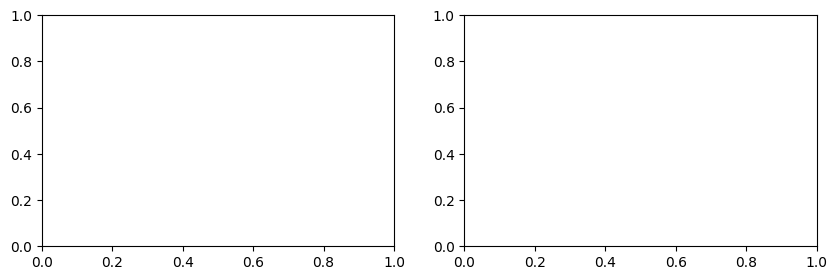

In [15]:
from datetime import datetime
import os

iterations = 1000
# The other mutation rates for the projection
projection = 0.1
# Along which trait is the function plotted
plot = 0

file_path = 'training_logs/plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
os.makedirs(file_path)
figure, axis = plt.subplots(1, 2, figsize=(10, 3))
x_plot = np.linspace(0, 1, 1000)[:, None]
x_paddings = np.linspace(projection, projection, 1000)[:, None]
x_linear = np.linspace(0, 1, 1000)[:, None]

for i in tqdm(range(iterations)):
    for j in range(plot):
        x_plot = np.append(x_paddings, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_paddings, axis = 1)
        
    mu_plot, var_plot = model_emukit.predict(x_plot)
    plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])
    
    ei_plot = ei_acquisition.evaluate(x_plot)
    nlcb_plot = nlcb_acquisition.evaluate(x_plot)
    pi_plot = pi_acquisition.evaluate(x_plot)
    
    optimizer = GradientAcquisitionOptimizer(ParameterSpace([ContinuousParameter('size', 0, 1),
                                                             ContinuousParameter('speed', 0, 1),
                                                             ContinuousParameter('vision', 0, 1),
                                                             ContinuousParameter('aggression', 0, 1)]))
    x_new, _ = optimizer.optimize(nlcb_acquisition)
    print(x_new)
    #print(x_new[0][plot])
    plot_acquisition_functions(x_linear, ei_plot, nlcb_plot, pi_plot, x_new[0][plot], axis[1])
    #print(x_new)
    print("Next position to query:", x_new)
    # plot_acquisition_functions(x_plot, ei_plot, nlcb_plot, pi_plot, x_new, axis[i,1])
    
    y_new = target_function_list(x_new)
    X = np.append(X, x_new, axis=0)
    Y = np.append(Y, y_new, axis=0)
    model_emukit.set_data(X, Y)
    plt.savefig(file_path + '/' + str(i) +'.png')
    plt.clf()
    figure, axis = plt.subplots(1, 2, figsize=(10, 3))

plt.show()

In [16]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points = 10000)

In [18]:
main_effects

{'size': array([1.00212832]),
 'speed': array([-0.05077711]),
 'vision': array([-0.05077711]),
 'aggression': array([-0.05077711])}

In [19]:
x_axis = np.linspace(0, 10, 100)
y_axis = np.linspace(0, 10, 100)

X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
data = np.swapaxes(data,0,-1)

In [24]:
def sensitivity_2d(X,sensitivity):
    results = []
    for x in X:
        results.append(sensitivity.compute_statistics(np.array([x[0],x[1],projection,projection]))[1])
    return np.array(results)

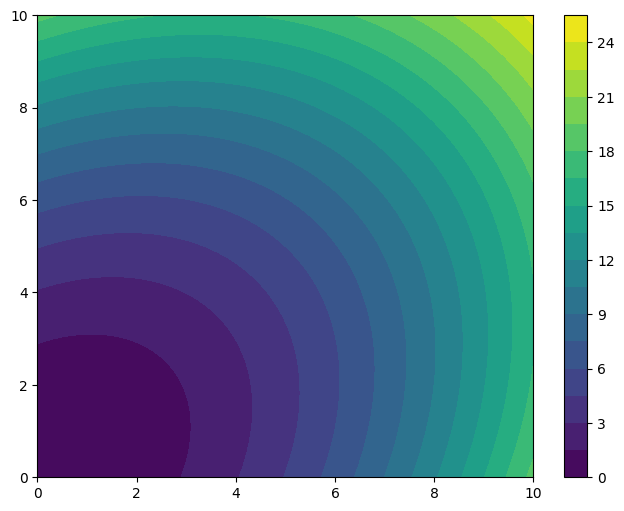

In [25]:
plt.figure(figsize=(8,6))
plt.contourf(X_axis, Y_axis, sensitivity_2d(data,senstivity).reshape(X_axis.shape), levels=20)
plt.colorbar();

In [63]:
sensitivity_2d(data,senstivity).reshape(X.shape)

array([[2.5       , 2.52525253, 2.55050505, ..., 4.94949495, 4.97474747,
        5.        ],
       [2.52525253, 2.55050505, 2.57575758, ..., 4.97474747, 5.        ,
        5.02525253],
       [2.55050505, 2.57575758, 2.6010101 , ..., 5.        , 5.02525253,
        5.05050505],
       ...,
       [4.94949495, 4.97474747, 5.        , ..., 7.3989899 , 7.42424242,
        7.44949495],
       [4.97474747, 5.        , 5.02525253, ..., 7.42424242, 7.44949495,
        7.47474747],
       [5.        , 5.02525253, 5.05050505, ..., 7.44949495, 7.47474747,
        7.5       ]])